In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import os
os.chdir("/content/drive/MyDrive/WORK/Meta_Explainer/Meta-Explainer")
import sys
sys.path.append('/content/drive/MyDrive/WORK/Meta_Explainer/Meta-Explainer')
sys.path

['/content',
 '/env/python',
 '/usr/lib/python311.zip',
 '/usr/lib/python3.11',
 '/usr/lib/python3.11/lib-dynload',
 '',
 '/usr/local/lib/python3.11/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.11/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/drive/MyDrive/WORK/Meta_Explainer/Meta-Explainer']

In [34]:
!pip install tf-keras-vis tensorflow
!pip install lime
!pip install shap
!pip install innvestigate

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 447, in run
^C
^C
^C
^C


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image
import tensorflow.keras.applications.vgg16 as vgg16

from skimage.color import gray2rgb, rgb2gray, label2rgb

from Metrics.LSE_Analysis import lse_calculate
from Images.Relevance.explanations_functions.gradcam_explainer import gradcam_explanations_and_lse_all_classes
from Images.Relevance.explanations_functions.lrp_explainer import lrp_explanations_and_lse_all_classes
from Images.Relevance.explanations_functions.lime_explainer import lime_explanations_and_lse_all_classes
from Images.Relevance.explanations_functions.shap_explainer import shap_explanations_and_lse_all_classes
from aux_functions import visualize_explanations_horizontal_with_original, visualize_all_classes, save_explanations_to_pkl, load_explanations_from_pkl, ensure_single_channel, normalize_map, is_valid_map

from Images.Integrations import owa_integrations, union_owa_integrations, intersection_owa_integrations

#Reading Data and Model (MNIST)



In [3]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# For use with Lime and Shap
x_train_rgb = np.stack([gray2rgb(img) for img in x_train], axis=0)
x_test_rgb = np.stack([gray2rgb(img) for img in x_test], axis=0)

# Convert to Keras-compatible format (add channel dimension for RGB images)
x_train_rgb = x_train_rgb[..., np.newaxis].reshape(-1, 28, 28, 3)
x_test_rgb = x_test_rgb[..., np.newaxis].reshape(-1, 28, 28, 3)

# Preprocess the data
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

In [4]:
# Load model and weights separately
loaded_model = keras.models.load_model("Images/Model/mnist_model_architecture.h5")
loaded_model.load_weights("Images/Model/mnist_model_weights.h5")

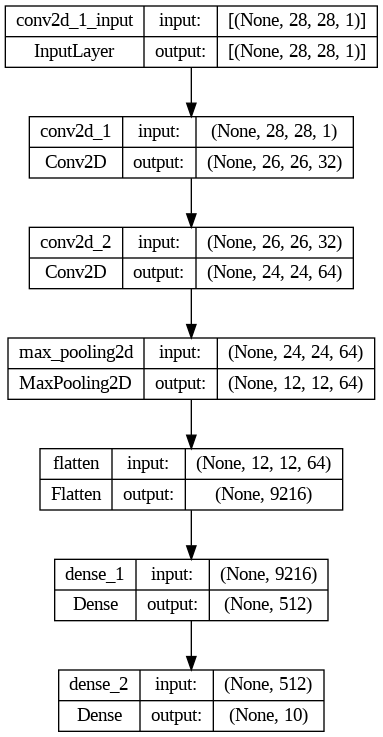

In [5]:
# Visualize the model and save the image
plot_model(loaded_model, to_file="model_topology.png", show_shapes=True, show_layer_names=True)

#Instance Selection (MNIST)

1/1 [==============================] - 0s 63ms/step


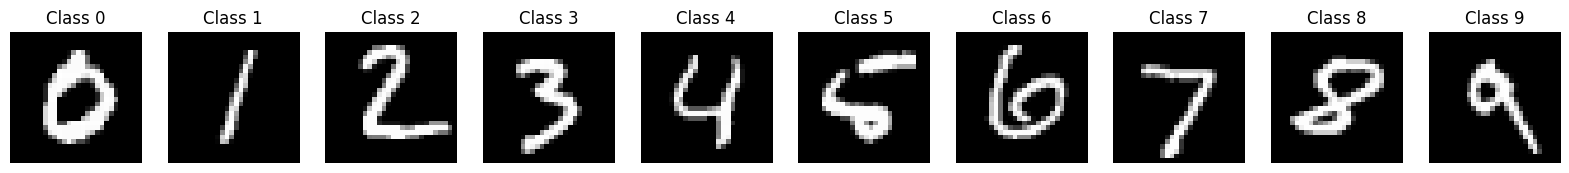

In [6]:
# Function to select a correctly classified image for each class
def select_correctly_classified_images(x_test, y_test, model):
    selected_images = []
    selected_labels = []

    for i in range(10):  # Iterate through all classes (0-9)
        # Get the indices of images belonging to class i
        indices = np.where(y_test == i)[0]

        for idx in indices:
            image = x_test[idx]
            label = y_test[idx]
            # Predict the class using the model
            prediction = np.argmax(model.predict(image[np.newaxis, ...]), axis=1)[0]

            if prediction == label:
                selected_images.append(image)
                selected_labels.append(label)
                break  # Move to the next class once a correctly classified image is selected

    return np.array(selected_images), np.array(selected_labels)

# Select one correctly classified image per class
x_selected, y_selected = select_correctly_classified_images(x_test, y_test, loaded_model)
x_selected_rgb = np.stack([gray2rgb(img) for img in x_selected], axis=0)

# Visualize the selected images
plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(x_selected[i].squeeze(), cmap='gray')
    plt.title(f'Class {y_selected[i]}')
    plt.axis('off')
plt.show()

# Individual Explanations


##GRADCAM++

In [ ]:
# Call to generate GradCAM++ for all classes
gradcam_explanations, lse_gradcam = gradcam_explanations_and_lse_all_classes(
    loaded_model,
    x_selected,
    y_selected,
    threshold=0.85)

In [ ]:
lse_gradcam = [item[0] for item in lse_gradcam]

print(lse_gradcam)
sum= np.sum(lse_gradcam)
prom= sum/10
print(f"Promedio: {prom}")

In [ ]:
# Verify and adjust lse_value if they are greater than 9.5
gradcam_explanations_data = {
    'explanations': gradcam_explanations,
    'lse_value': [min(value, 9.5) for value in lse_gradcam]  # Replace values greater than 9.5 with 9.5
}

save_explanations_to_pkl(gradcam_explanations_data, "Images/Relevance/explanations_pkl/gradcam_explanation_data.pkl")

##LRP

In [ ]:
tf.compat.v1.disable_eager_execution()  # Disable eager execution for compatibility with certain TensorFlow operations

# Load model and weights
loaded_model = keras.models.load_model("Images/Model/mnist_model_architecture.h5")
loaded_model.load_weights("Images/Model/mnist_model_weights.h5")

# Run LRP for all selected images
lrp_explanations, lse_lrp = lrp_explanations_and_lse_all_classes(
    loaded_model,
    x_selected,
    y_selected,
    threshold=0.85)

In [ ]:
lse_lrp = [item[0] for item in lse_lrp]

print(lse_lrp)
sum= np.sum(lse_lrp)
prom= sum/10
print(f"Promedio: {prom}")

In [ ]:
# Verify and adjust lse_value if they are greater than 9.5
lrp_explanations_data = {
    'explanations': lrp_explanations,
    'lse_value': [min(value, 9.5) for value in lse_lrp]  # Replace values greater than 9.5 with 9.5
}

save_explanations_to_pkl(lrp_explanations_data, "Images/Relevance/explanations_pkl/lrp_explanation_data.pkl")

##LIME

In [ ]:
# Call to generate LIME explanations for all classes
lime_explanations, lse_lime = lime_explanations_and_lse_all_classes(
    loaded_model,
    x_selected_rgb,
    y_selected,
    threshold=0.85)

In [ ]:
lse_lime = [item[0] for item in lse_lime]

print(lse_lime)
sum= np.sum(lse_lime)
prom= sum/10
print(f"Promedio: {prom}")

In [ ]:
# Verify and adjust lse_value if they are greater than 9.5
lime_explanations_data = {
    'explanations': lime_explanations,
    'lse_value': [min(value, 9.5) for value in lse_lime]  # Replace values greater than 9.5 with 9.5
}

save_explanations_to_pkl(lime_explanations_data, "Images/Relevance/explanations_pkl/lime_explanation_data.pkl")

##SHAP

In [ ]:
# Call to generate SHAP explanations for all classes
shap_explanations, lse_shap = shap_explanations_and_lse_all_classes(
    loaded_model,
    x_selected,
    x_train,
    y_selected,
    thershold = 0.85)

In [ ]:
lse_shap = [item[0] for item in lse_shap]

print(lse_shap)
sum= np.sum(lse_shap)
prom= sum/10
print(f"Promedio: {prom}")

In [ ]:
# Verify and adjust lse_value if they are greater than 9.5
shap_explanations_data = {
    'explanations': shap_explanations,
    'lse_value':  [min(value, 9.5) for value in lse_shap]  # Replace values greater than 9.5 with 9.5
}

save_explanations_to_pkl(shap_explanations_data, "Images/Relevance/explanations_pkl/shap_explanation_data.pkl")


# Reading Explanations

In [7]:
# List of paths to explanation files
explanation_paths = [
    "Images/Relevance/explanations_pkl/gradcam_explanation_data.pkl",
    "Images/Relevance/explanations_pkl/lrp_explanation_data.pkl",
    "Images/Relevance/explanations_pkl/lime_explanation_data.pkl",
    "Images/Relevance/explanations_pkl/shap_explanation_data.pkl"
]

# Load the explanations
new_explanations_data = [load_explanations_from_pkl(path) for path in explanation_paths]

Explanations loaded from Images/Relevance/explanations_pkl/gradcam_explanation_data.pkl
Explanations loaded from Images/Relevance/explanations_pkl/lrp_explanation_data.pkl
Explanations loaded from Images/Relevance/explanations_pkl/lime_explanation_data.pkl
Explanations loaded from Images/Relevance/explanations_pkl/shap_explanation_data.pkl


# INTEGRATION

##OWA

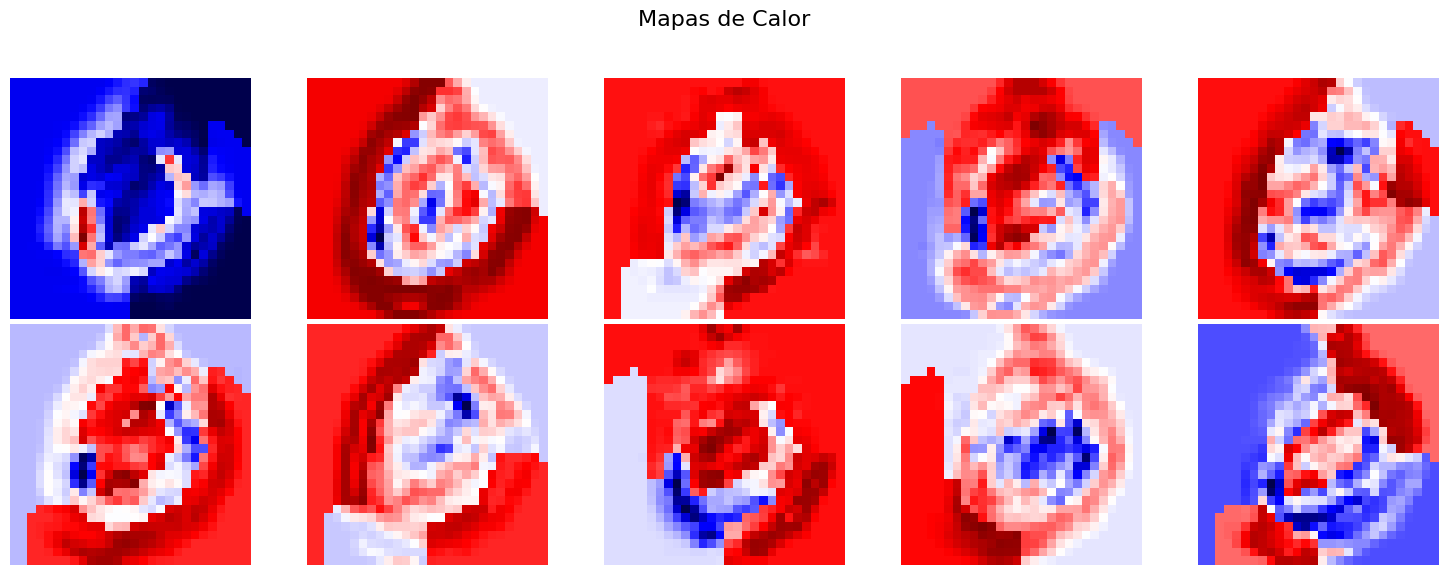

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 1.0, Min: 0.0
Mapa 1: Max: 1.0, Min: 0.0
Mapa 2: Max: 1.0, Min: 0.0
Mapa 3: Max: 1.0, Min: 0.0
Mapa 4: Max: 1.0, Min: 0.0
Mapa 5: Max: 1.0, Min: 0.0
Mapa 6: Max: 1.0, Min: 0.0
Mapa 7: Max: 1.0, Min: 0.0
Mapa 8: Max: 1.0, Min: 0.0
Mapa 9: Max: 1.0, Min: 0.0
Cantidad de rasgos mayores que 0.85: 4
Indices mayores que 0.85: [428 456 484 512]
Suma clase objetivo: 3.623459232118263
Suma de otras clases: 10.53828797005111
IFI calculado: 3.094538048470714


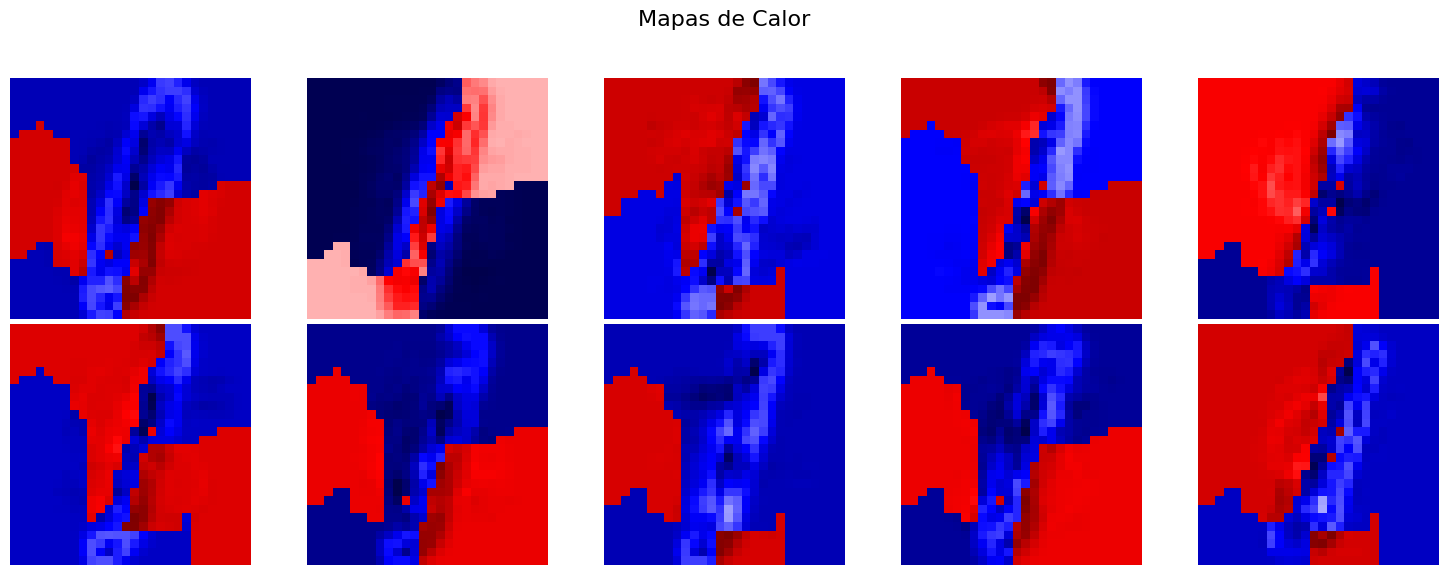

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 1.0, Min: 0.0
Mapa 1: Max: 1.0, Min: 0.0
Mapa 2: Max: 1.0, Min: 0.0
Mapa 3: Max: 1.0, Min: 0.0
Mapa 4: Max: 1.0, Min: 0.0
Mapa 5: Max: 1.0, Min: 0.0
Mapa 6: Max: 1.0, Min: 0.0
Mapa 7: Max: 1.0, Min: 0.0
Mapa 8: Max: 1.0, Min: 0.0
Mapa 9: Max: 1.0, Min: 0.0
Cantidad de rasgos mayores que 0.85: 9
Indices mayores que 0.85: [323 350 351 378 406 434 461 462 489]
Suma clase objetivo: 8.306572304716656
Suma de otras clases: 12.305444040806174
IFI calculado: 6.075290781424915


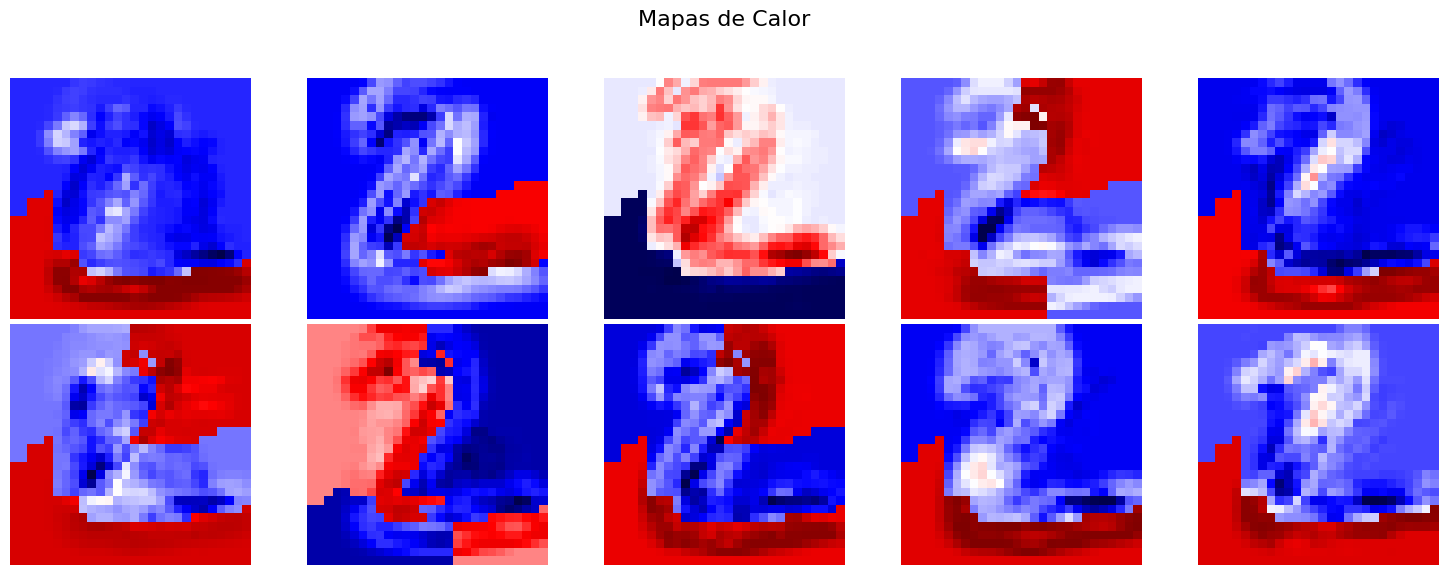

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 1.0, Min: 0.0
Mapa 1: Max: 1.0, Min: 0.0
Mapa 2: Max: 1.0, Min: 0.0
Mapa 3: Max: 1.0, Min: 0.0
Mapa 4: Max: 1.0, Min: 0.0
Mapa 5: Max: 1.0, Min: 0.0
Mapa 6: Max: 1.0, Min: 0.0
Mapa 7: Max: 1.0, Min: 0.0
Mapa 8: Max: 1.0, Min: 0.0
Mapa 9: Max: 1.0, Min: 0.0
Cantidad de rasgos mayores que 0.85: 9
Indices mayores que 0.85: [485 486 513 579 580 581 582 583 584]
Suma clase objetivo: 8.263493921710124
Suma de otras clases: 16.87370341555858
IFI calculado: 4.407535409613525


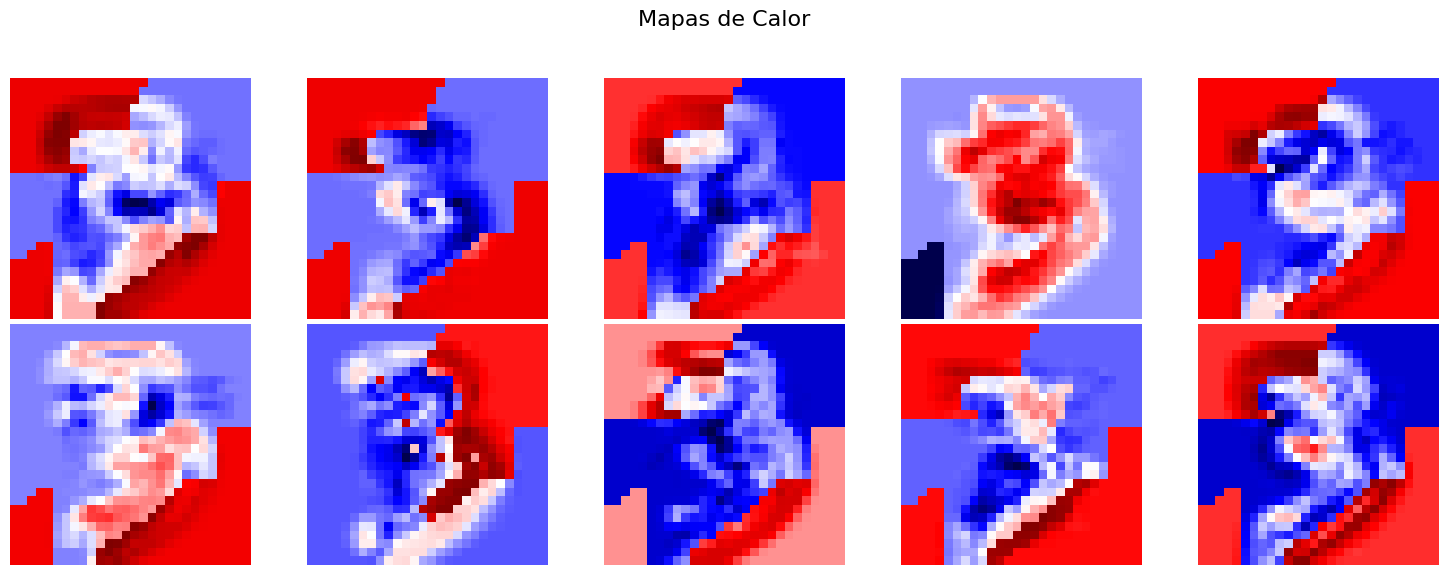

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 1.0, Min: 0.0
Mapa 1: Max: 1.0, Min: 0.0
Mapa 2: Max: 1.0, Min: 0.0
Mapa 3: Max: 1.0, Min: 0.0
Mapa 4: Max: 1.0, Min: 0.0
Mapa 5: Max: 1.0, Min: 0.0
Mapa 6: Max: 1.0, Min: 0.0
Mapa 7: Max: 1.0, Min: 0.0
Mapa 8: Max: 1.0, Min: 0.0
Mapa 9: Max: 1.0, Min: 0.0
Cantidad de rasgos mayores que 0.85: 17
Indices mayores que 0.85: [232 376 404 405 406 407 408 409 431 432 433 434 460 461 462 463 628]
Suma clase objetivo: 15.545558921303424
Suma de otras clases: 52.84901407925081
IFI calculado: 2.6473536494347067


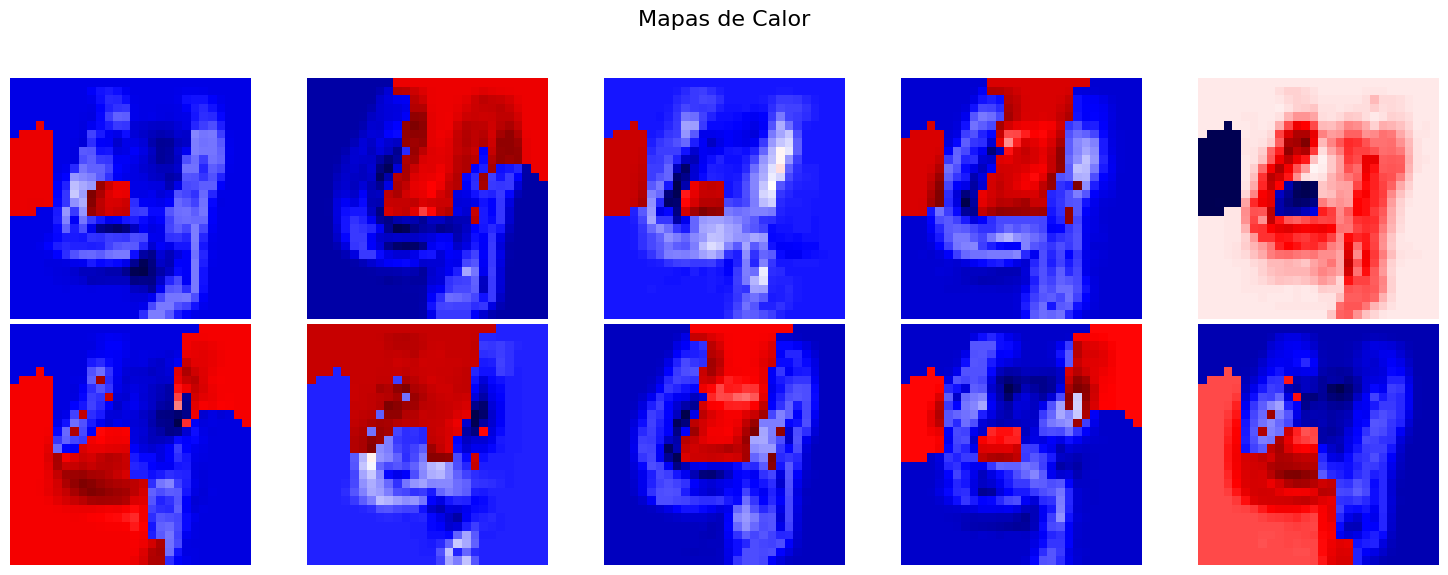

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 1.0, Min: 0.0
Mapa 1: Max: 1.0, Min: 0.0
Mapa 2: Max: 1.0, Min: 0.0
Mapa 3: Max: 1.0, Min: 0.0
Mapa 4: Max: 1.0, Min: 0.0
Mapa 5: Max: 1.0, Min: 0.0
Mapa 6: Max: 1.0, Min: 0.0
Mapa 7: Max: 1.0, Min: 0.0
Mapa 8: Max: 1.0, Min: 0.0
Mapa 9: Max: 1.0, Min: 0.0
Cantidad de rasgos mayores que 0.85: 15
Indices mayores que 0.85: [179 180 206 207 208 234 235 236 262 289 316 344 428 456 605]
Suma clase objetivo: 13.509772982135644
Suma de otras clases: 48.82315889226424
IFI calculado: 2.490374641827728


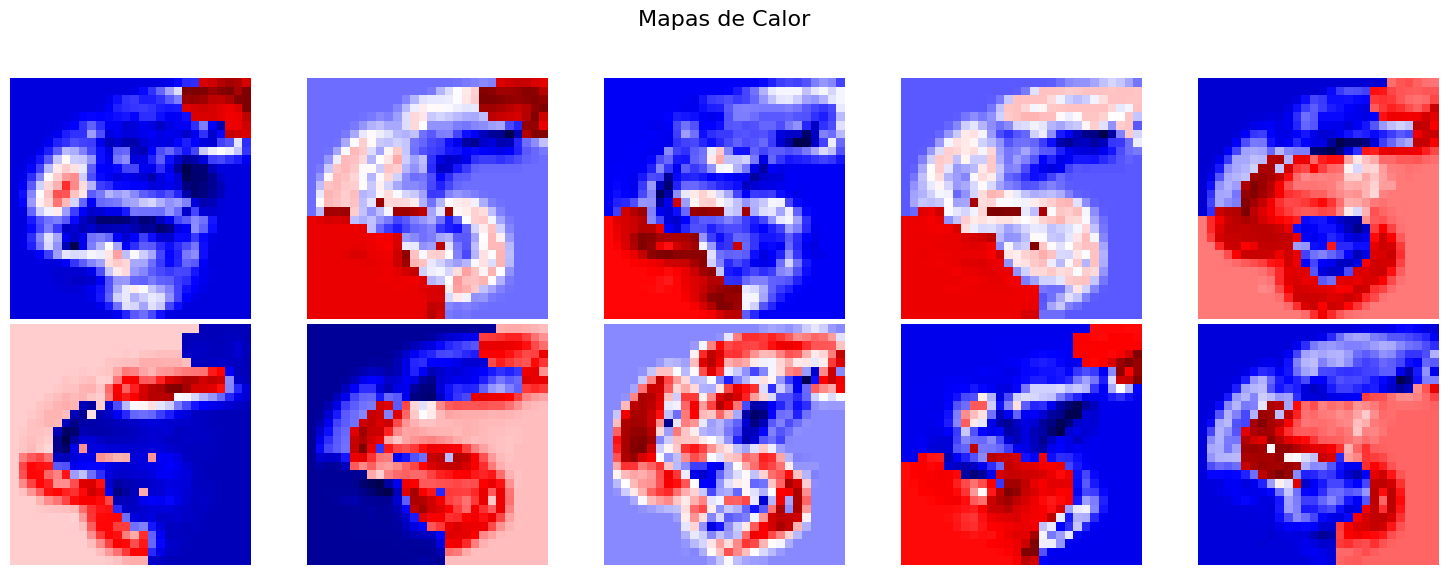

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 1.0, Min: 0.0
Mapa 1: Max: 1.0, Min: 0.0
Mapa 2: Max: 1.0, Min: 0.0
Mapa 3: Max: 1.0, Min: 0.0
Mapa 4: Max: 1.0, Min: 0.0
Mapa 5: Max: 1.0, Min: 0.0
Mapa 6: Max: 1.0, Min: 0.0
Mapa 7: Max: 1.0, Min: 0.0
Mapa 8: Max: 1.0, Min: 0.0
Mapa 9: Max: 1.0, Min: 0.0
Cantidad de rasgos mayores que 0.85: 12
Indices mayores que 0.85: [187 188 189 191 212 213 214 215 216 240 241 242]
Suma clase objetivo: 10.89835954997635
Suma de otras clases: 29.895316335441056
IFI calculado: 3.280956617057321


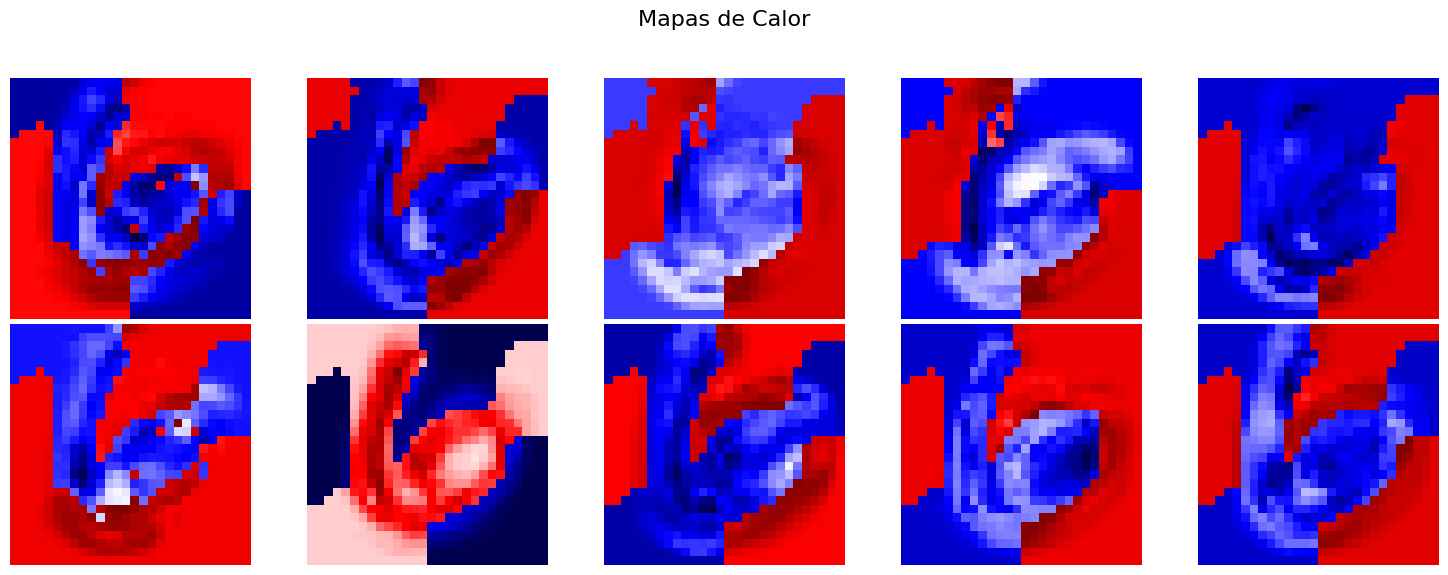

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 1.0, Min: 0.0
Mapa 1: Max: 1.0, Min: 0.0
Mapa 2: Max: 1.0, Min: 0.0
Mapa 3: Max: 1.0, Min: 0.0
Mapa 4: Max: 1.0, Min: 0.0
Mapa 5: Max: 1.0, Min: 0.0
Mapa 6: Max: 1.0, Min: 0.0
Mapa 7: Max: 1.0, Min: 0.0
Mapa 8: Max: 1.0, Min: 0.0
Mapa 9: Max: 1.0, Min: 0.0
Cantidad de rasgos mayores que 0.85: 30
Indices mayores que 0.85: [ 95 123 150 177 178 205 206 233 260 261 288 316 344 371 372 399 400 427
 428 432 455 456 460 461 483 484 511 512 540 568]
Suma clase objetivo: 27.11156579111296
Suma de otras clases: 58.095211009136776
IFI calculado: 4.200072396357102


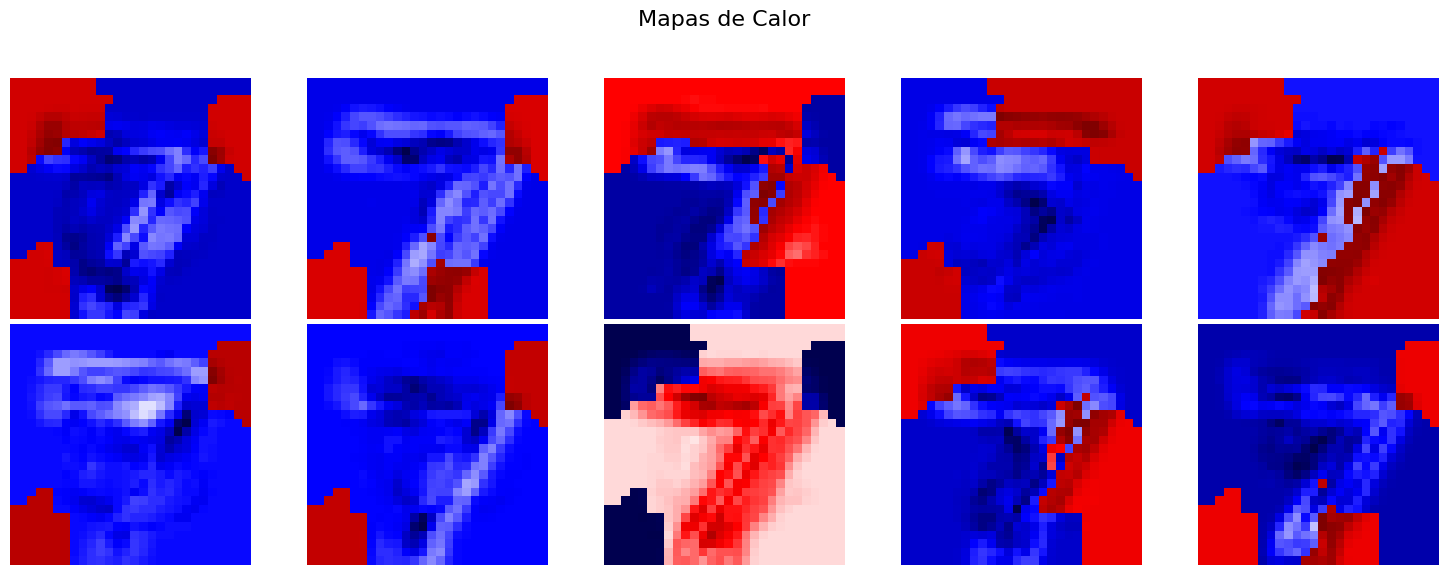

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 1.0, Min: 0.0
Mapa 1: Max: 1.0, Min: 0.0
Mapa 2: Max: 1.0, Min: 0.0
Mapa 3: Max: 1.0, Min: 0.0
Mapa 4: Max: 1.0, Min: 0.0
Mapa 5: Max: 1.0, Min: 0.0
Mapa 6: Max: 1.0, Min: 0.0
Mapa 7: Max: 1.0, Min: 0.0
Mapa 8: Max: 1.0, Min: 0.0
Mapa 9: Max: 1.0, Min: 0.0
Cantidad de rasgos mayores que 0.85: 12
Indices mayores que 0.85: [233 234 235 236 263 264 265 266 267 268 269 684]
Suma clase objetivo: 11.01062592774449
Suma de otras clases: 20.716472359118445
IFI calculado: 4.783422178828773


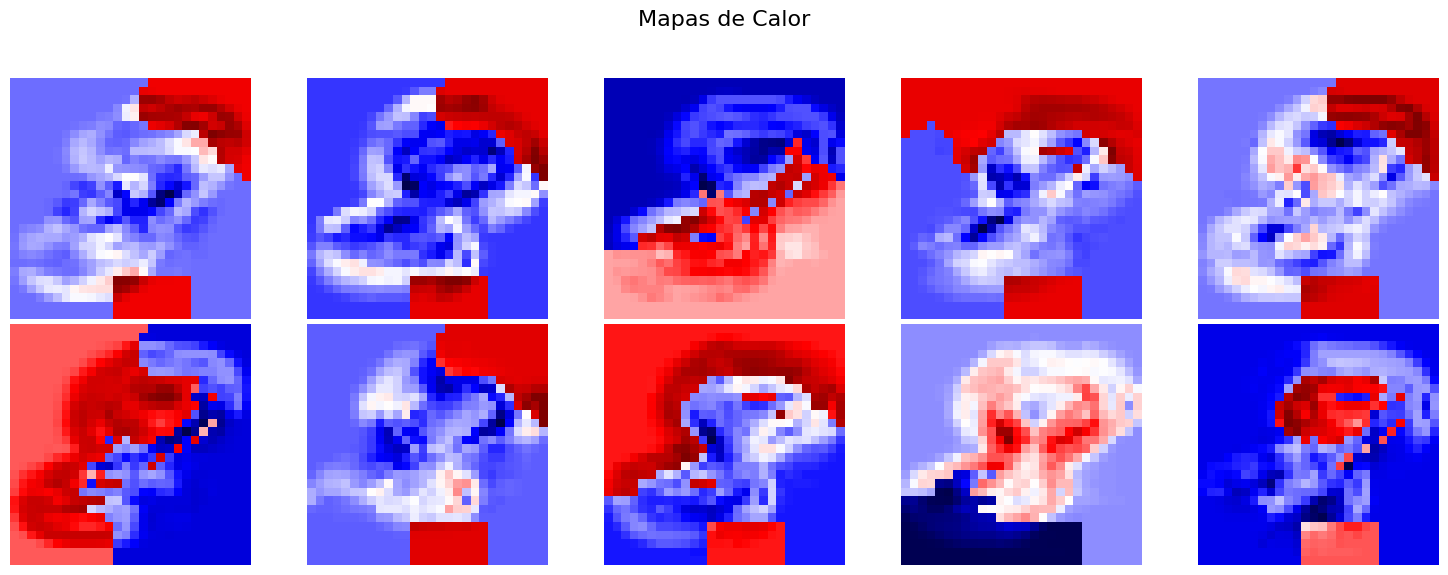

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 1.0, Min: 0.0
Mapa 1: Max: 1.0, Min: 0.0
Mapa 2: Max: 1.0, Min: 0.0
Mapa 3: Max: 1.0, Min: 0.0
Mapa 4: Max: 1.0, Min: 0.0
Mapa 5: Max: 1.0, Min: 0.0
Mapa 6: Max: 1.0, Min: 0.0
Mapa 7: Max: 1.0, Min: 0.0
Mapa 8: Max: 1.0, Min: 0.0
Mapa 9: Max: 1.0, Min: 0.0
Cantidad de rasgos mayores que 0.85: 3
Indices mayores que 0.85: [347 348 376]
Suma clase objetivo: 2.8756059663209905
Suma de otras clases: 8.75500481437171
IFI calculado: 2.9560753244138778


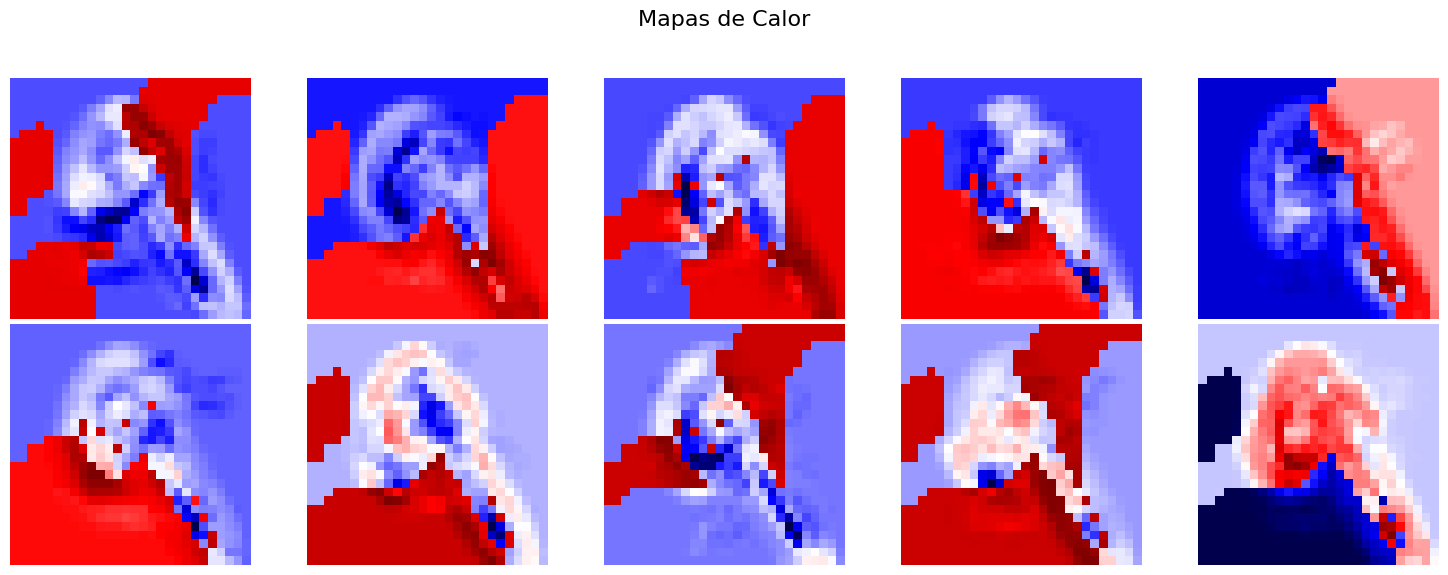

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 1.0, Min: 0.0
Mapa 1: Max: 1.0, Min: 0.0
Mapa 2: Max: 1.0, Min: 0.0
Mapa 3: Max: 1.0, Min: 0.0
Mapa 4: Max: 1.0, Min: 0.0
Mapa 5: Max: 1.0, Min: 0.0
Mapa 6: Max: 1.0, Min: 0.0
Mapa 7: Max: 1.0, Min: 0.0
Mapa 8: Max: 1.0, Min: 0.0
Mapa 9: Max: 1.0, Min: 0.0
Cantidad de rasgos mayores que 0.85: 12
Indices mayores que 0.85: [430 431 432 433 458 459 460 514 637 665 666 694]
Suma clase objetivo: 10.942821677245982
Suma de otras clases: 37.694099659522195
IFI calculado: 2.6127536135575187


In [8]:
# Use weighted sum
integrated_explanations_sum, lse_integrated_sum = owa_integrations.calculate_lse_integrated_explanations(
    explanations_data=new_explanations_data,
    y_selected=y_selected,
    threshold_lse=0.85,
    method="weighted_sum"
)

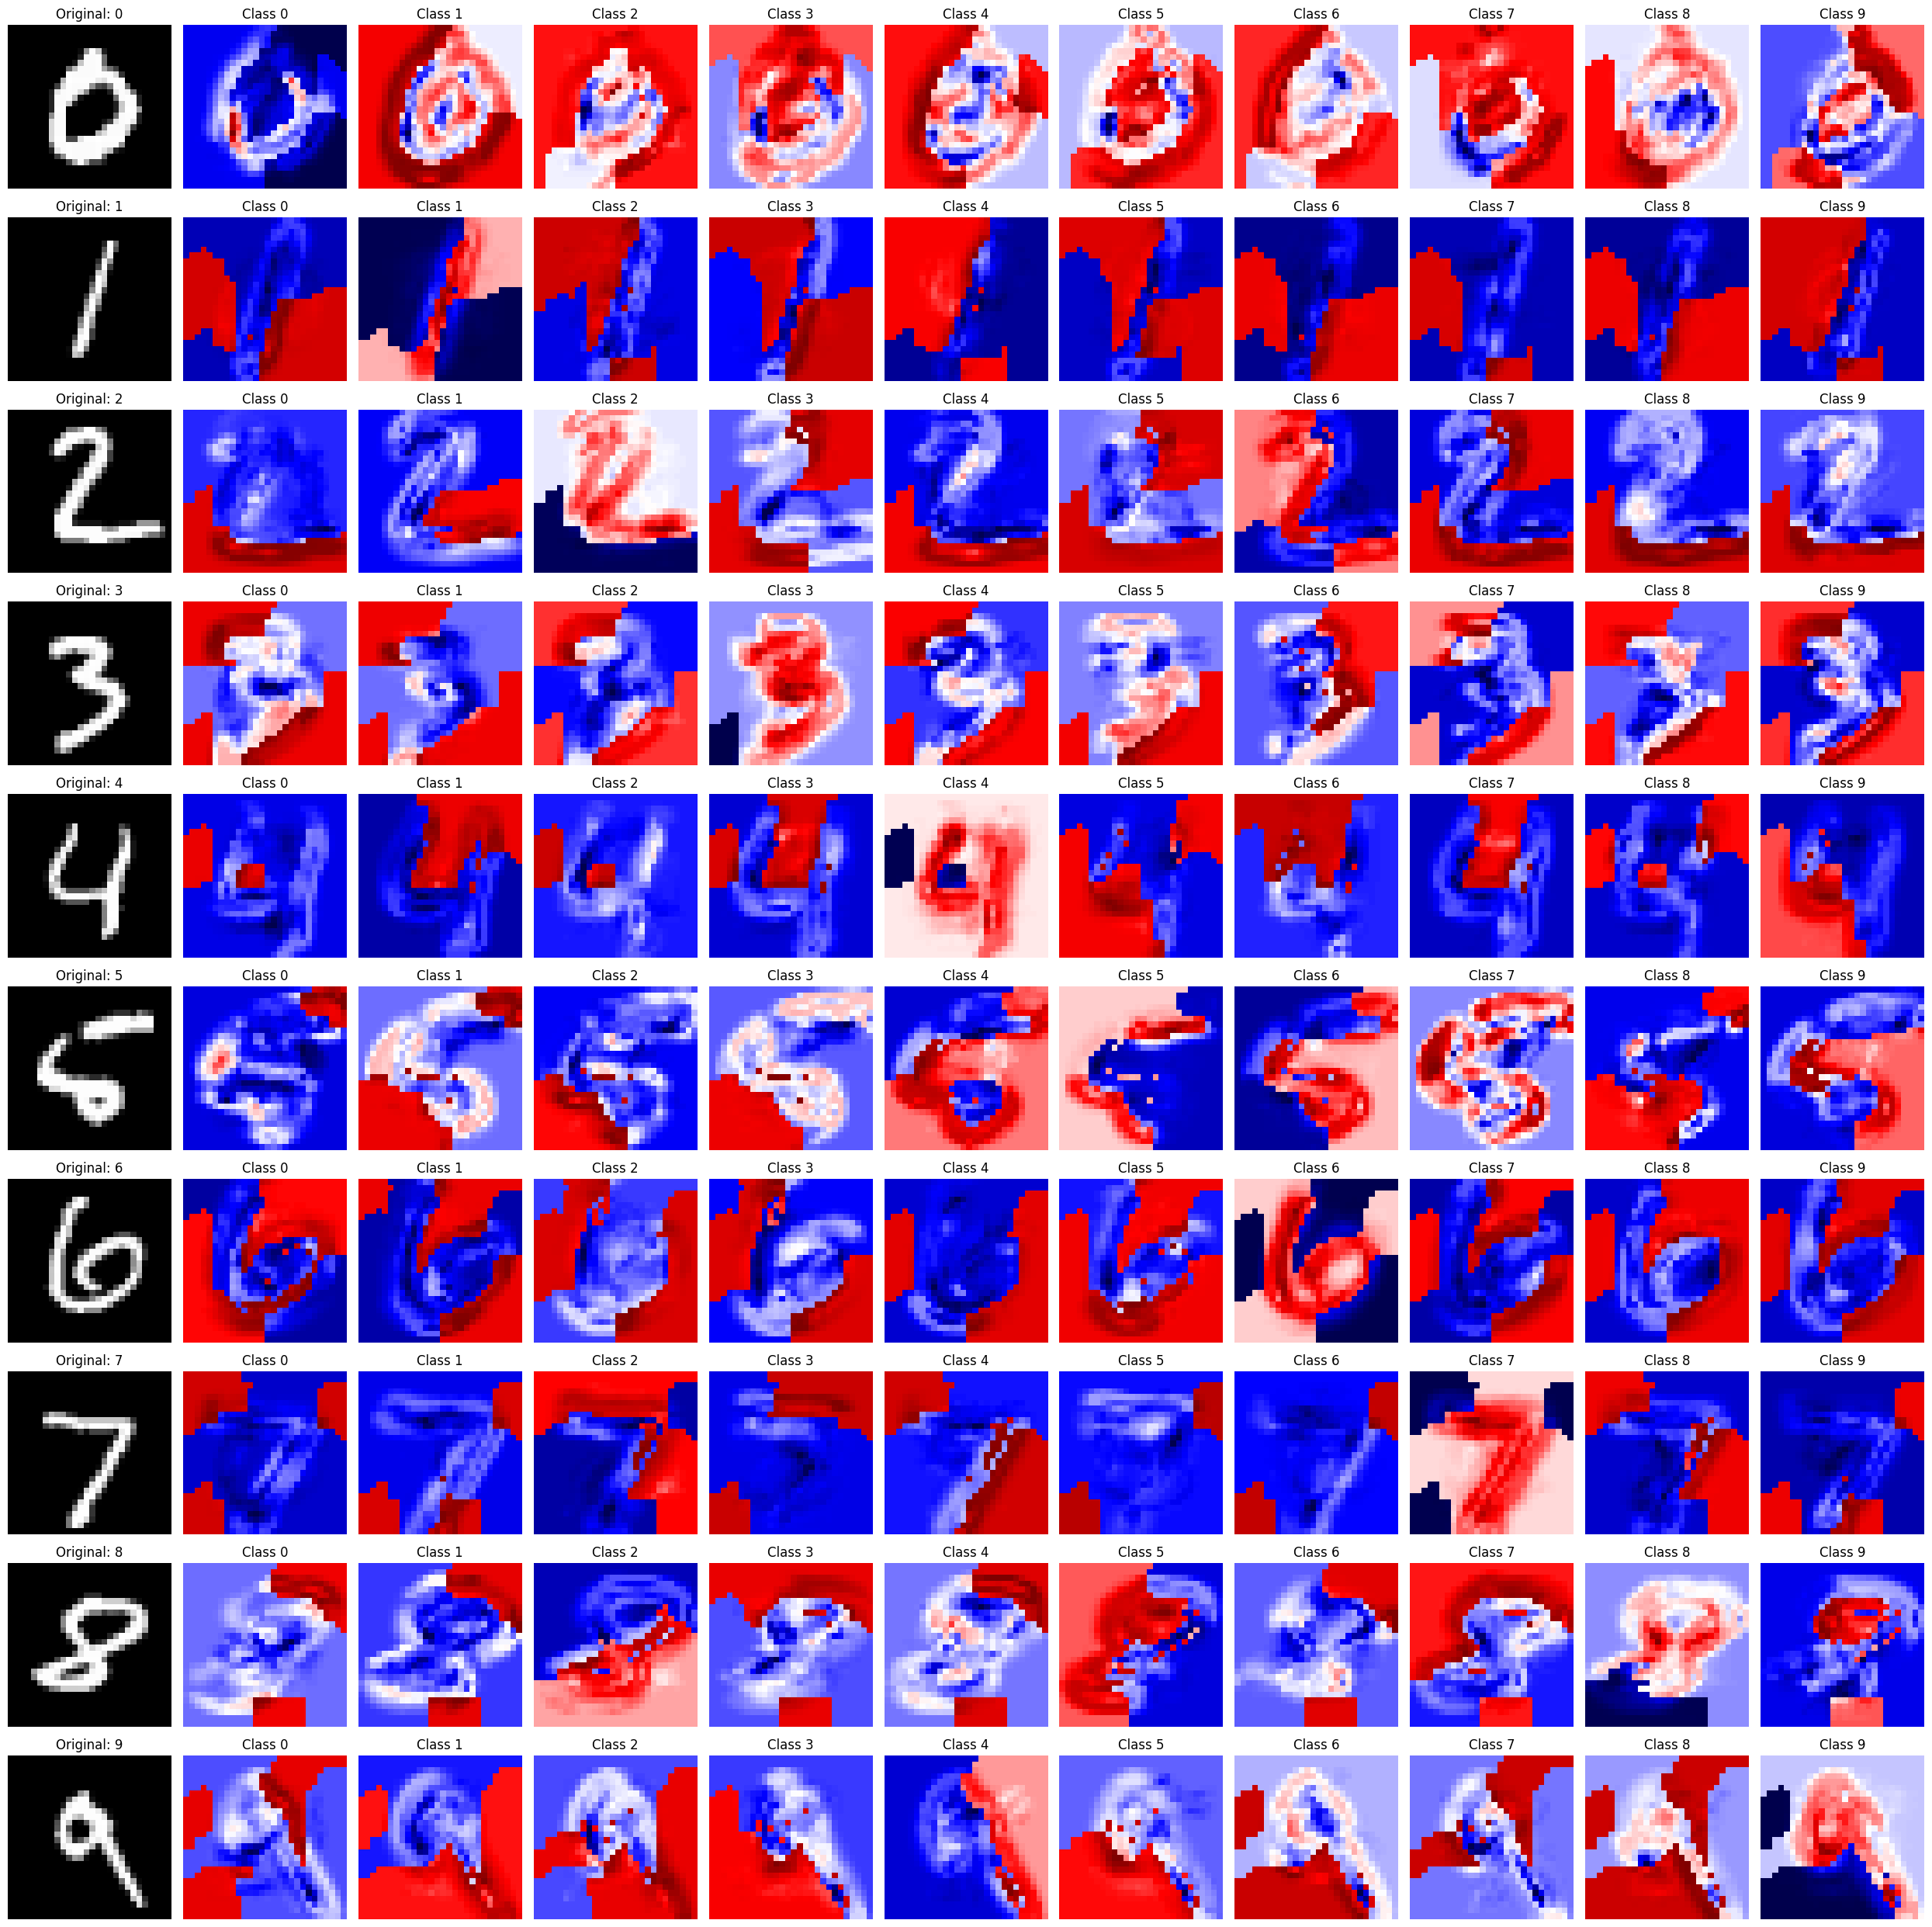

In [9]:
visualize_all_classes(integrated_explanations_sum, x_selected, y_selected)

In [10]:
# Use weighted average
# integrated_explanations_average, lse_integrated_average = owa_integrations.calculate_lse_integrated_explanations(
#     explanations_data=explanations_data,
#     y_selected=y_selected,
#     threshold_lse= 0.85,
#     method="weighted_average"
# )


In [11]:
# use simple average
# integrated_explanations_simple, lse_integrated_simple = owa_integrations.calculate_lse_integrated_explanations(
#     explanations_data=explanations_data,
#     y_selected=y_selected,
#     threshold_lse= 0.85,
#     method="simple_average"
# )

##UNION

In [12]:
# Execute the calculation to obtain the integrated explanations and integrated LSE
# Use weighted sum
integrated_explanations_union, lse_integrated_union = union_owa_integrations.calculate_lse_union_integrated_explanations(
    explanations_data=new_explanations_data,
    y_selected=y_selected,
    threshold=0.85,
    operator="sum"
)

Output hidden; open in https://colab.research.google.com to view.

In [13]:
# Use Max
# union_max_exp, union_max_lse = union_owa_integrations.calculate_lse_union_integrated_explanations(
#     new_explanations_data,
#     y_selected,
#     threshold=0.75,
#     operator="max"
#     )

##Intersección

Total classes: 10


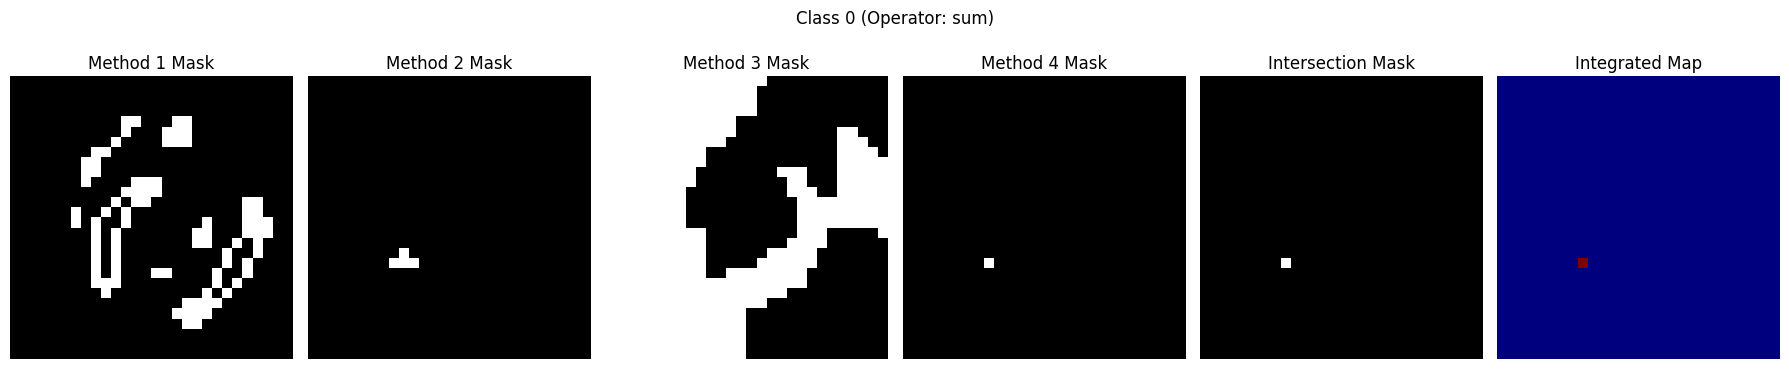

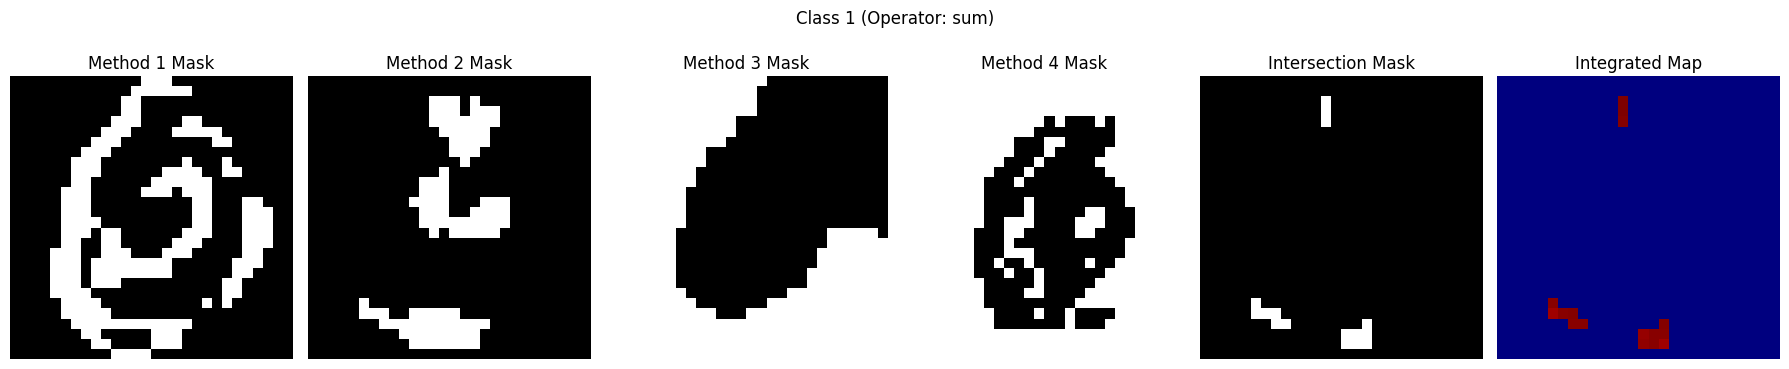

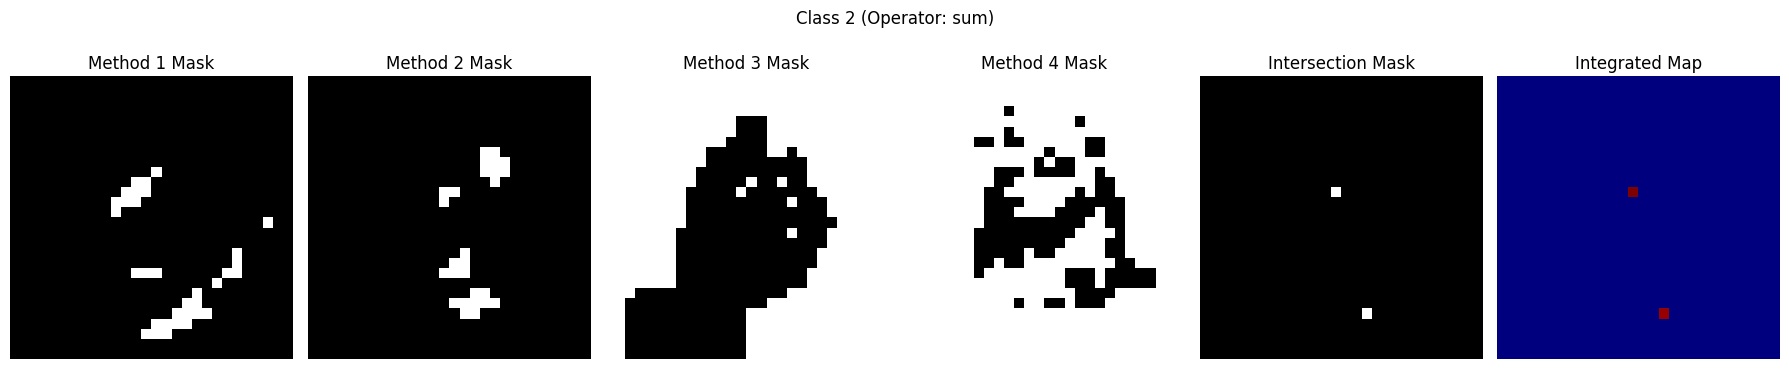

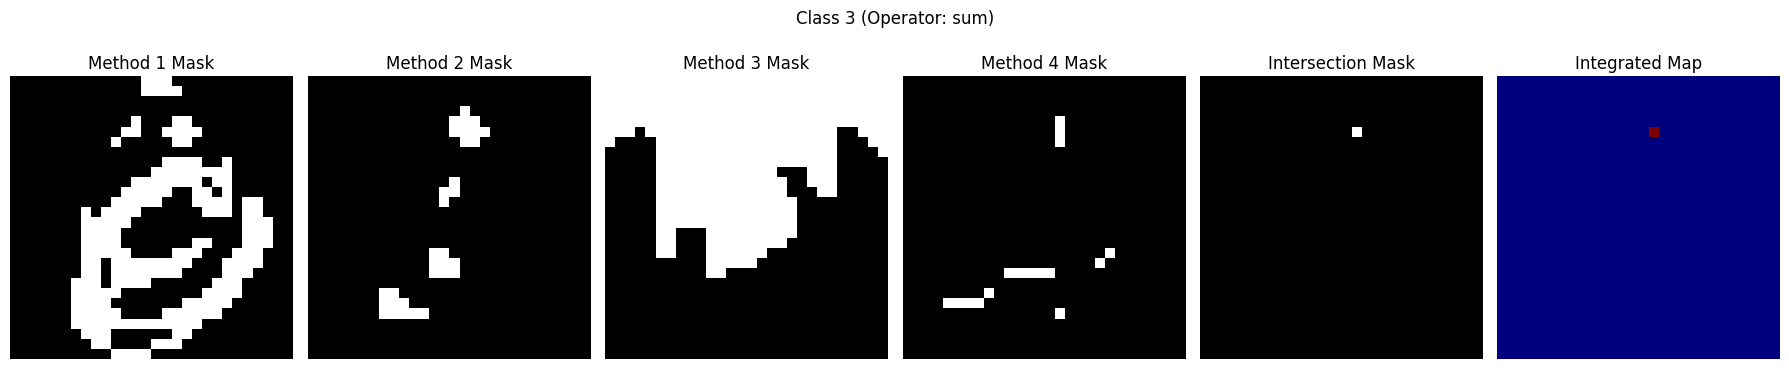

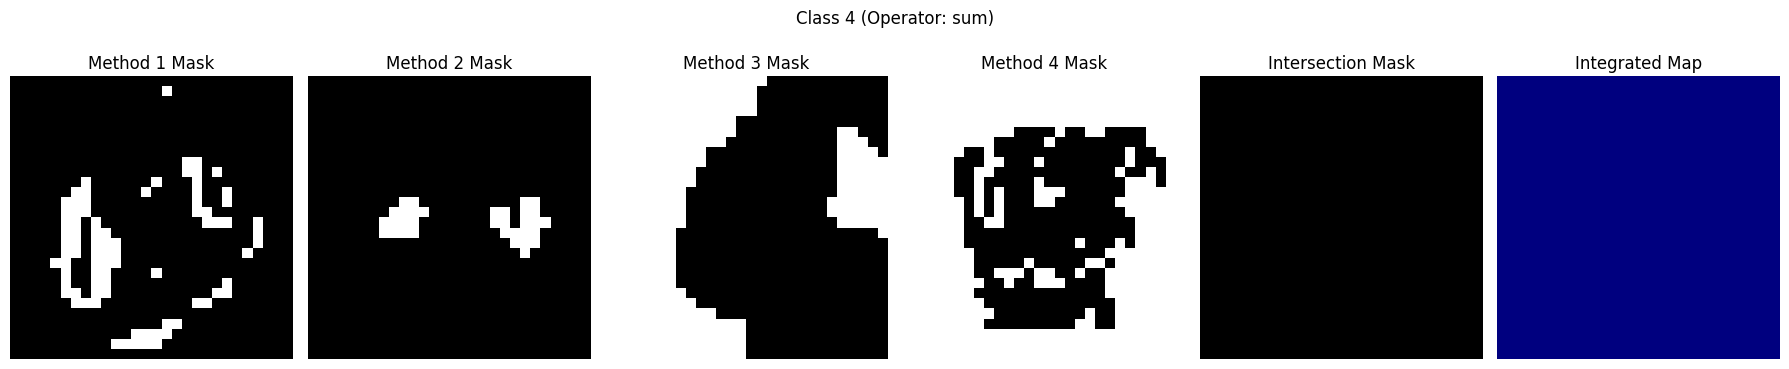

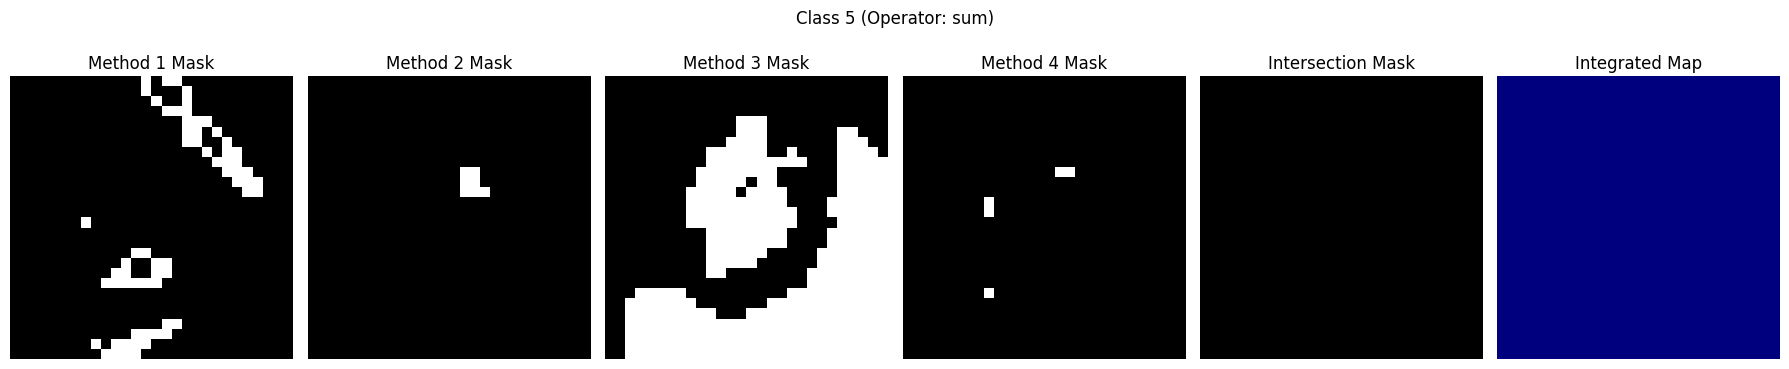

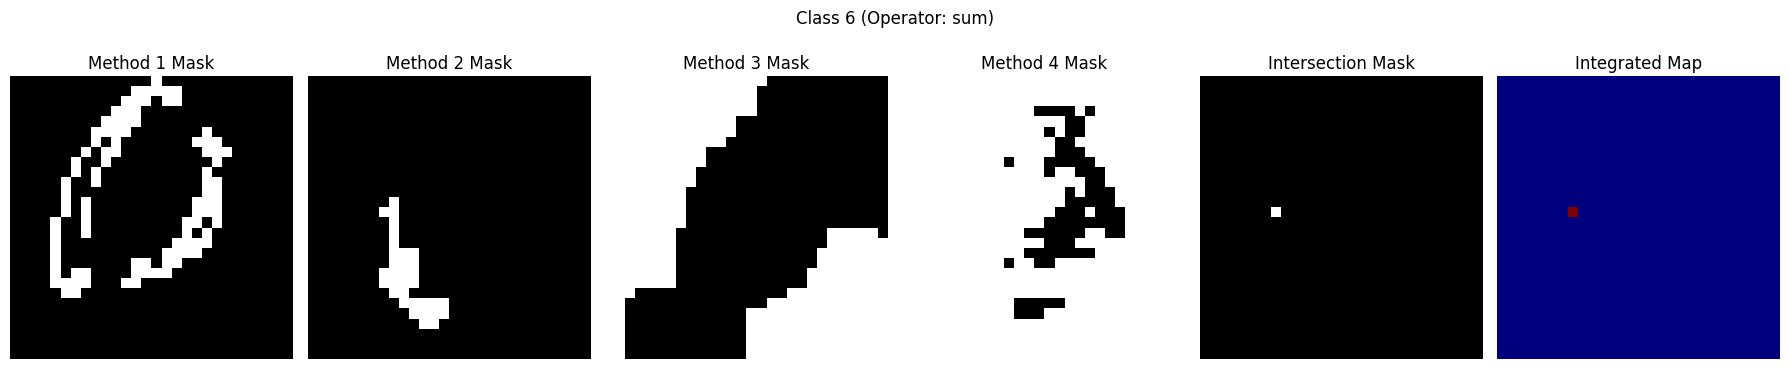

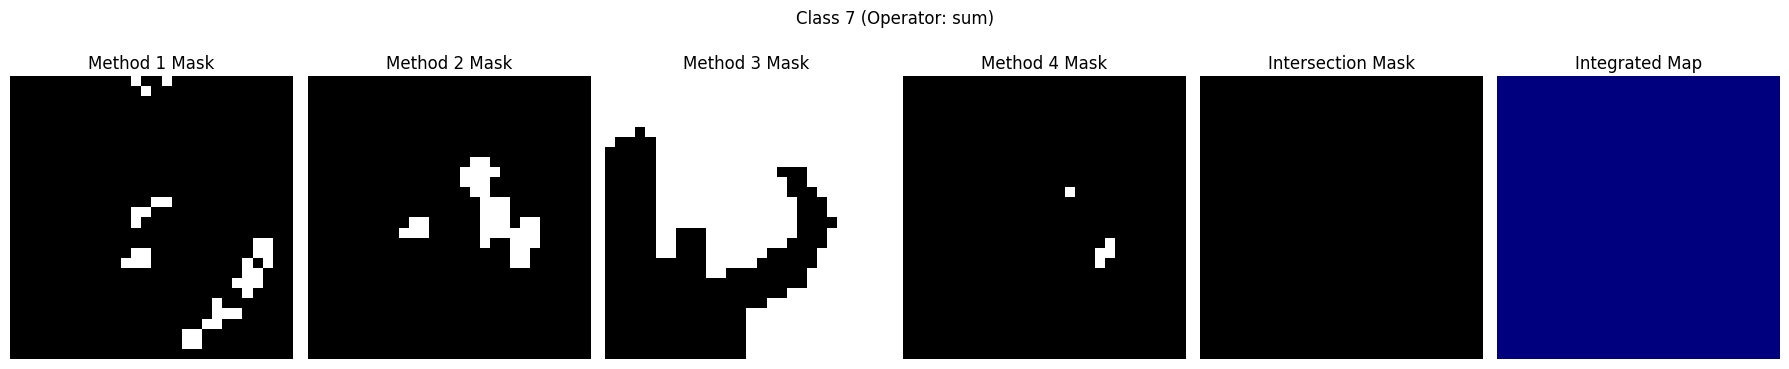

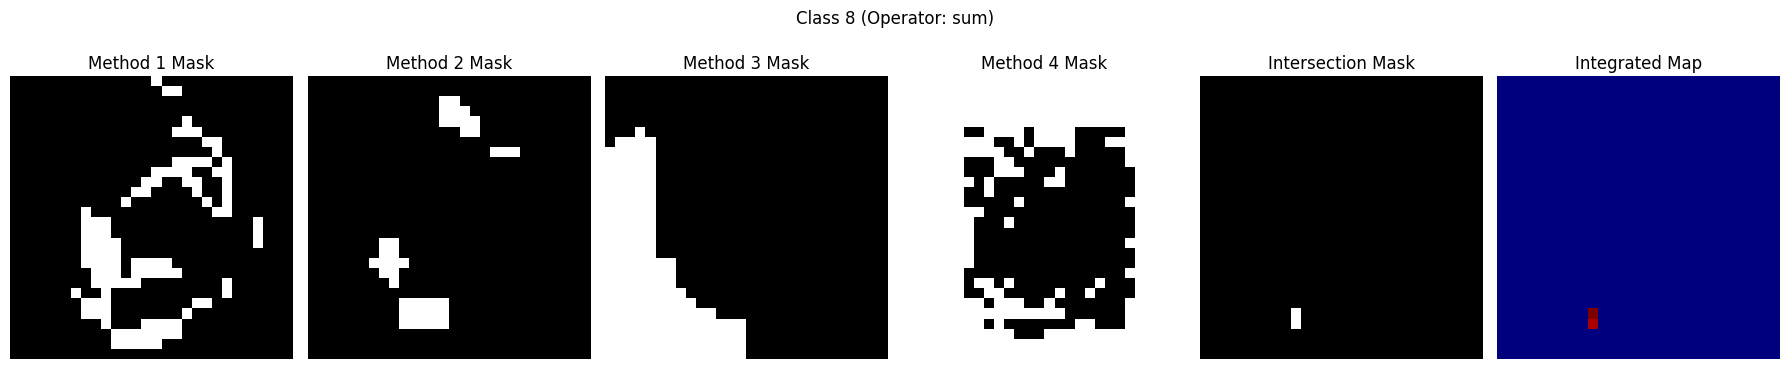

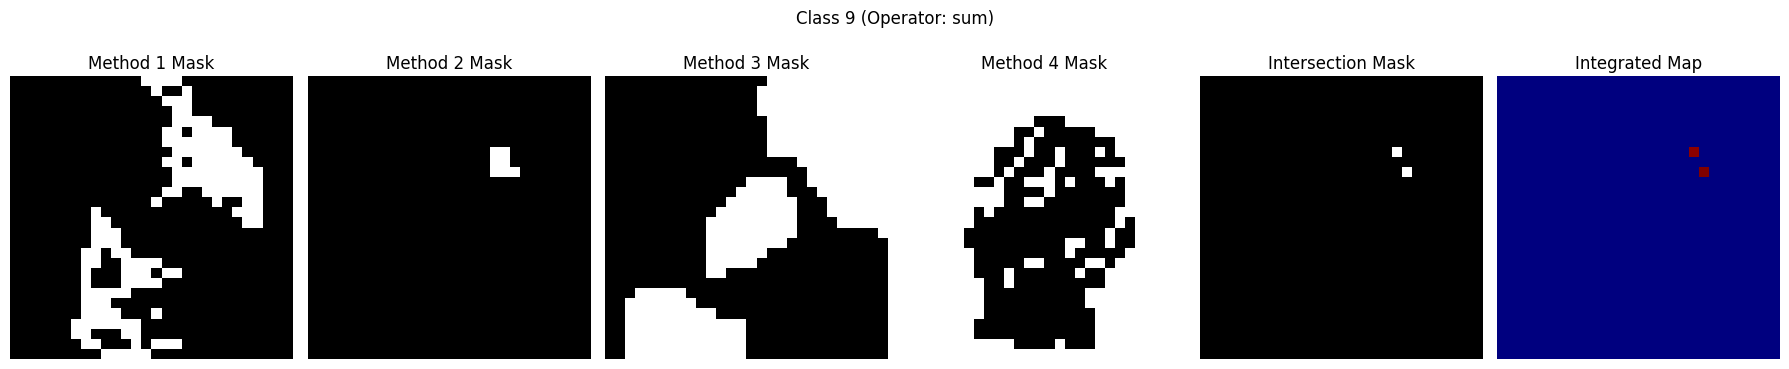

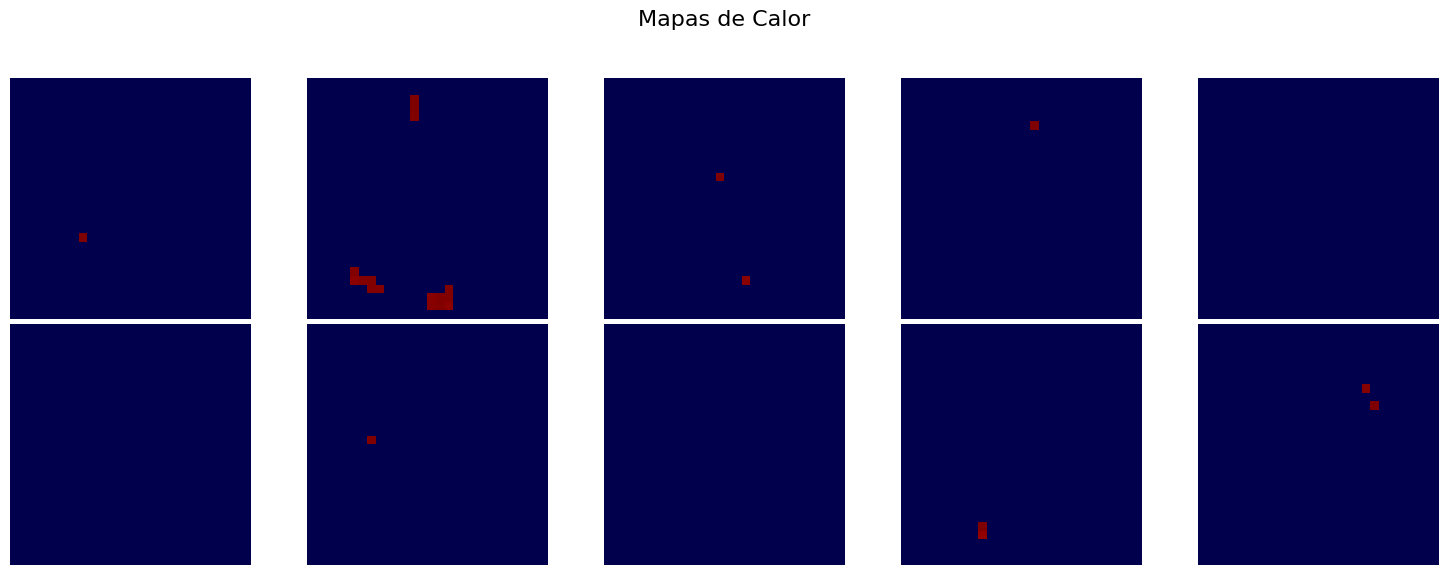

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 3
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 1.0, Min: 0.0
Mapa 1: Max: 1.0, Min: 0.0
Mapa 2: Max: 1.0, Min: 0.0
Mapa 3: Max: 1.0, Min: 0.0
Mapa 4: Max: 0.0, Min: 0.0
Mapa 5: Max: 0.0, Min: 0.0
Mapa 6: Max: 1.0, Min: 0.0
Mapa 7: Max: 0.0, Min: 0.0
Mapa 8: Max: 1.0, Min: 0.0
Mapa 9: Max: 1.0, Min: 0.0
Cantidad de rasgos mayores que 0.85: 1
Indices mayores que 0.85: [512]
Suma clase objetivo: 1.0
Suma de otras clases: 0.0
IFI calculado: 9.0
Total classes: 10


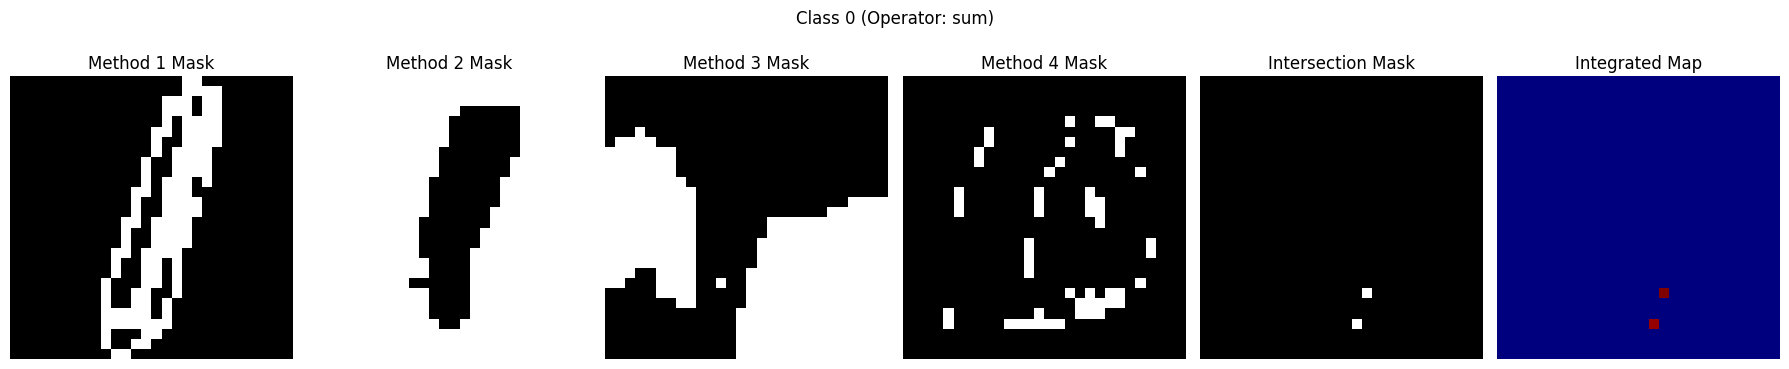

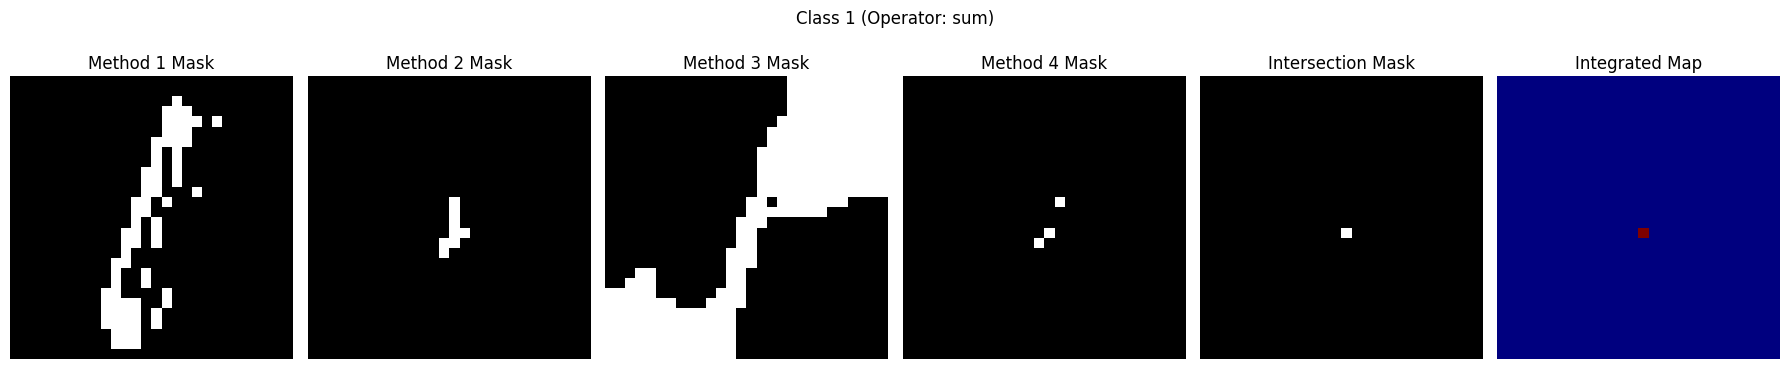

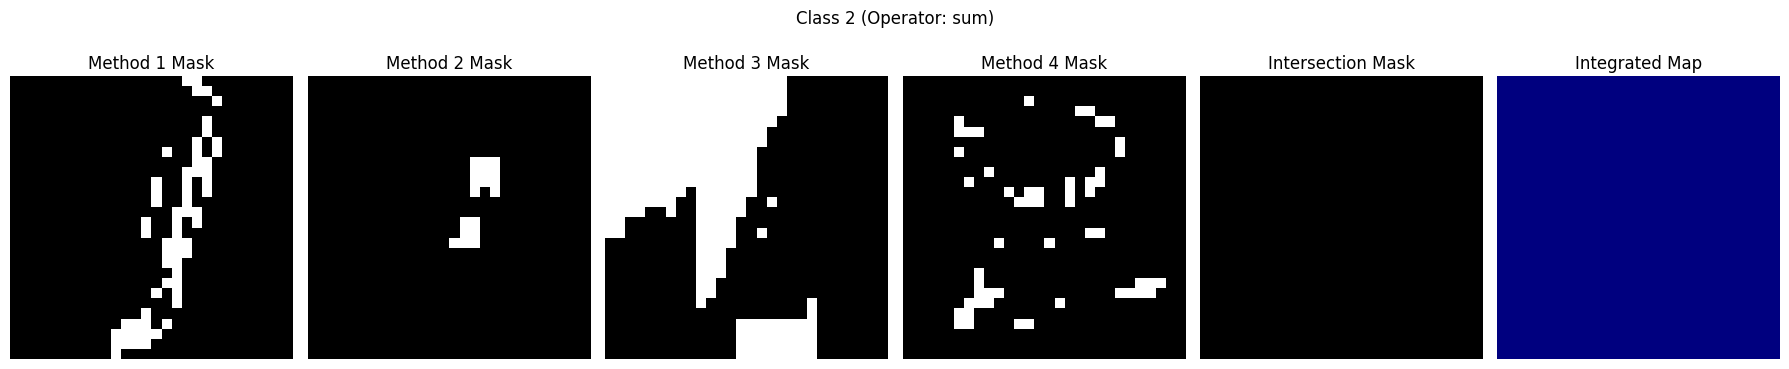

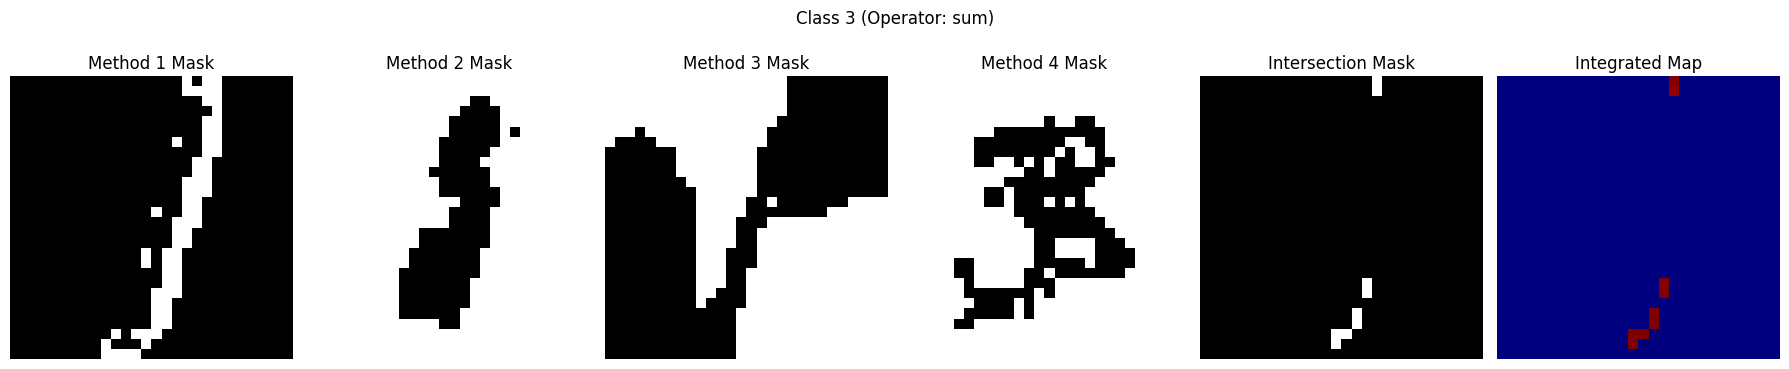

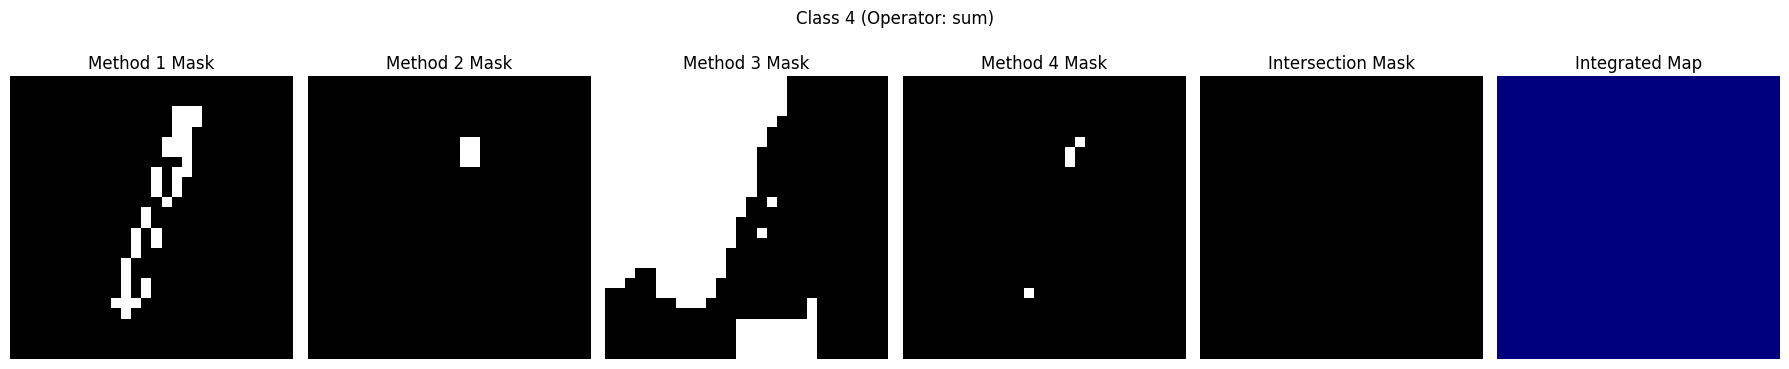

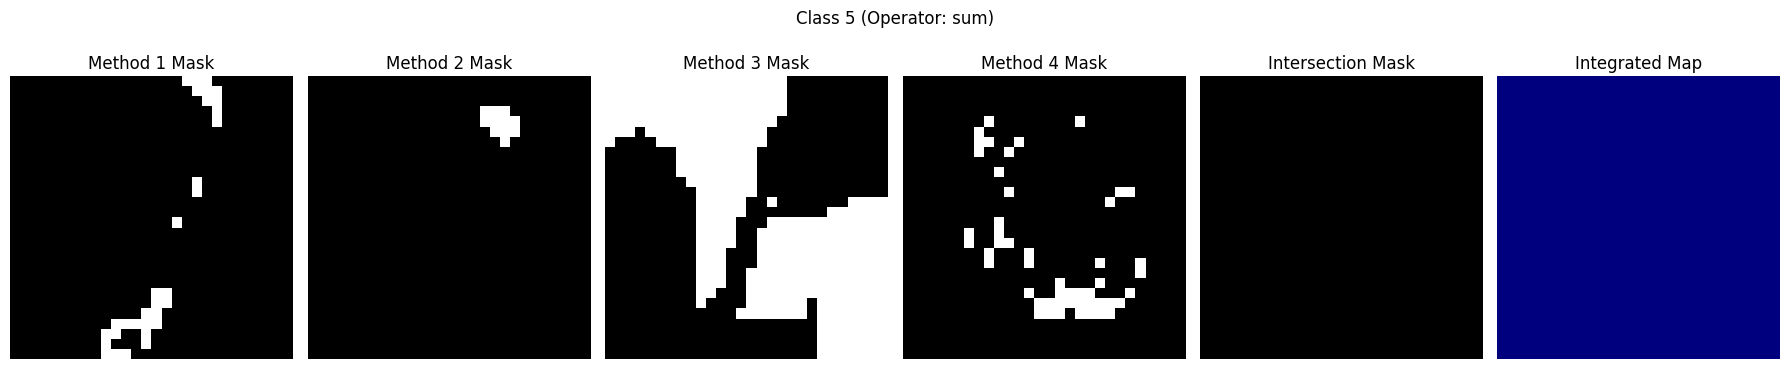

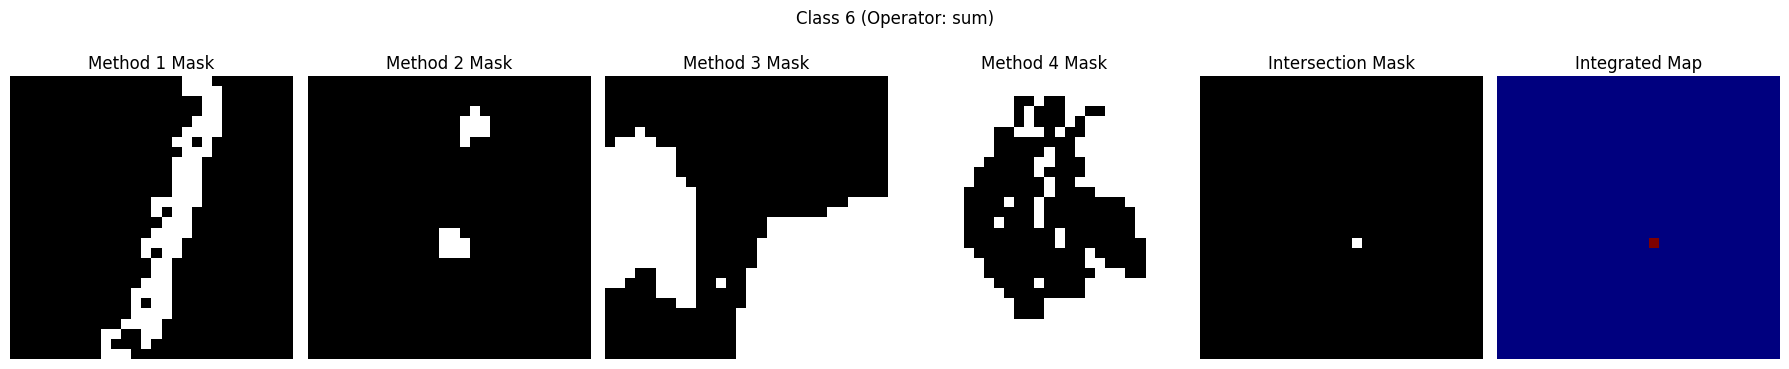

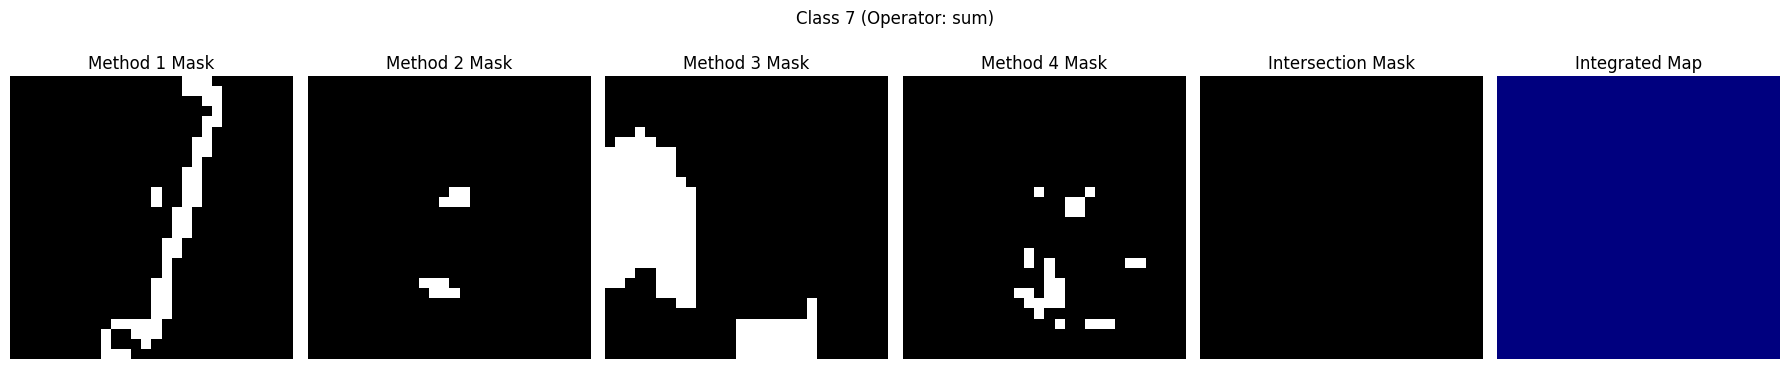

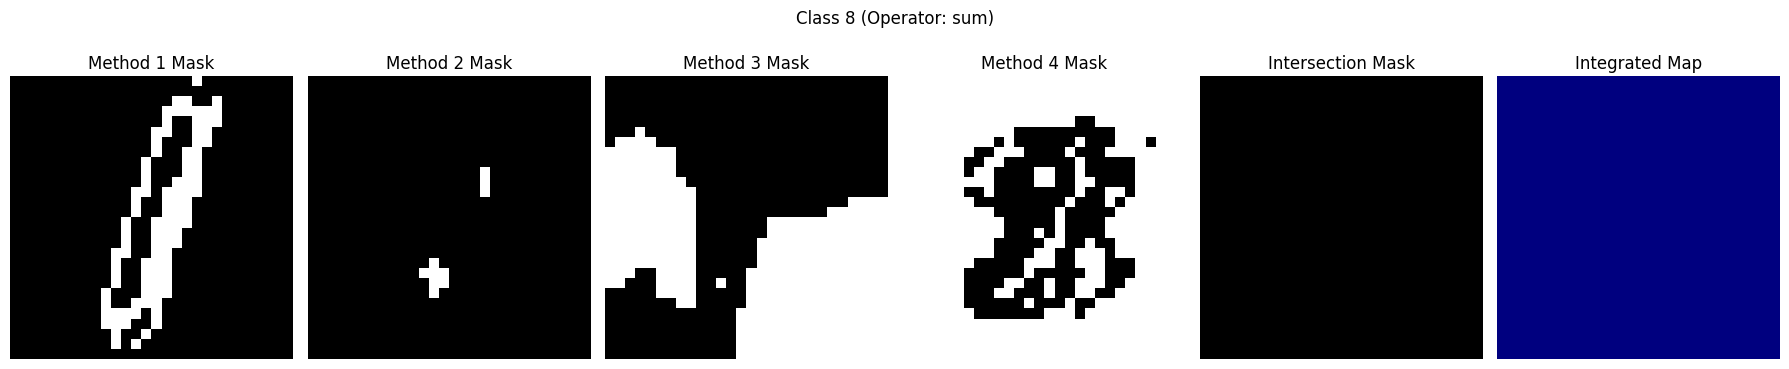

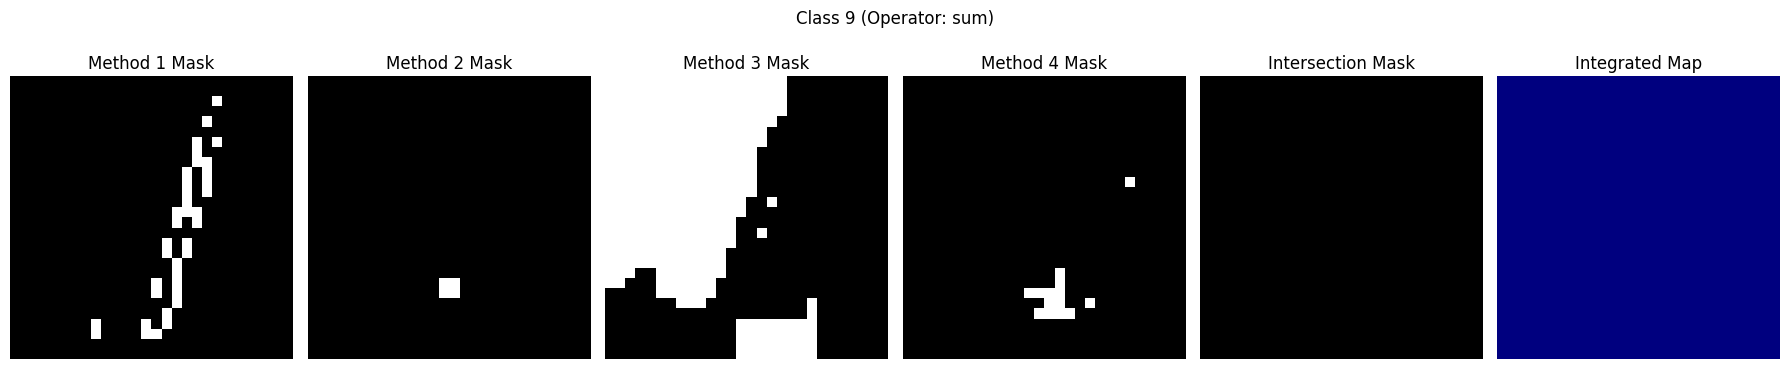

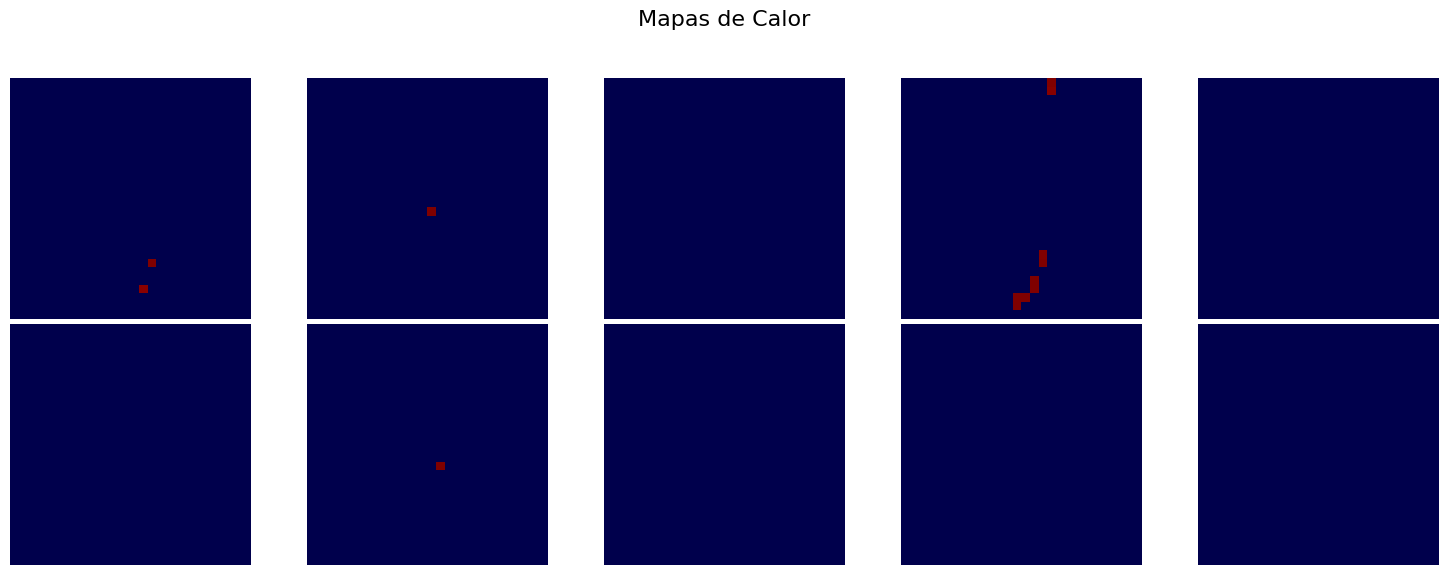

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 6
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 1.0, Min: 0.0
Mapa 1: Max: 1.0, Min: 0.0
Mapa 2: Max: 0.0, Min: 0.0
Mapa 3: Max: 1.0, Min: 0.0
Mapa 4: Max: 0.0, Min: 0.0
Mapa 5: Max: 0.0, Min: 0.0
Mapa 6: Max: 1.0, Min: 0.0
Mapa 7: Max: 0.0, Min: 0.0
Mapa 8: Max: 0.0, Min: 0.0
Mapa 9: Max: 0.0, Min: 0.0
Cantidad de rasgos mayores que 0.85: 1
Indices mayores que 0.85: [434]
Suma clase objetivo: 1.0
Suma de otras clases: 0.0
IFI calculado: 9.0
Total classes: 10


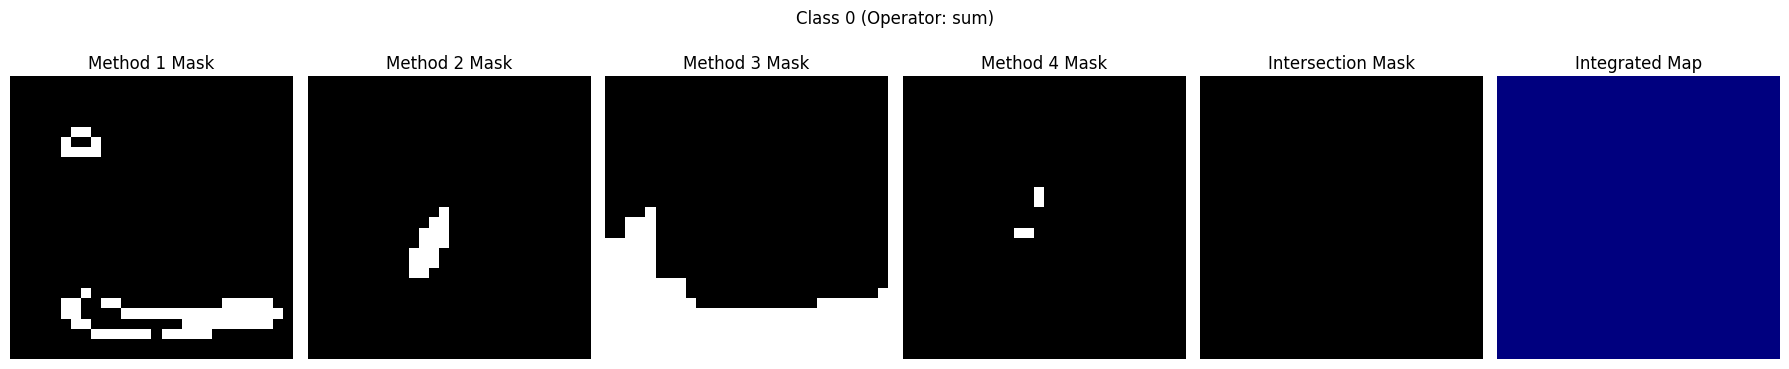

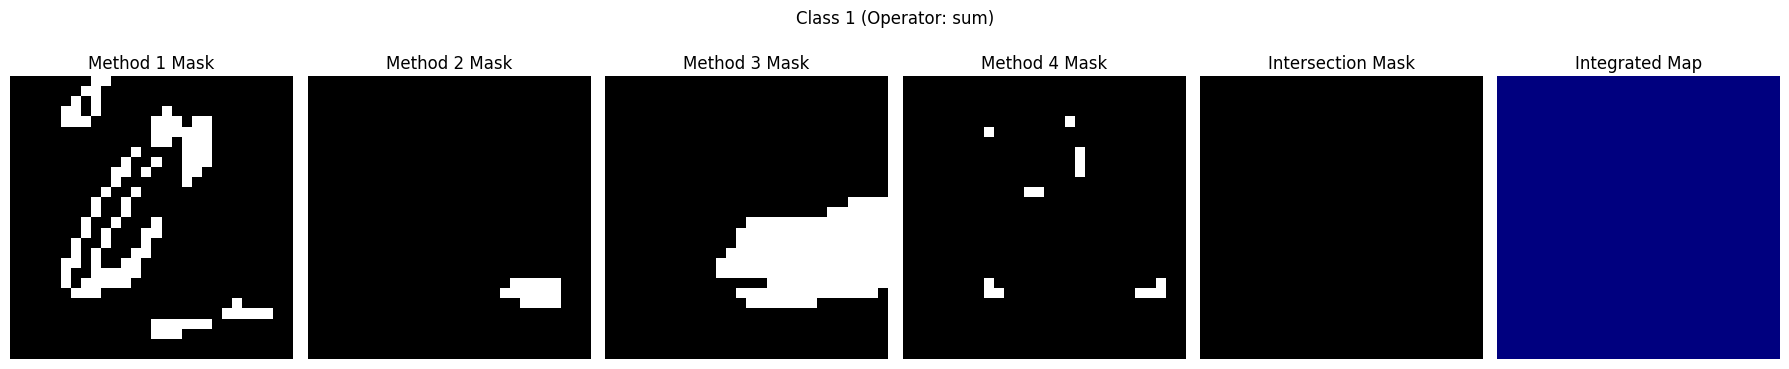

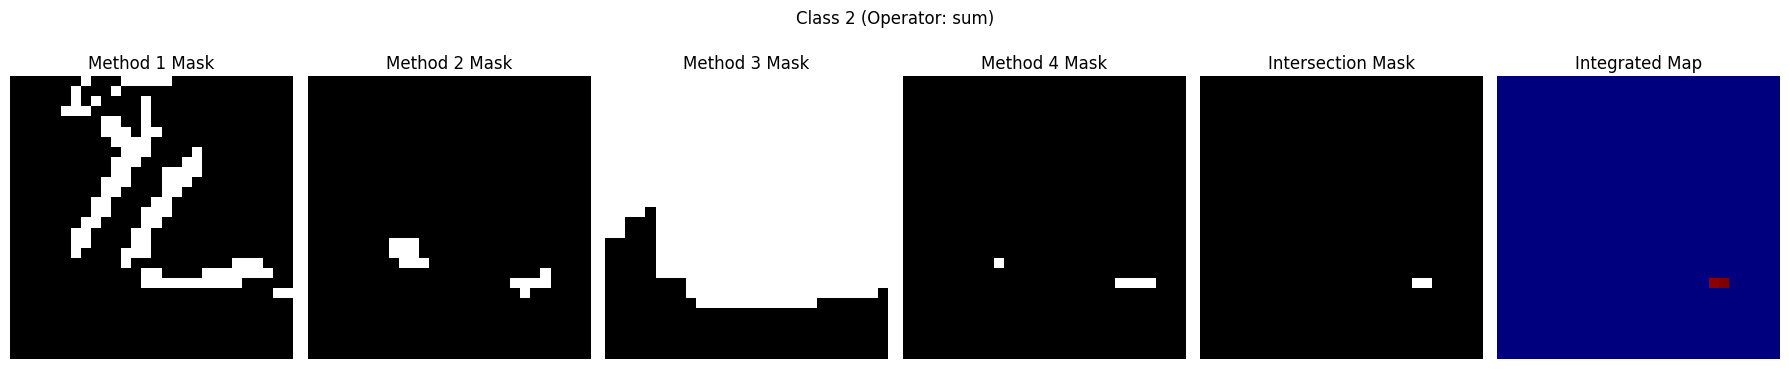

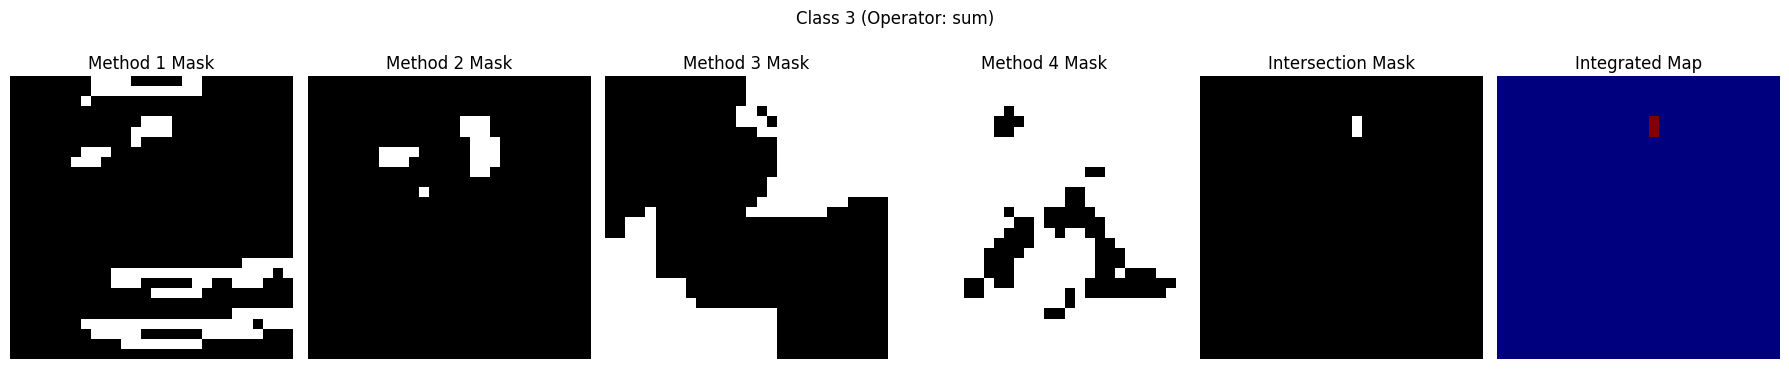

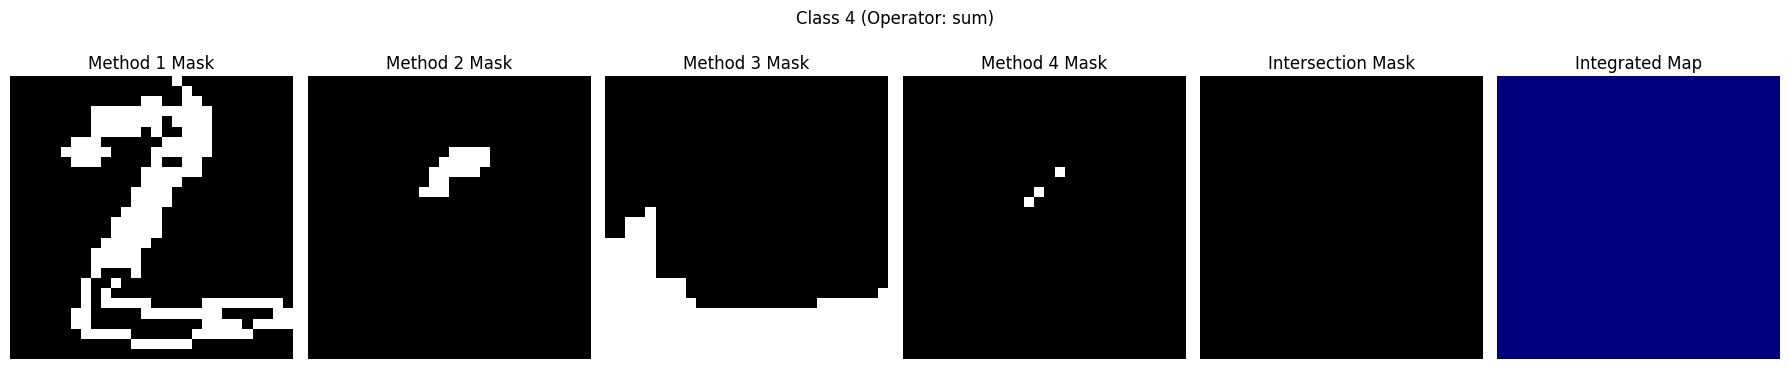

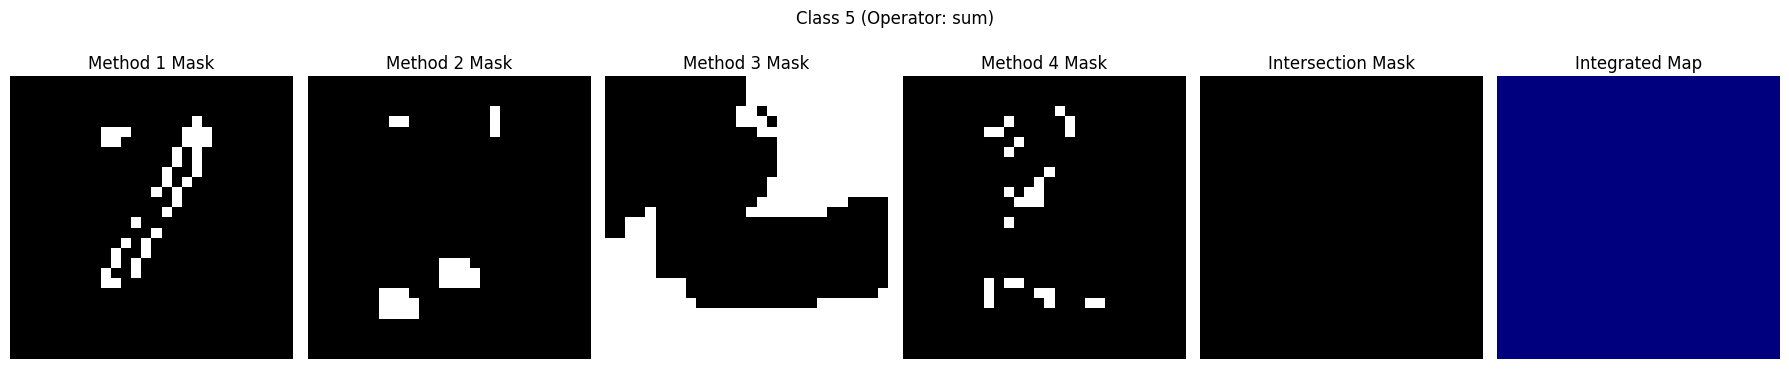

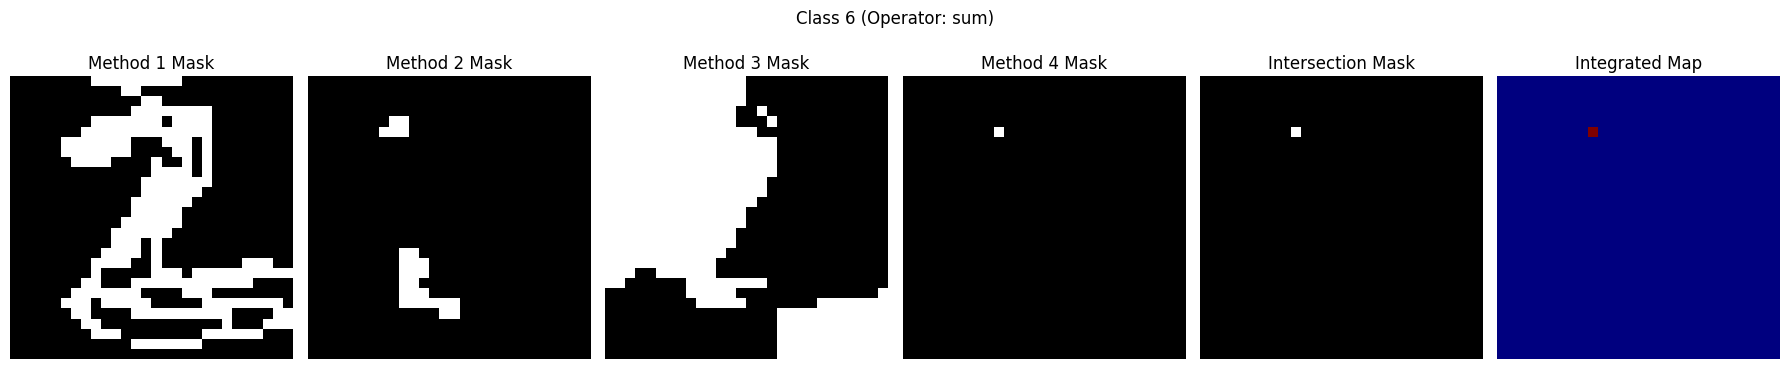

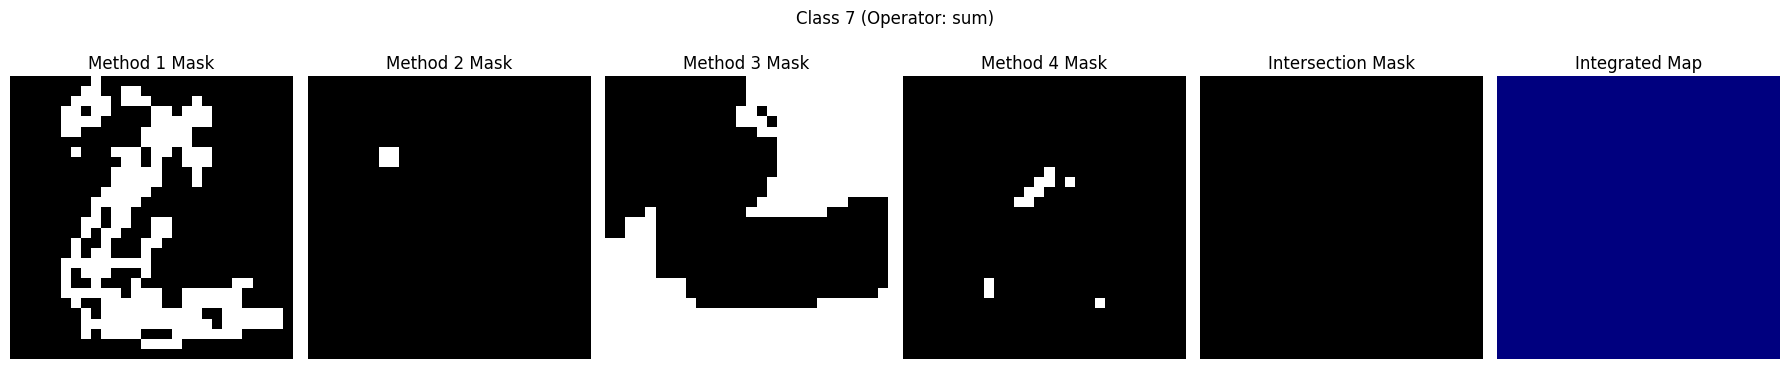

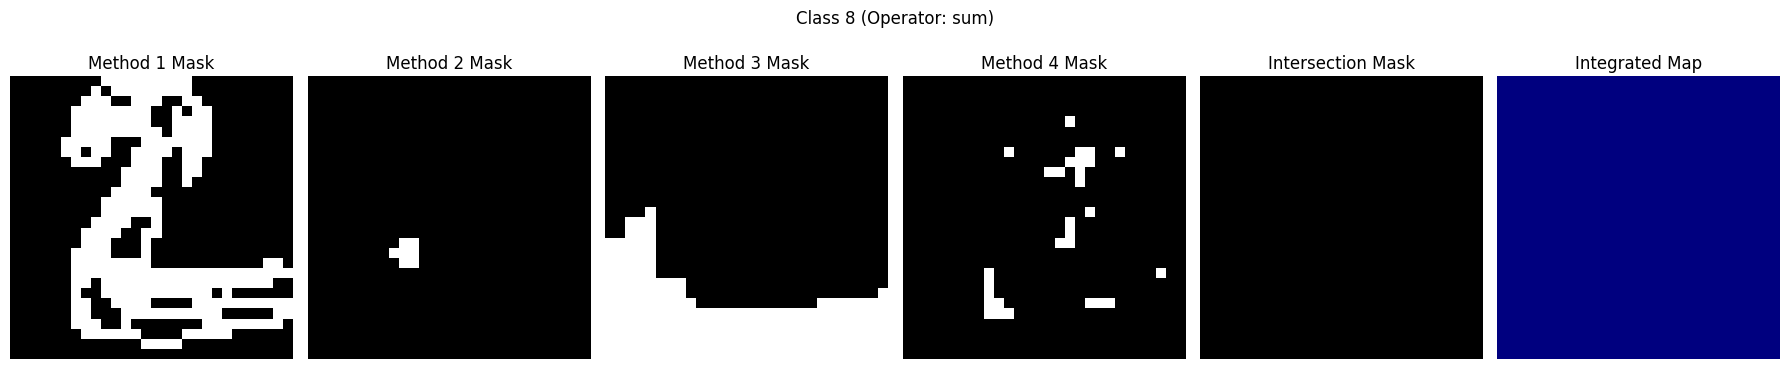

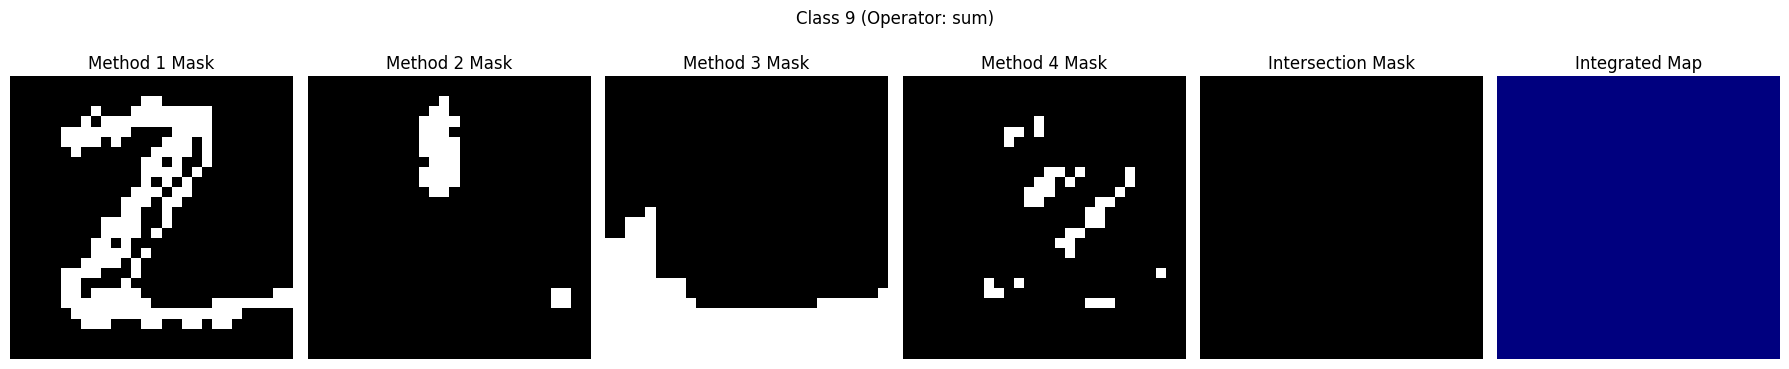

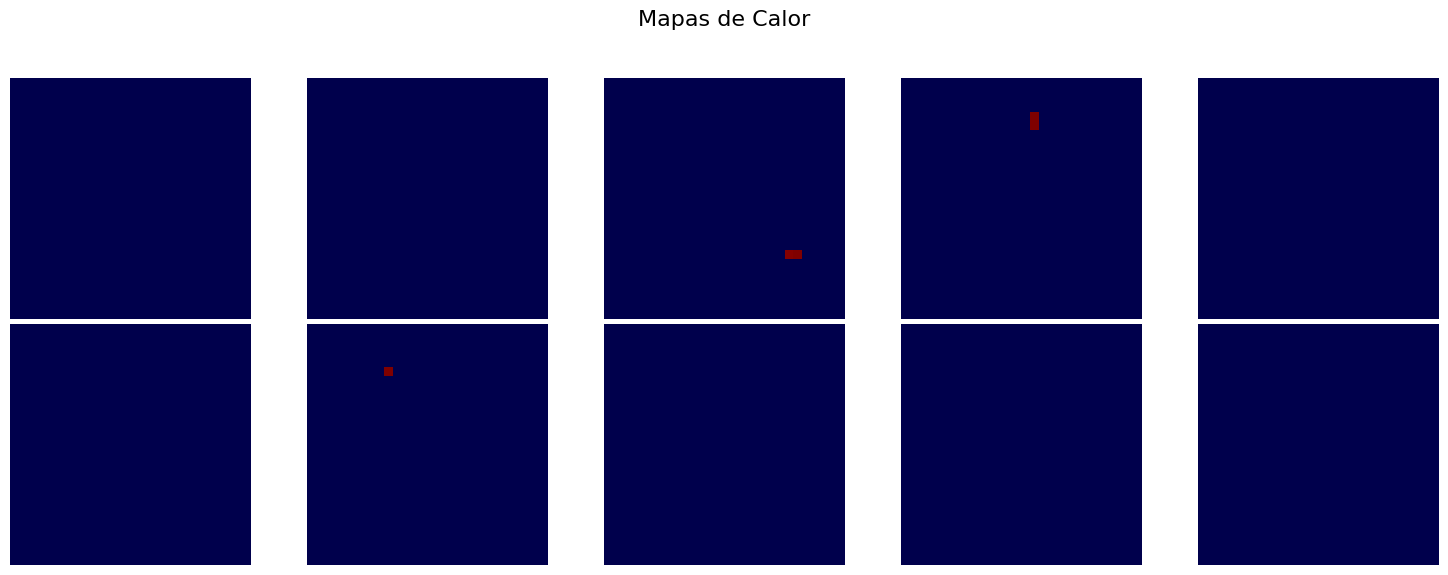

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 7
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 0.0, Min: 0.0
Mapa 1: Max: 0.0, Min: 0.0
Mapa 2: Max: 1.0, Min: 0.0
Mapa 3: Max: 1.0, Min: 0.0
Mapa 4: Max: 0.0, Min: 0.0
Mapa 5: Max: 0.0, Min: 0.0
Mapa 6: Max: 1.0, Min: 0.0
Mapa 7: Max: 0.0, Min: 0.0
Mapa 8: Max: 0.0, Min: 0.0
Mapa 9: Max: 0.0, Min: 0.0
Cantidad de rasgos mayores que 0.85: 2
Indices mayores que 0.85: [581 582]
Suma clase objetivo: 1.984451000302299
Suma de otras clases: 0.0
IFI calculado: 17.860059002720693
Total classes: 10


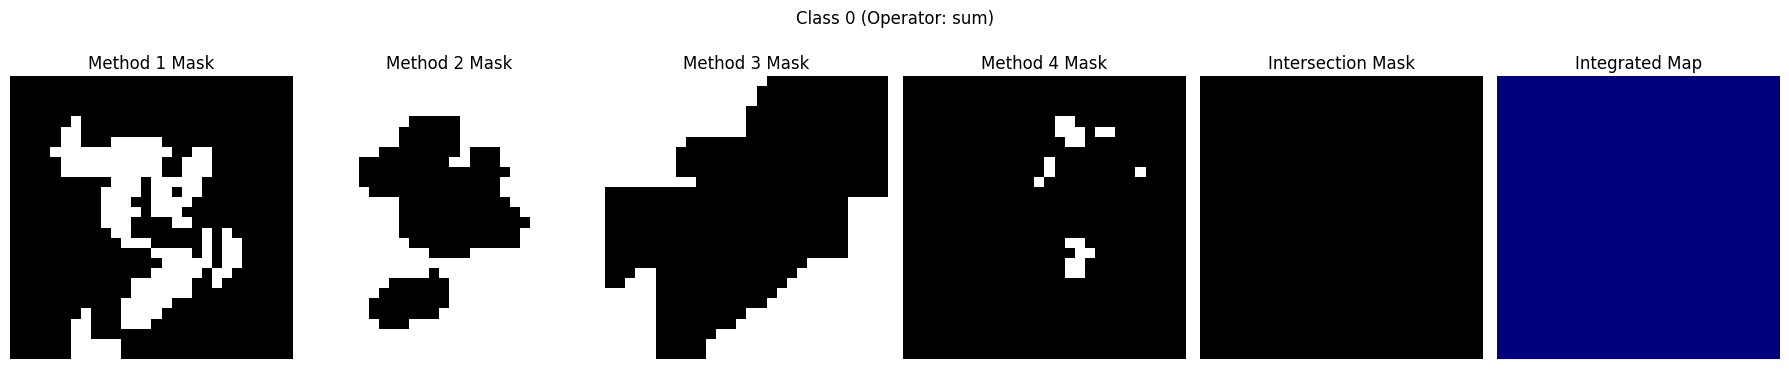

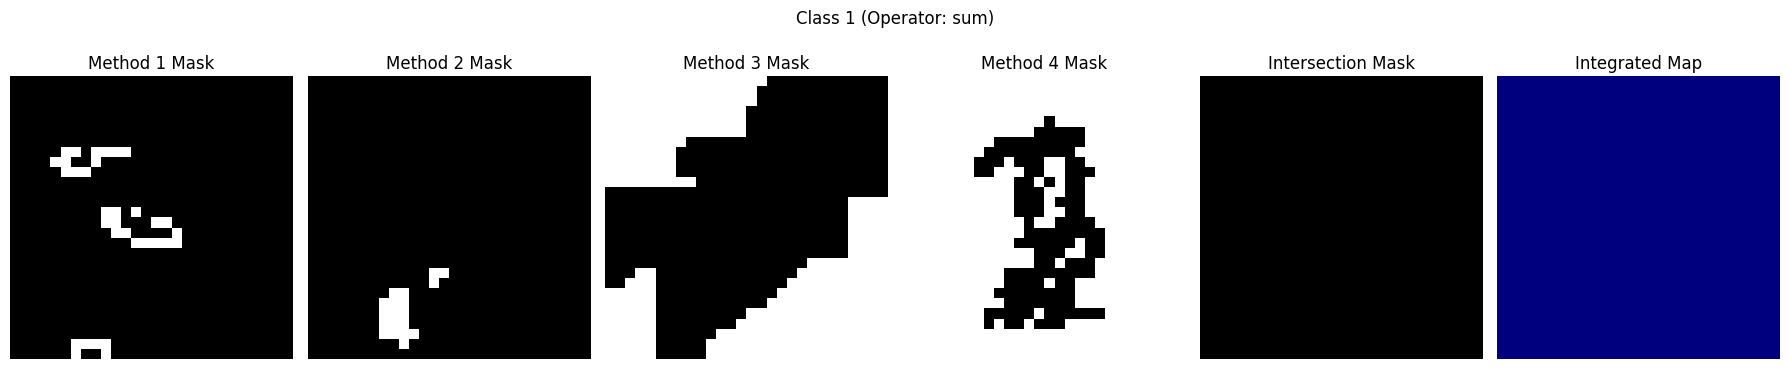

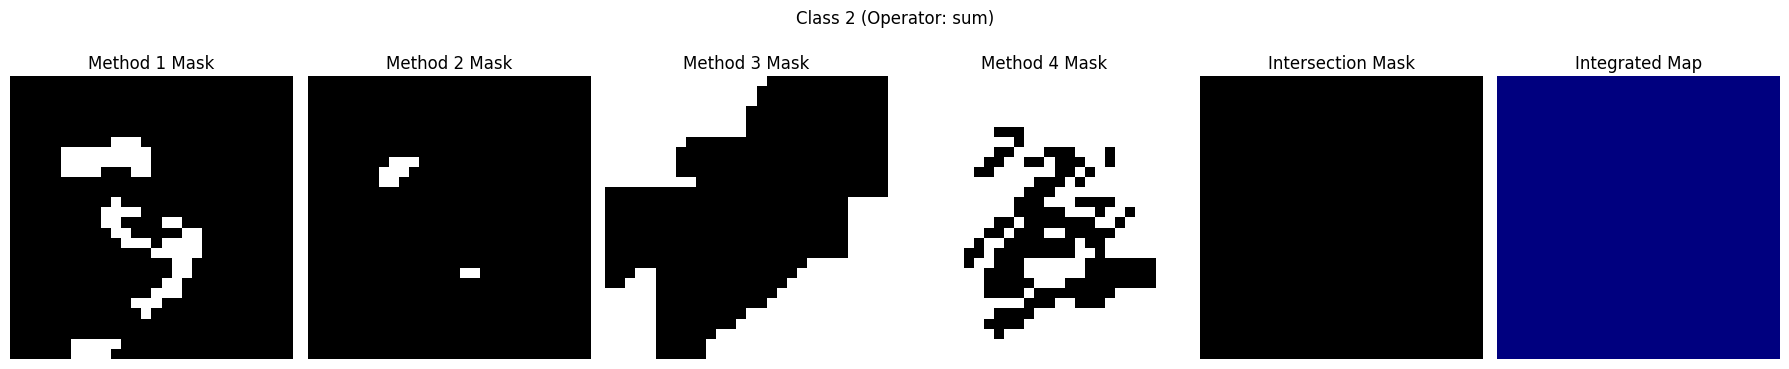

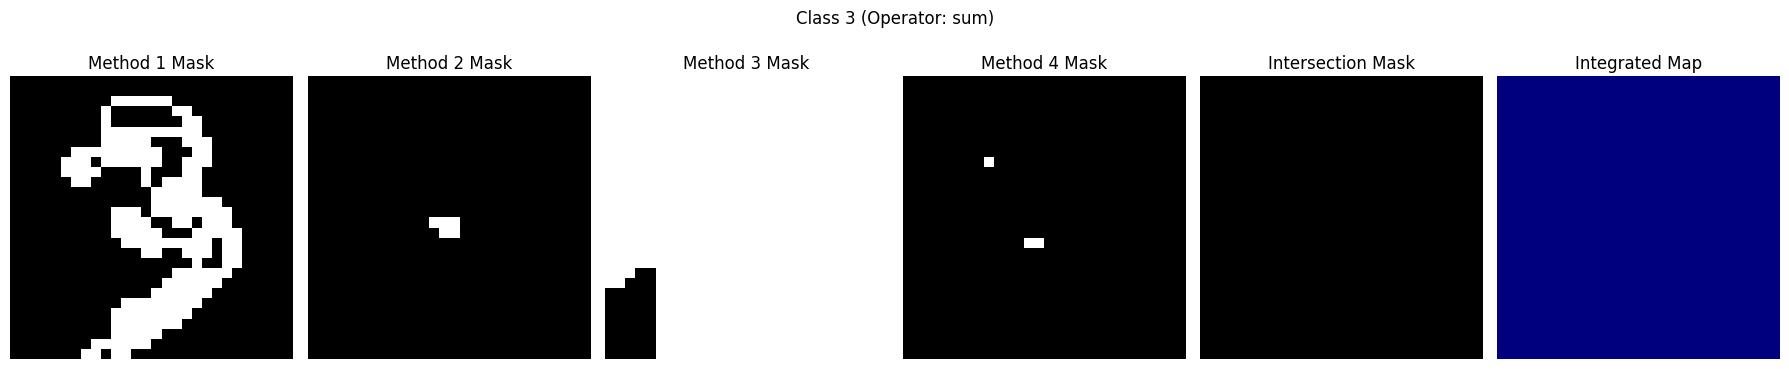

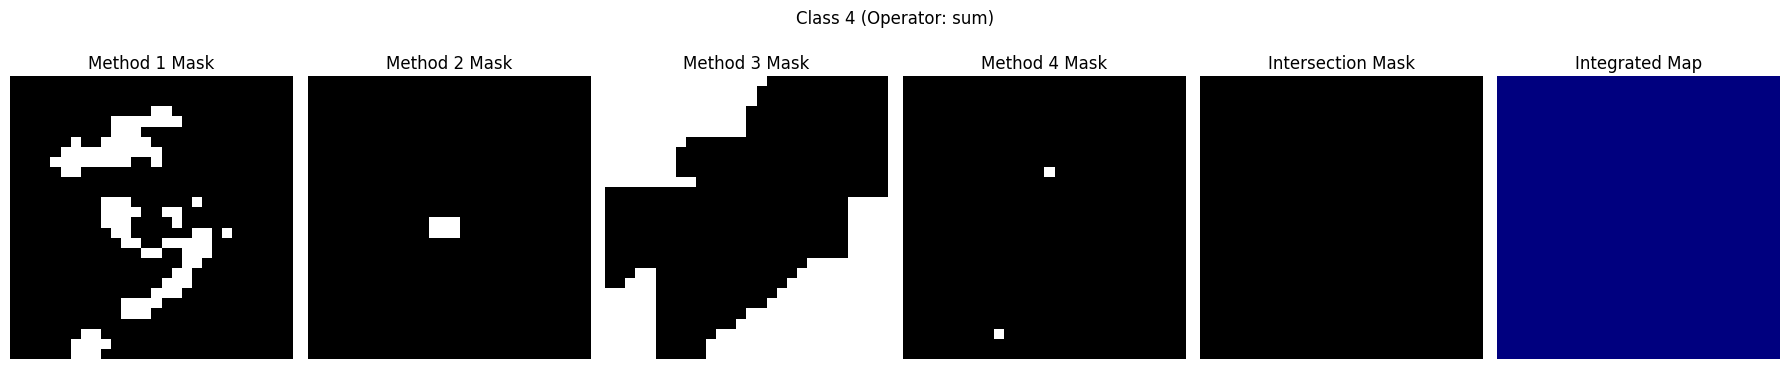

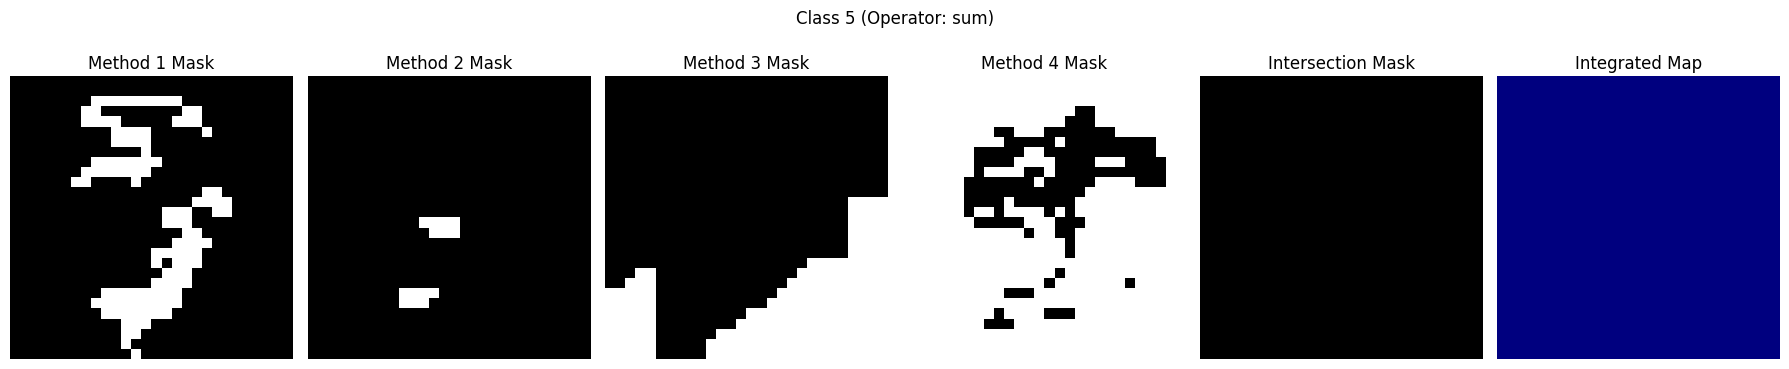

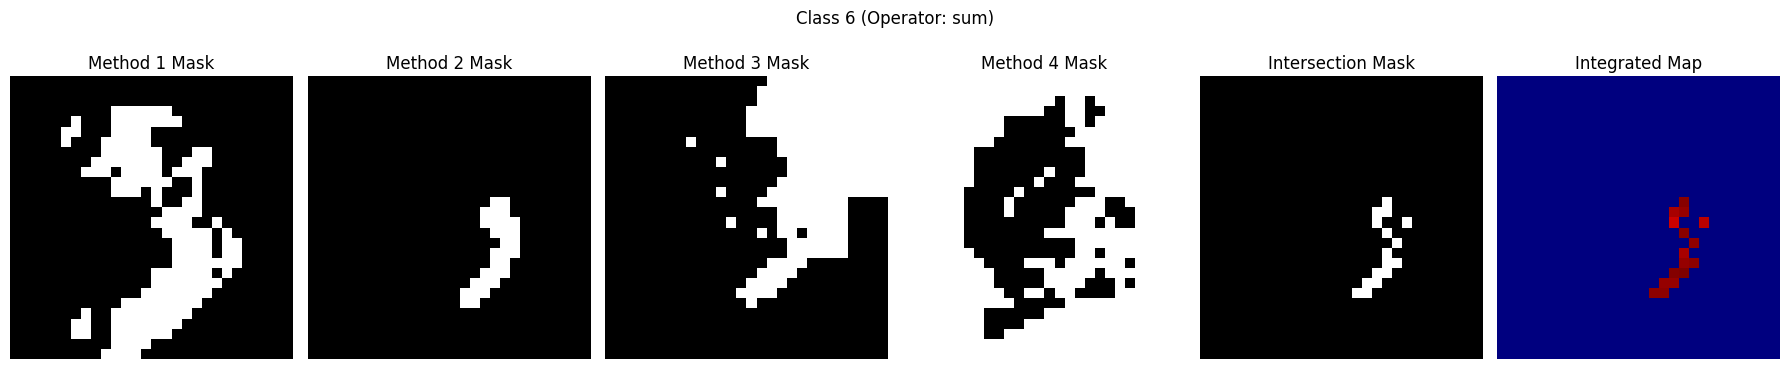

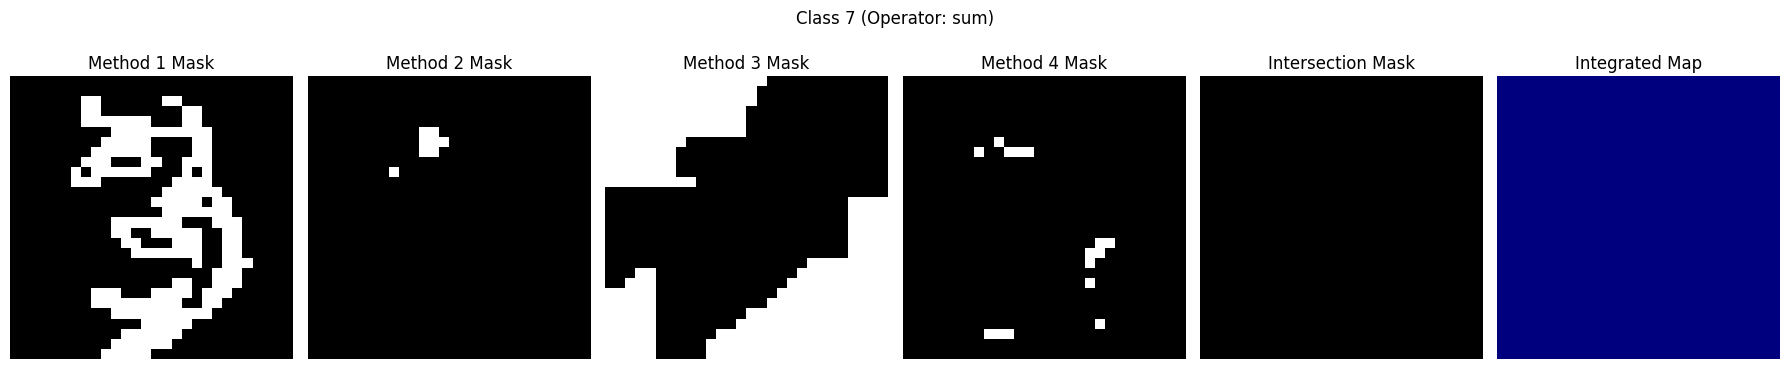

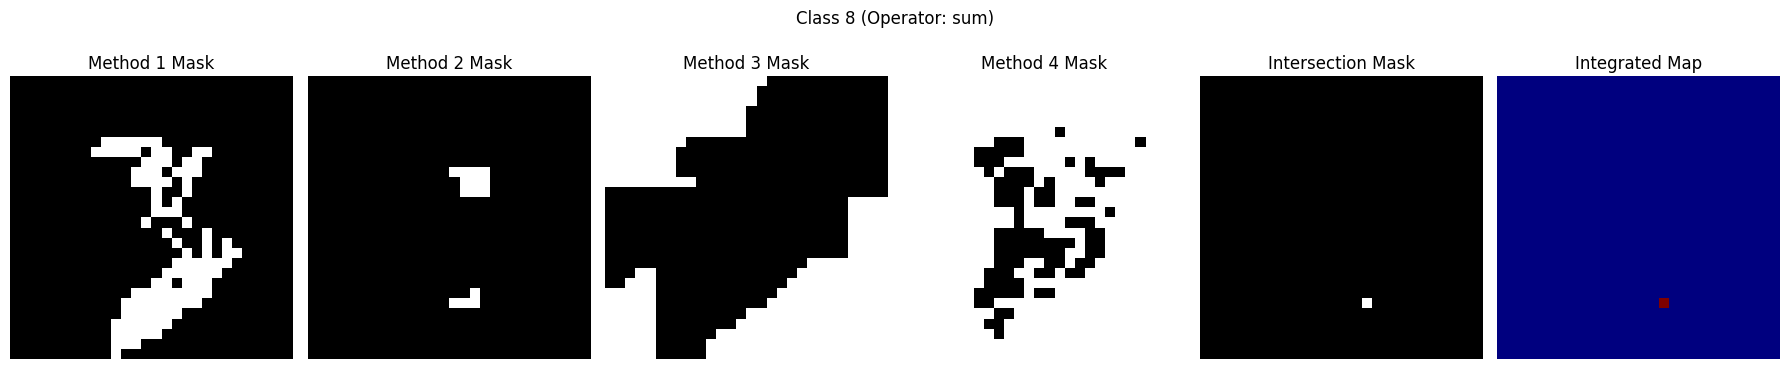

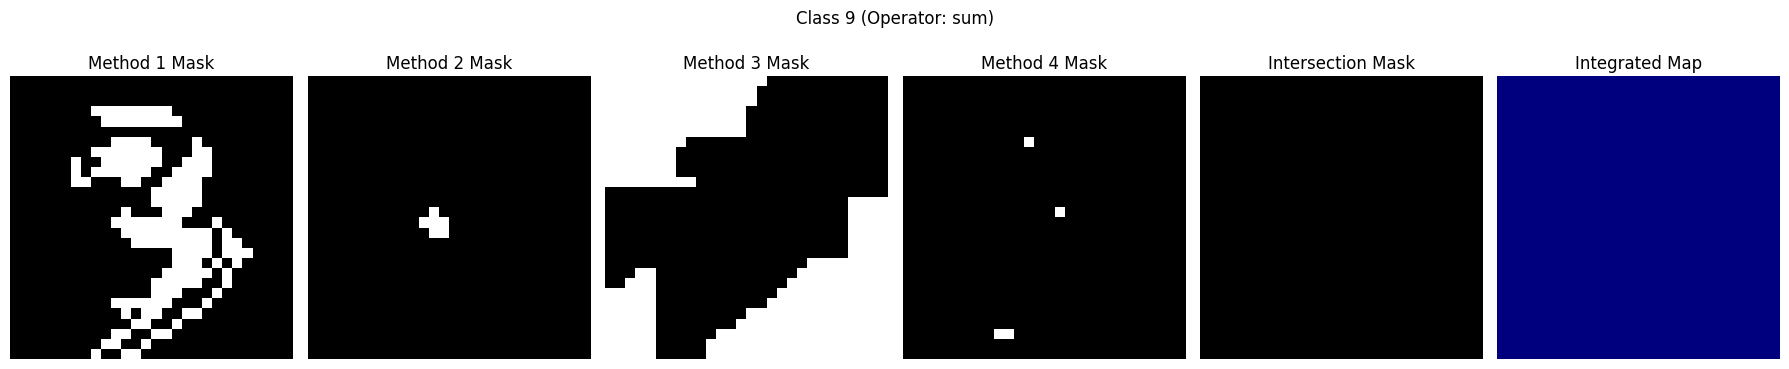

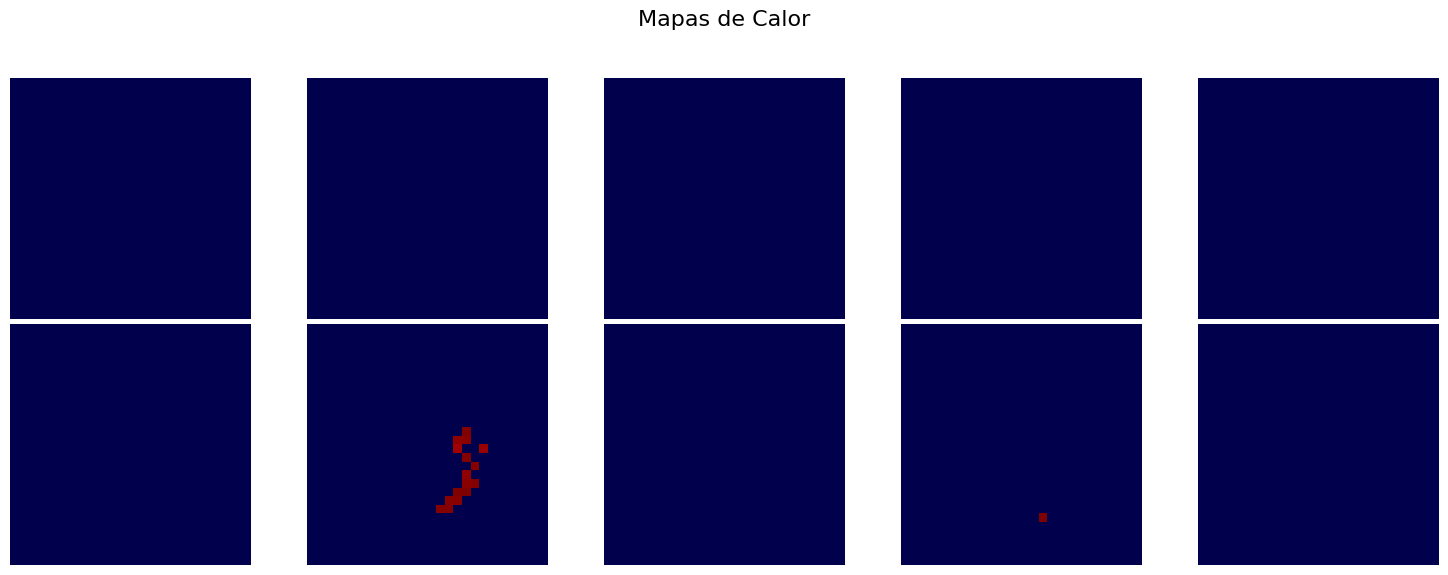

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 8
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 0.0, Min: 0.0
Mapa 1: Max: 0.0, Min: 0.0
Mapa 2: Max: 0.0, Min: 0.0
Mapa 3: Max: 0.0, Min: 0.0
Mapa 4: Max: 0.0, Min: 0.0
Mapa 5: Max: 0.0, Min: 0.0
Mapa 6: Max: 1.0, Min: 0.0
Mapa 7: Max: 0.0, Min: 0.0
Mapa 8: Max: 1.0, Min: 0.0
Mapa 9: Max: 0.0, Min: 0.0
Cantidad de rasgos mayores que 0.85: 0
Indices mayores que 0.85: []
Suma clase objetivo: 0.0
Suma de otras clases: 0.0
IFI calculado: 0
Total classes: 10


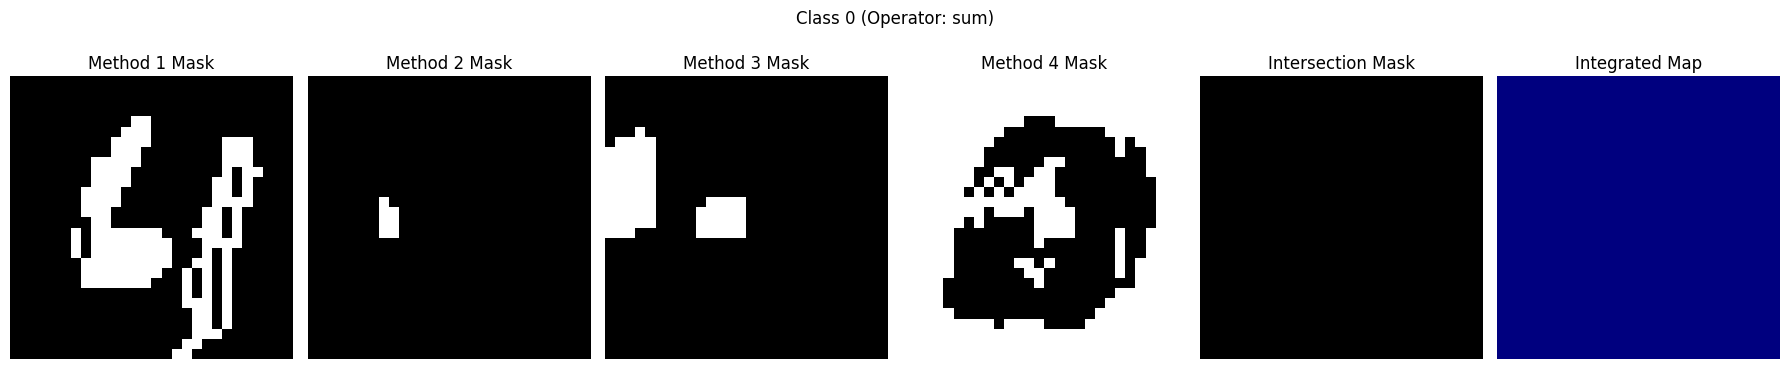

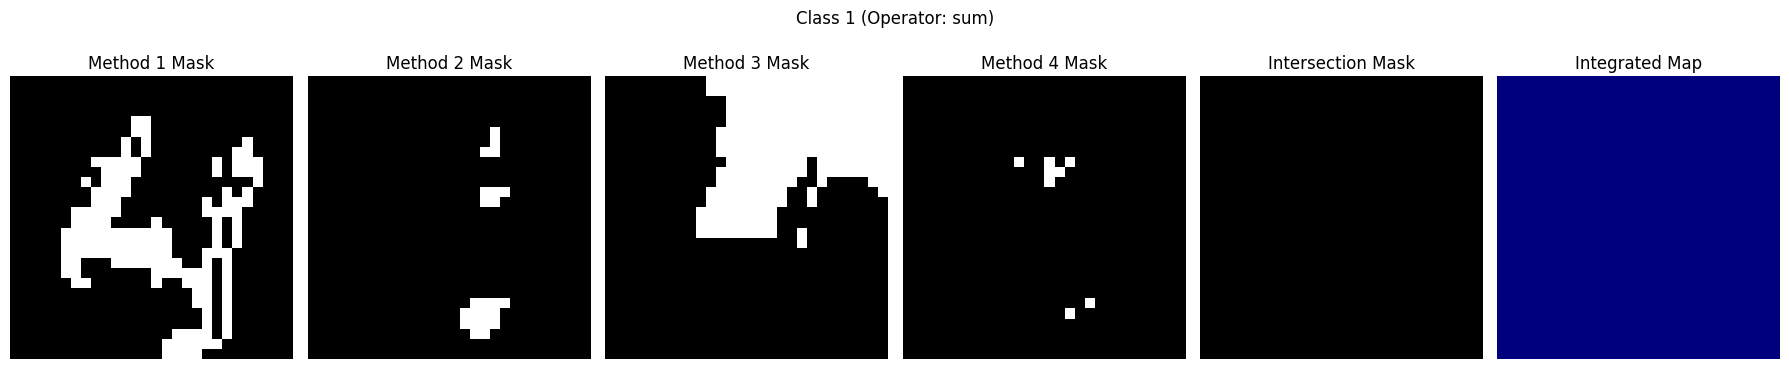

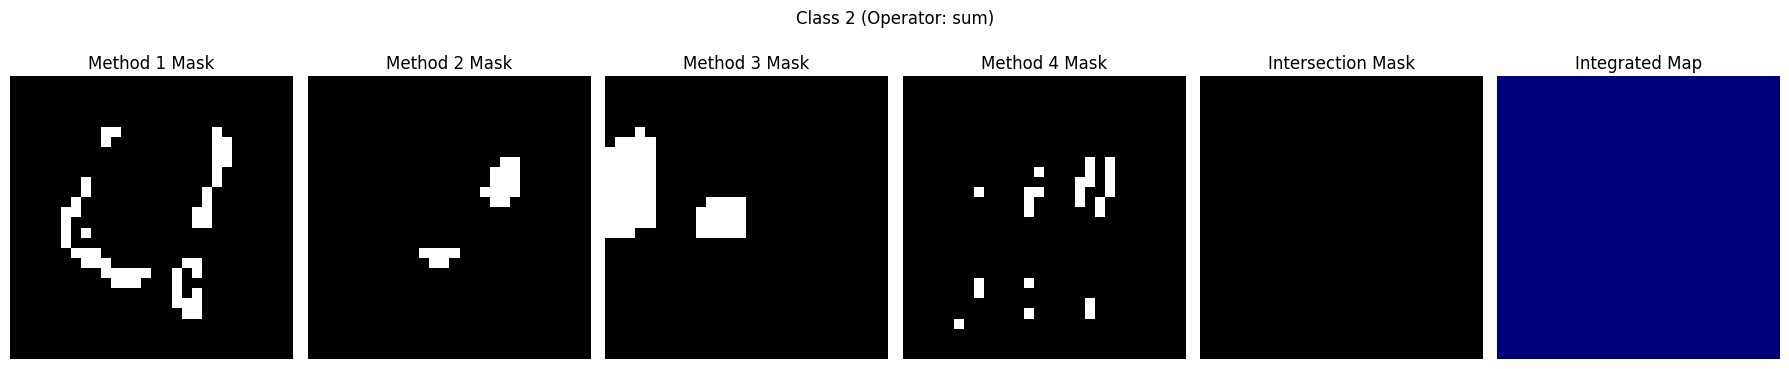

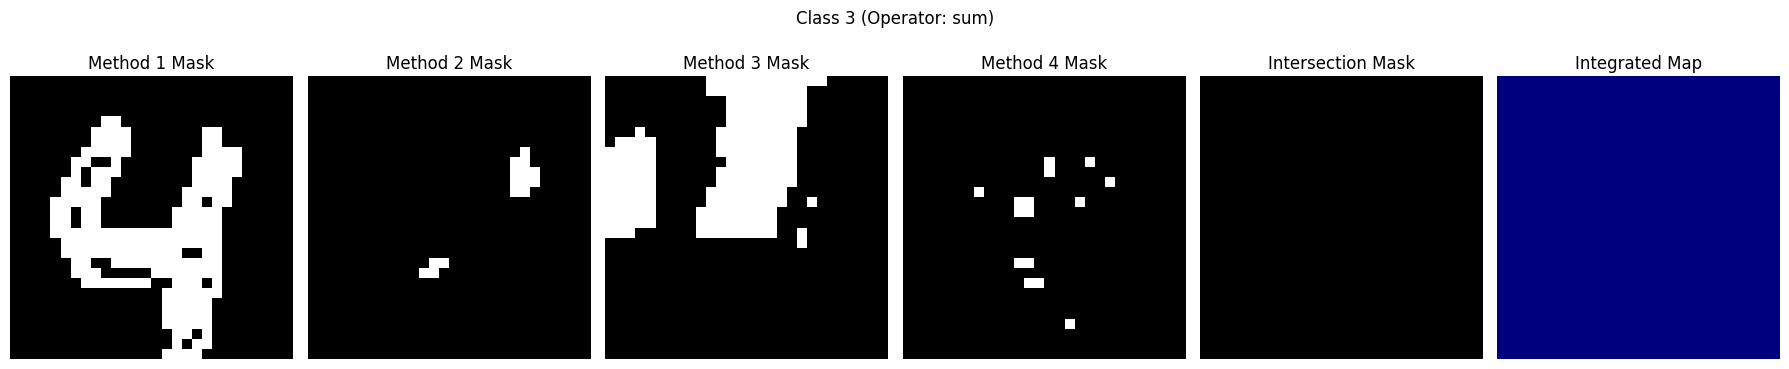

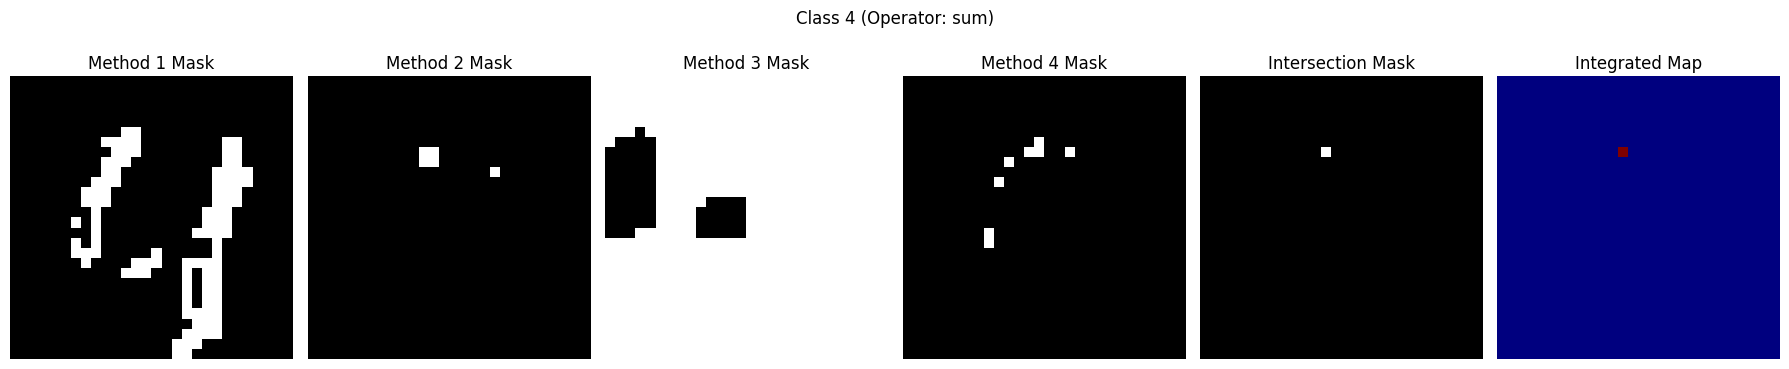

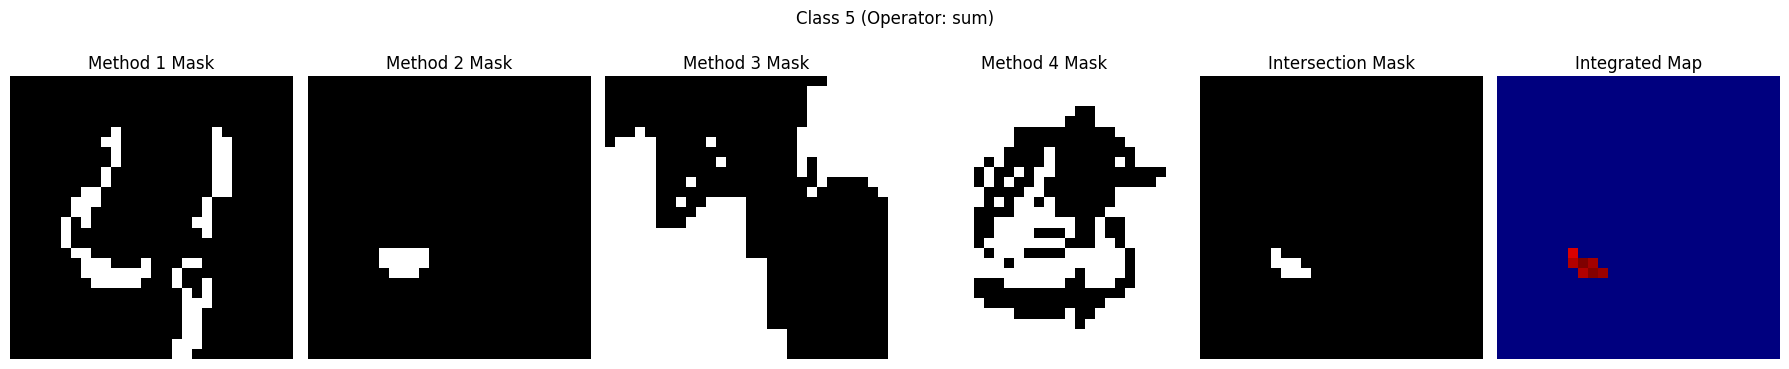

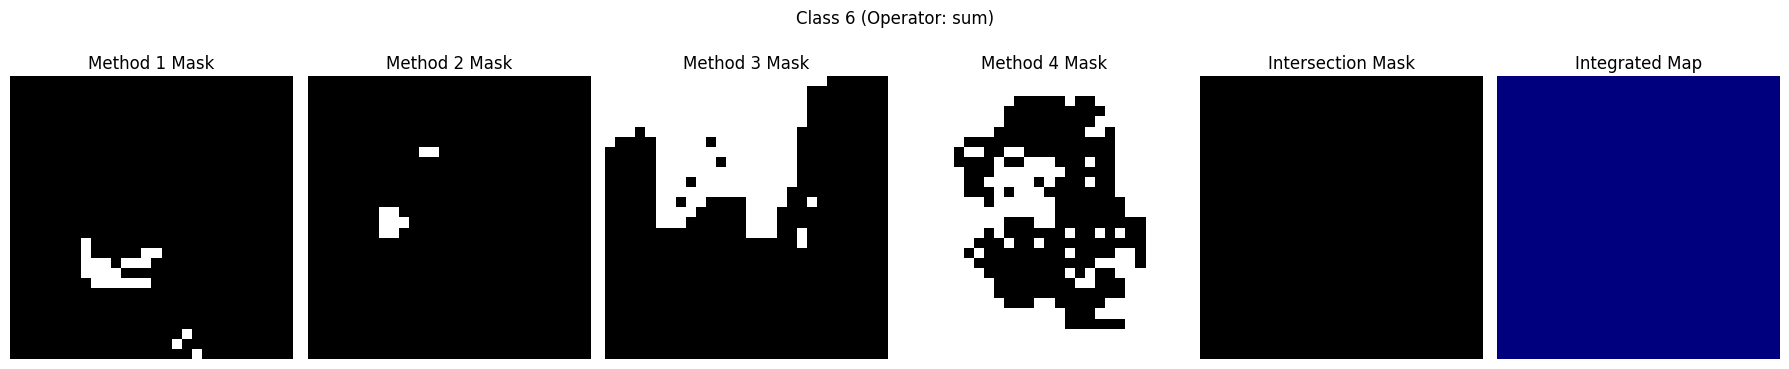

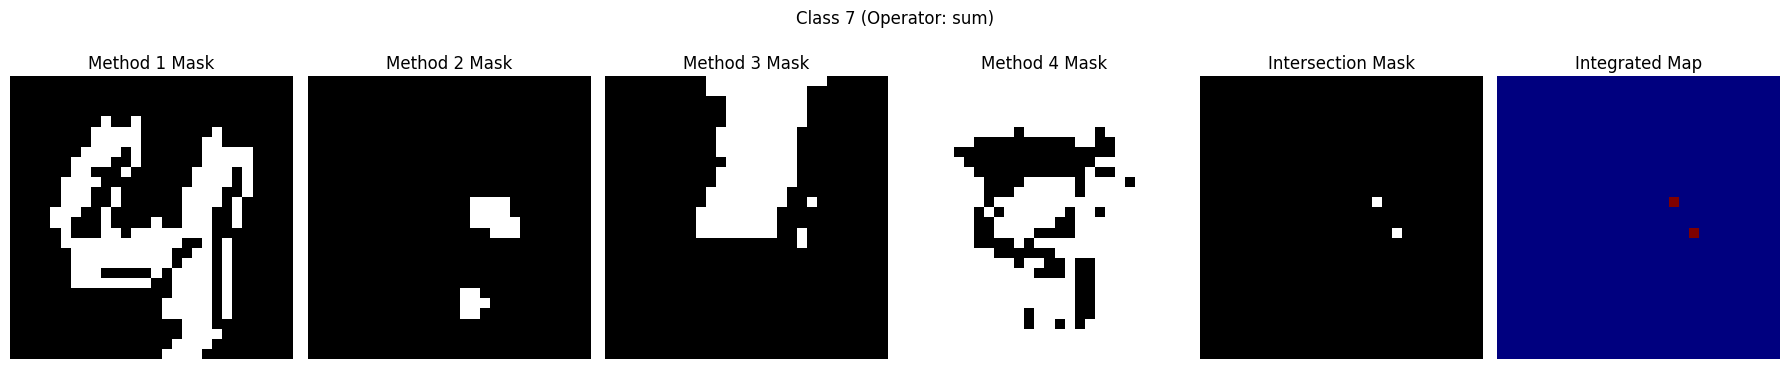

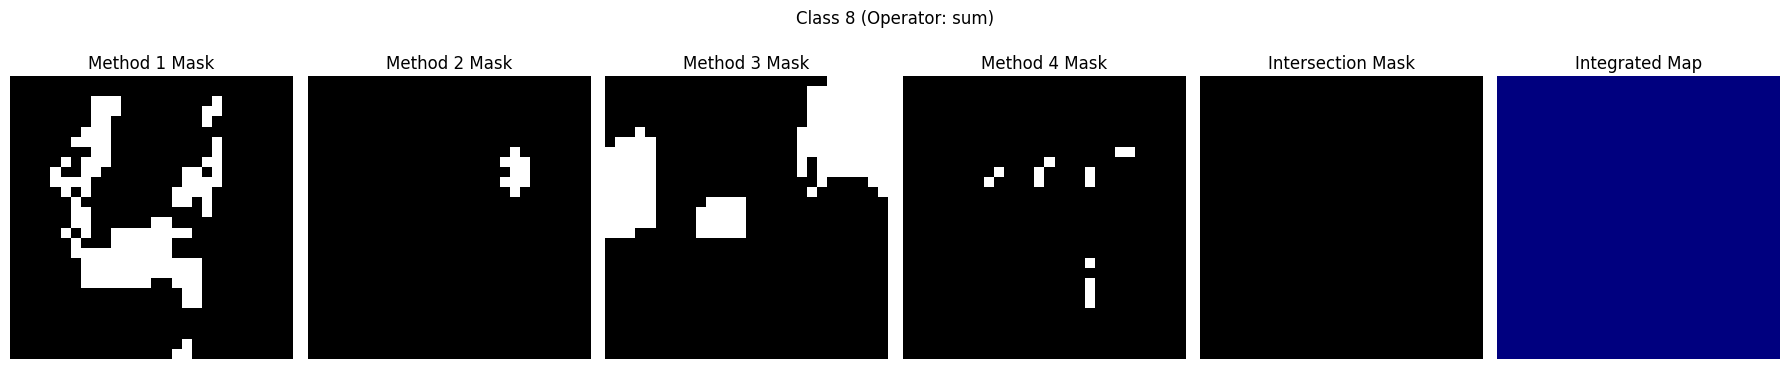

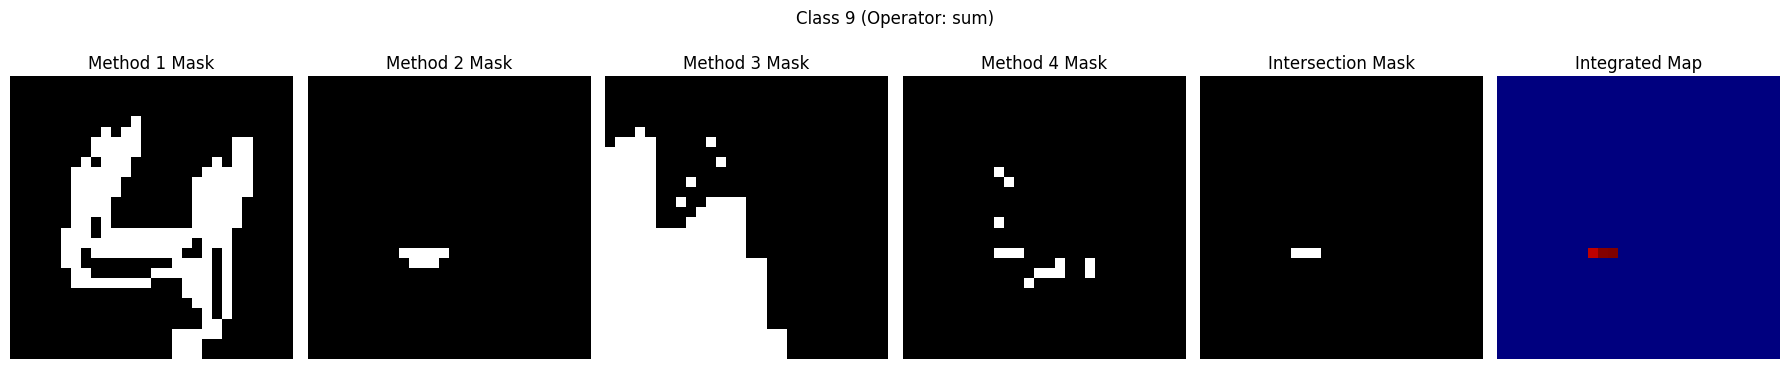

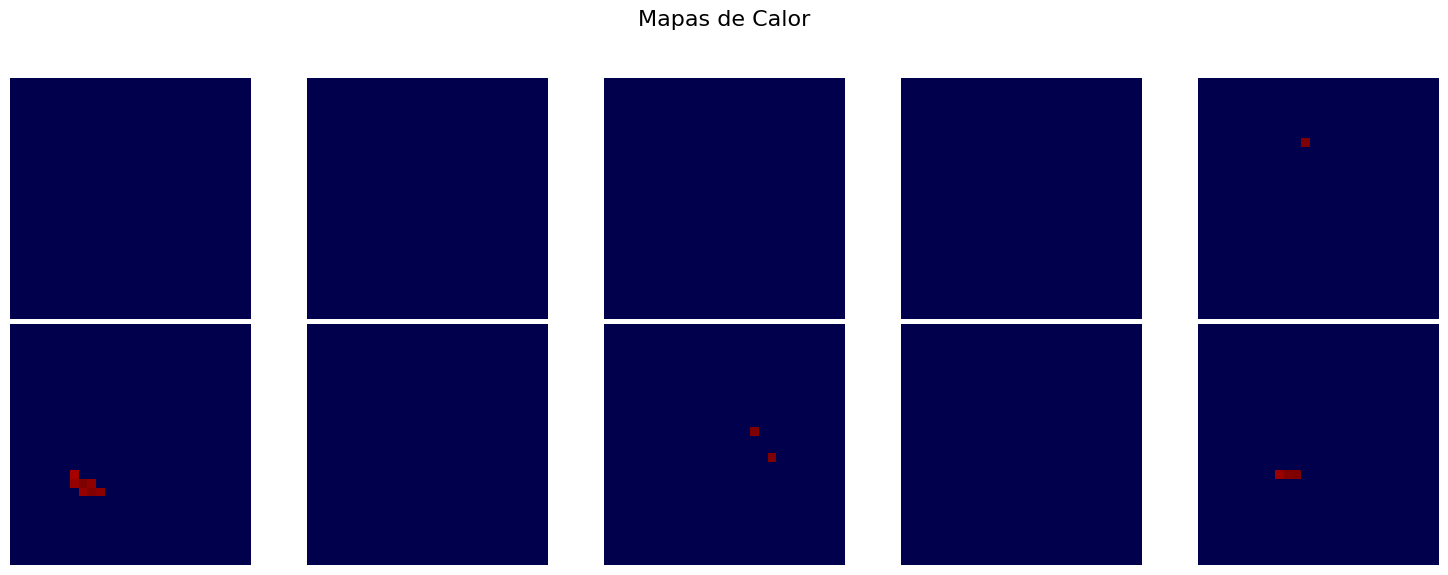

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 6
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 0.0, Min: 0.0
Mapa 1: Max: 0.0, Min: 0.0
Mapa 2: Max: 0.0, Min: 0.0
Mapa 3: Max: 0.0, Min: 0.0
Mapa 4: Max: 1.0, Min: 0.0
Mapa 5: Max: 1.0, Min: 0.0
Mapa 6: Max: 0.0, Min: 0.0
Mapa 7: Max: 1.0, Min: 0.0
Mapa 8: Max: 0.0, Min: 0.0
Mapa 9: Max: 1.0, Min: 0.0
Cantidad de rasgos mayores que 0.85: 1
Indices mayores que 0.85: [208]
Suma clase objetivo: 1.0
Suma de otras clases: 0.0
IFI calculado: 9.0
Total classes: 10


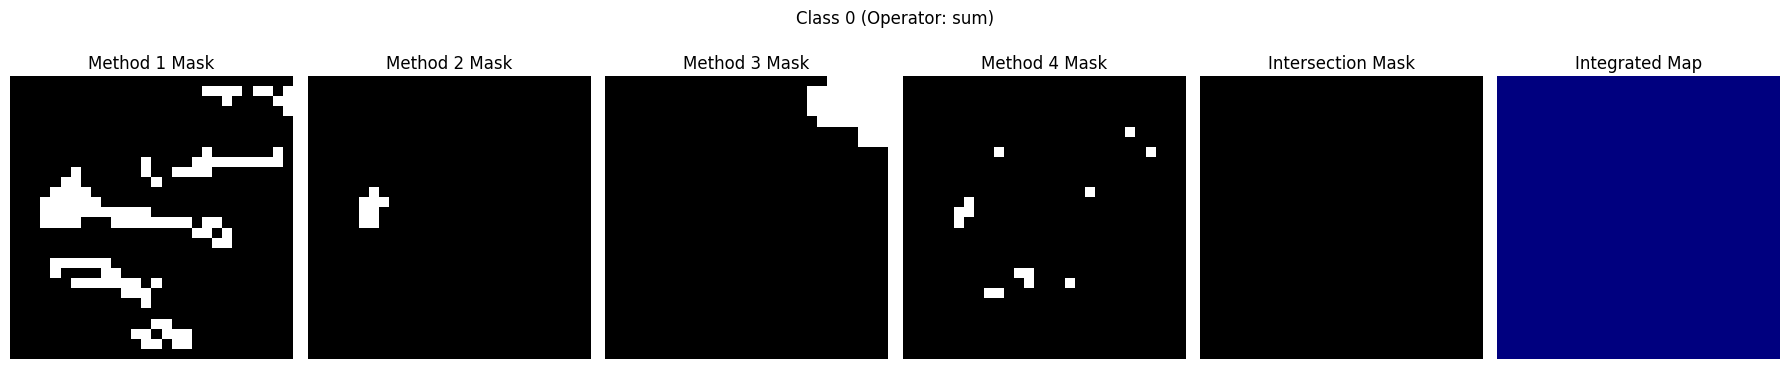

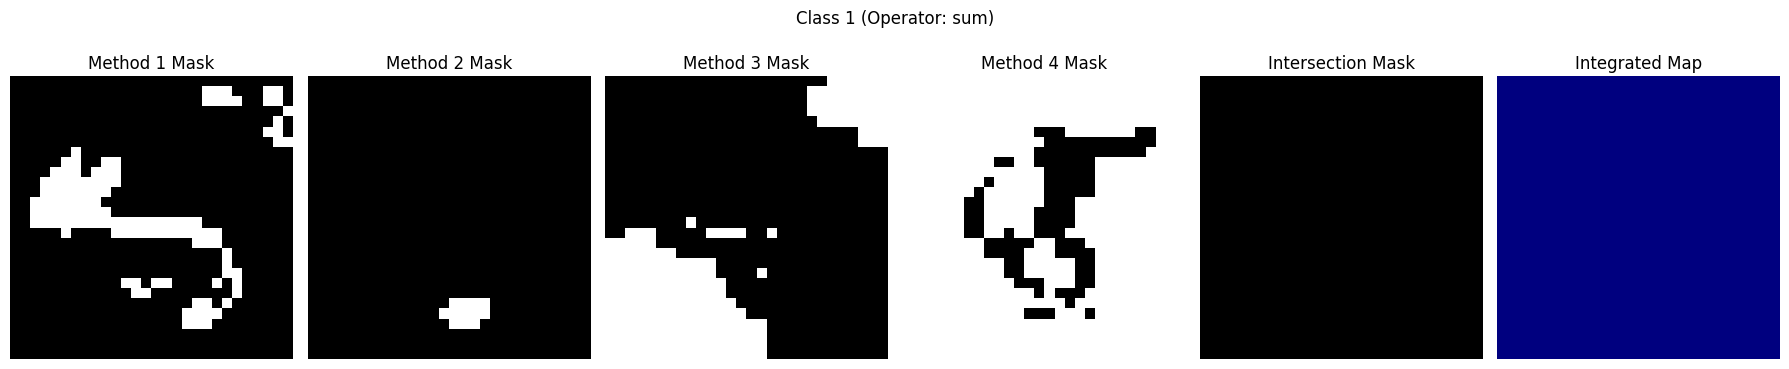

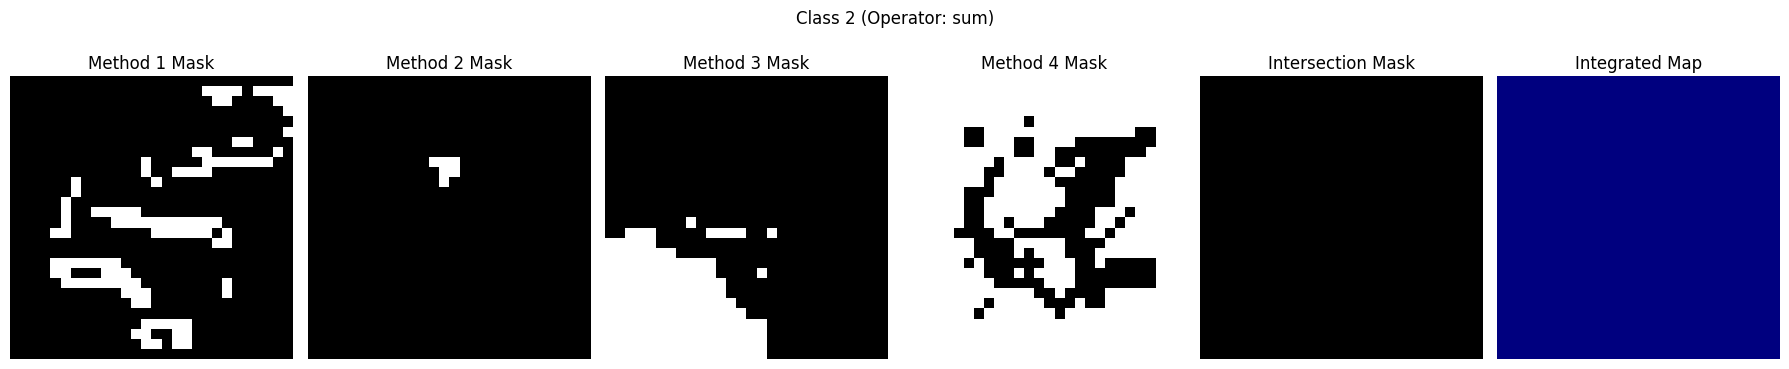

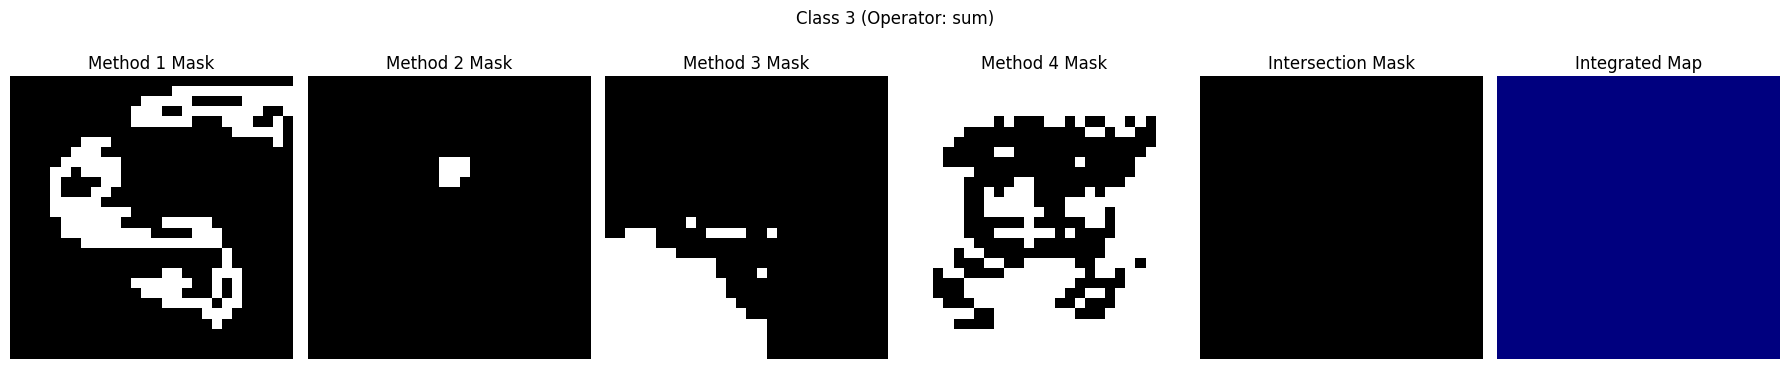

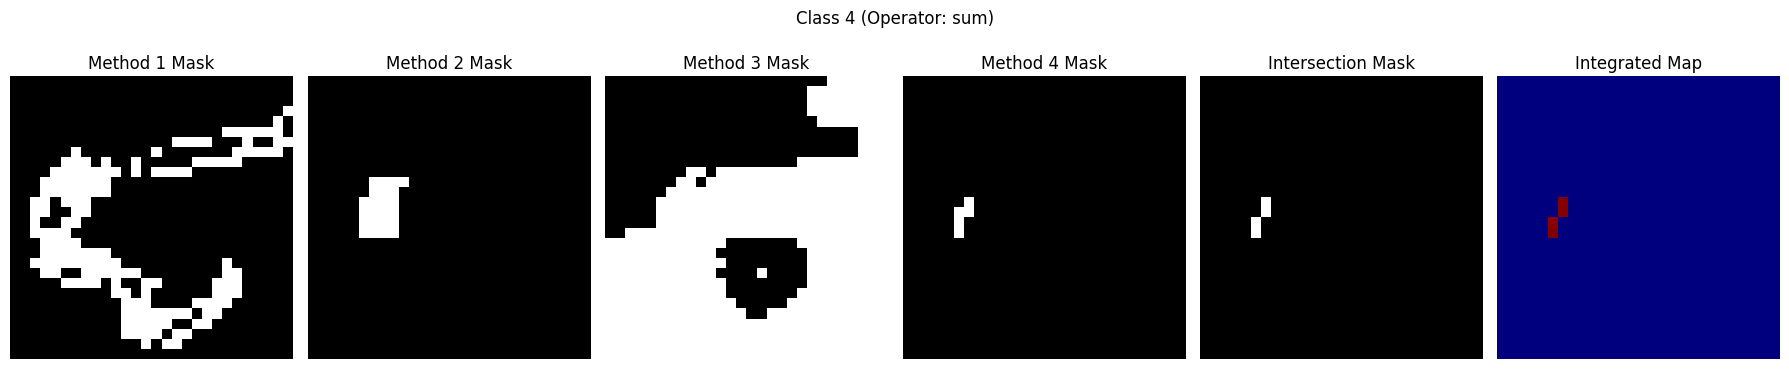

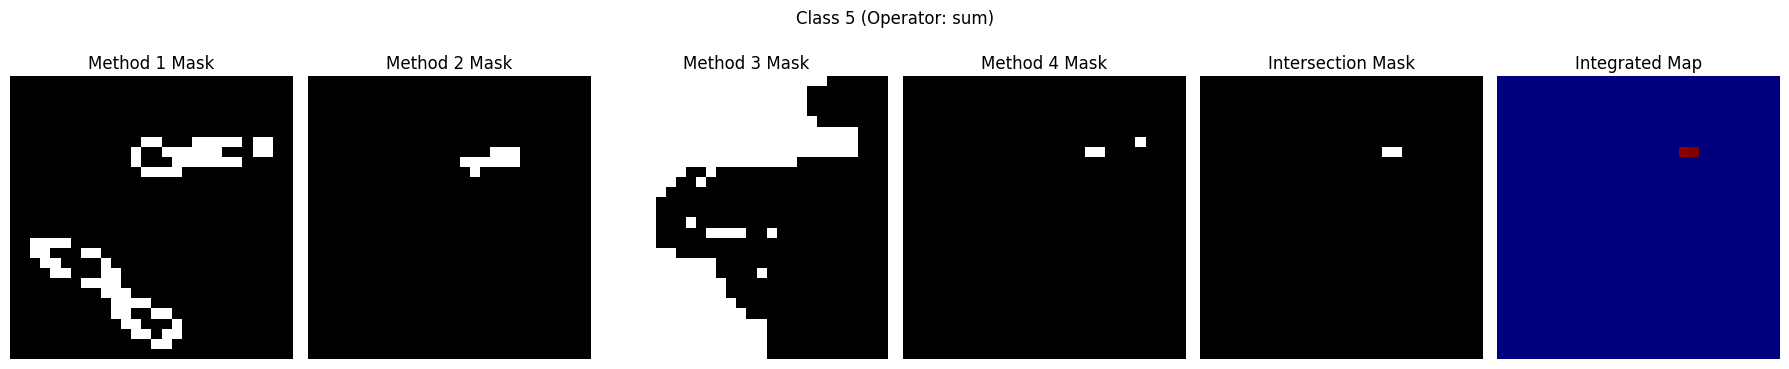

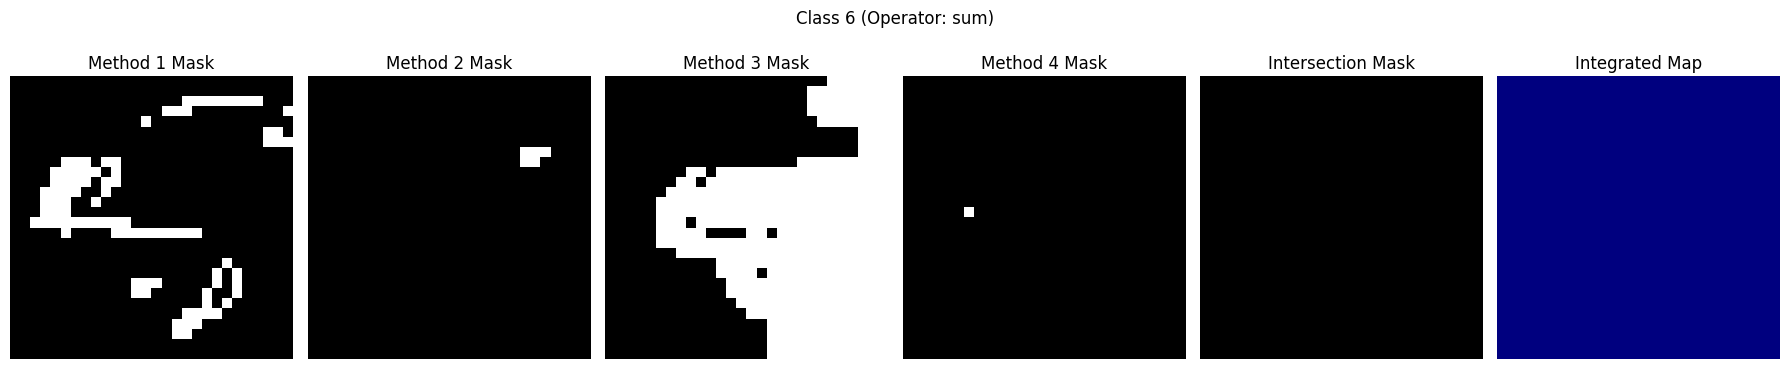

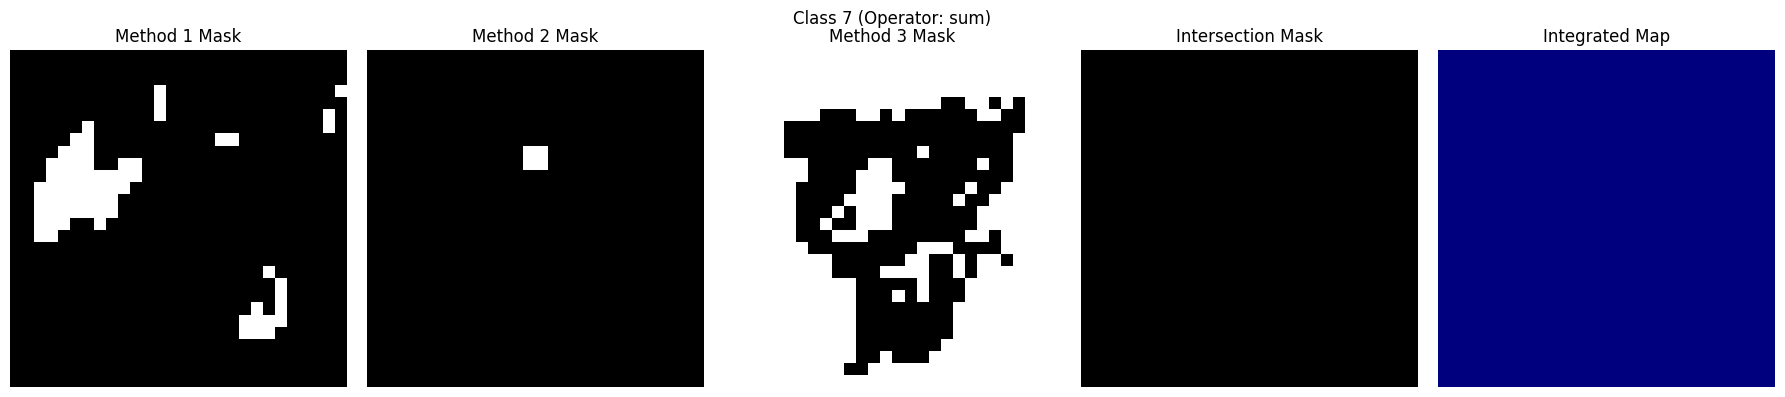

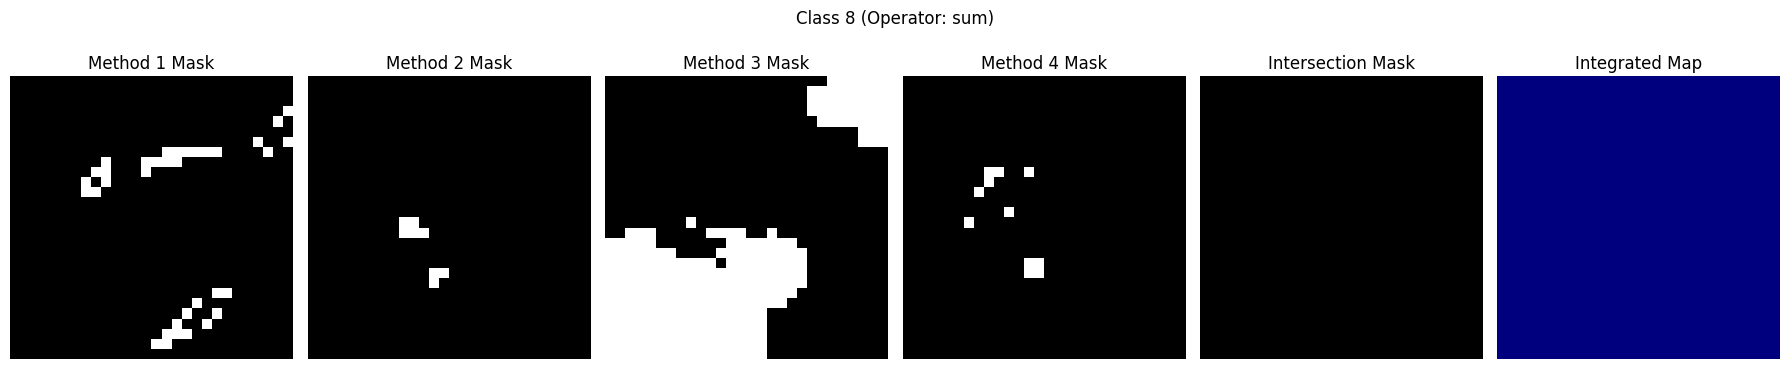

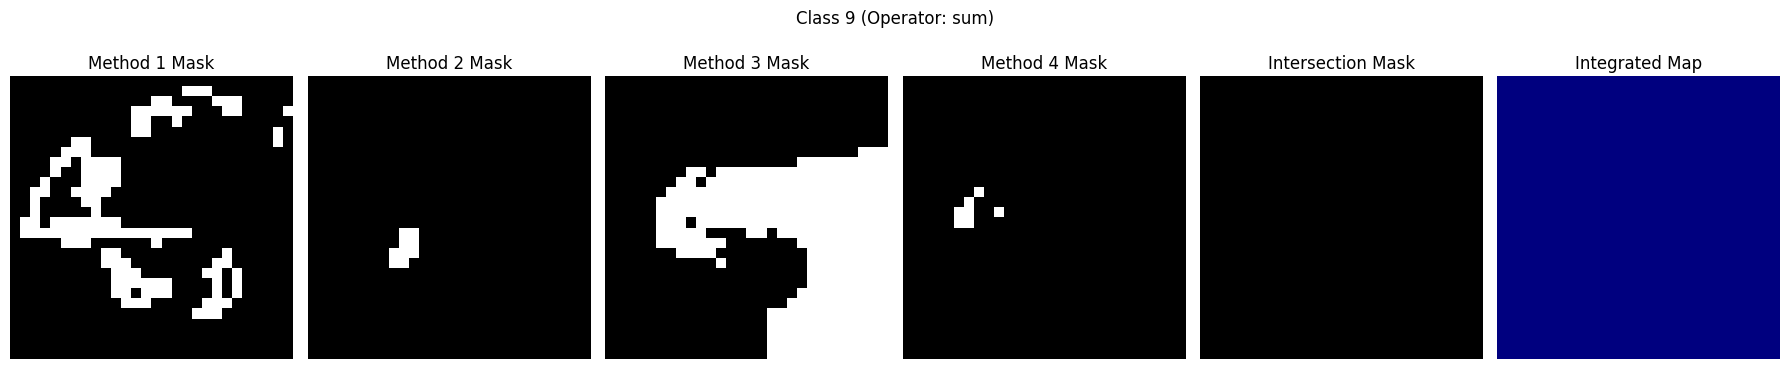

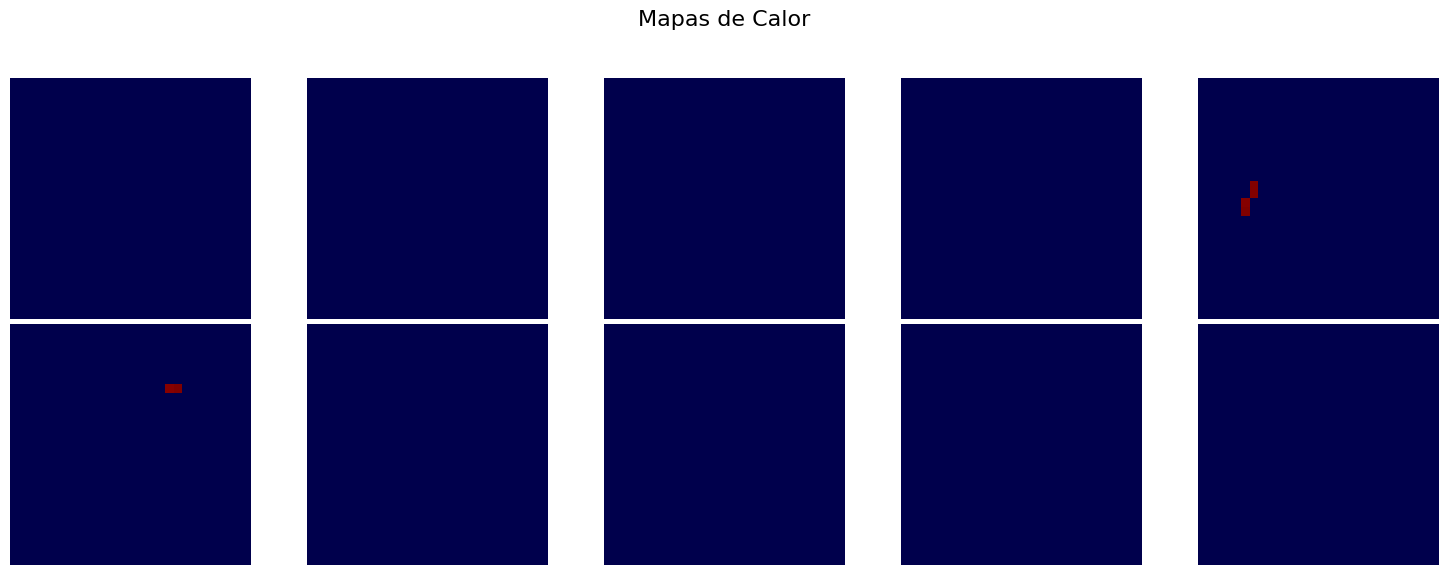

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 8
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 0.0, Min: 0.0
Mapa 1: Max: 0.0, Min: 0.0
Mapa 2: Max: 0.0, Min: 0.0
Mapa 3: Max: 0.0, Min: 0.0
Mapa 4: Max: 1.0, Min: 0.0
Mapa 5: Max: 1.0, Min: 0.0
Mapa 6: Max: 0.0, Min: 0.0
Mapa 7: Max: 0.0, Min: 0.0
Mapa 8: Max: 0.0, Min: 0.0
Mapa 9: Max: 0.0, Min: 0.0
Cantidad de rasgos mayores que 0.85: 2
Indices mayores que 0.85: [214 215]
Suma clase objetivo: 1.983554399009364
Suma de otras clases: 0.0
IFI calculado: 17.851989591084276
Total classes: 10


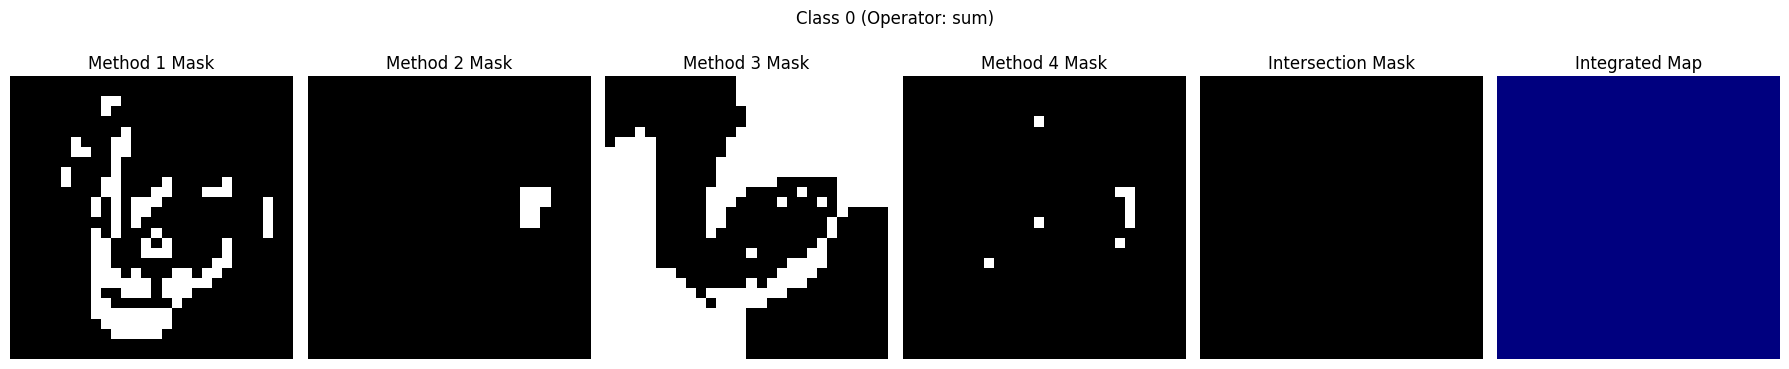

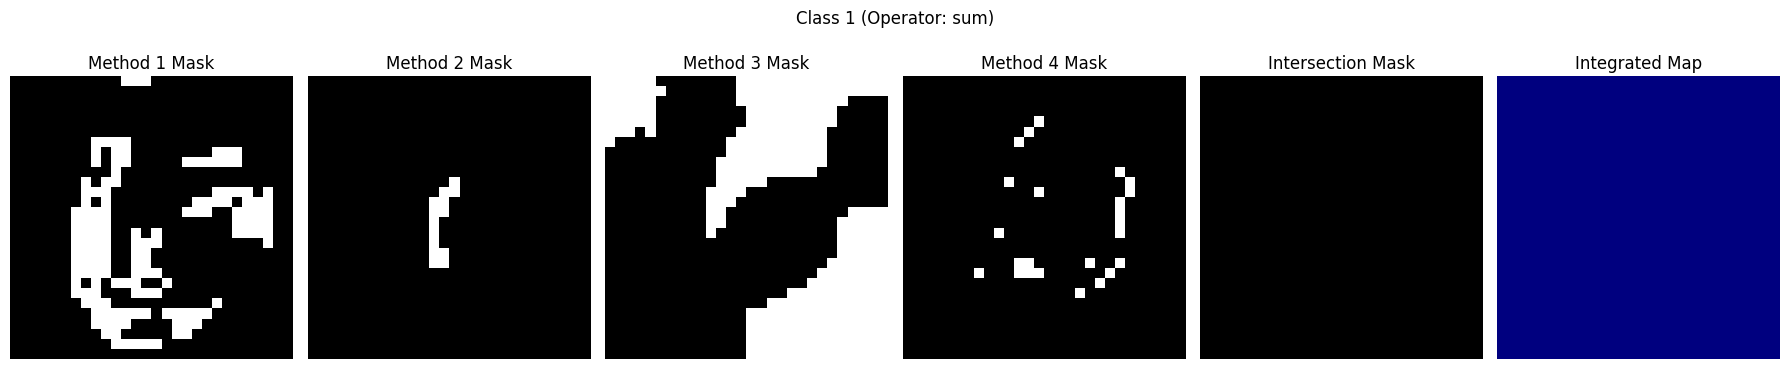

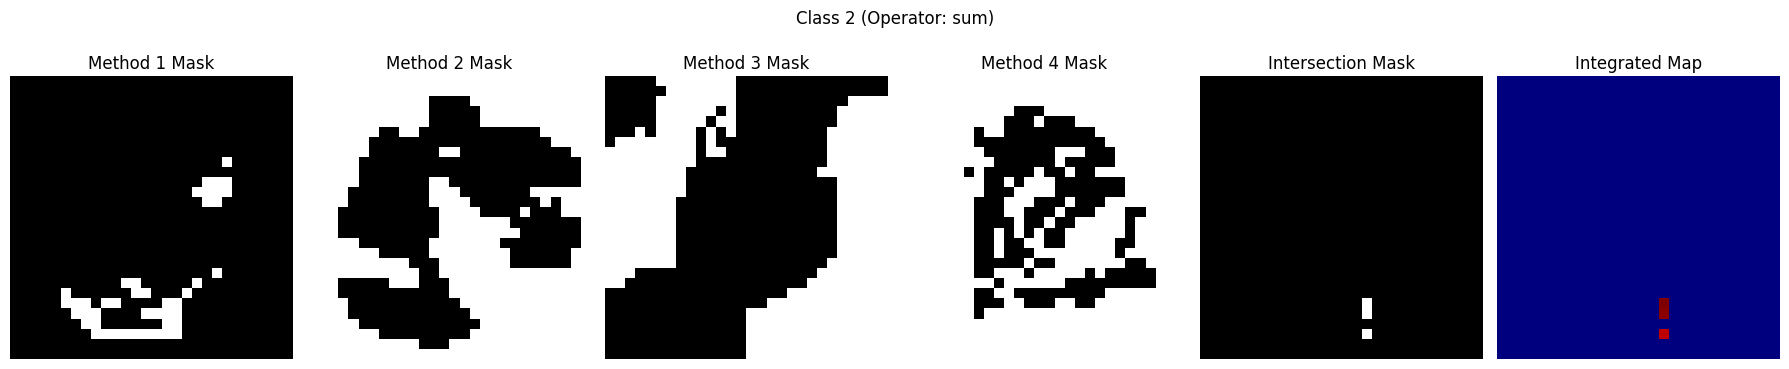

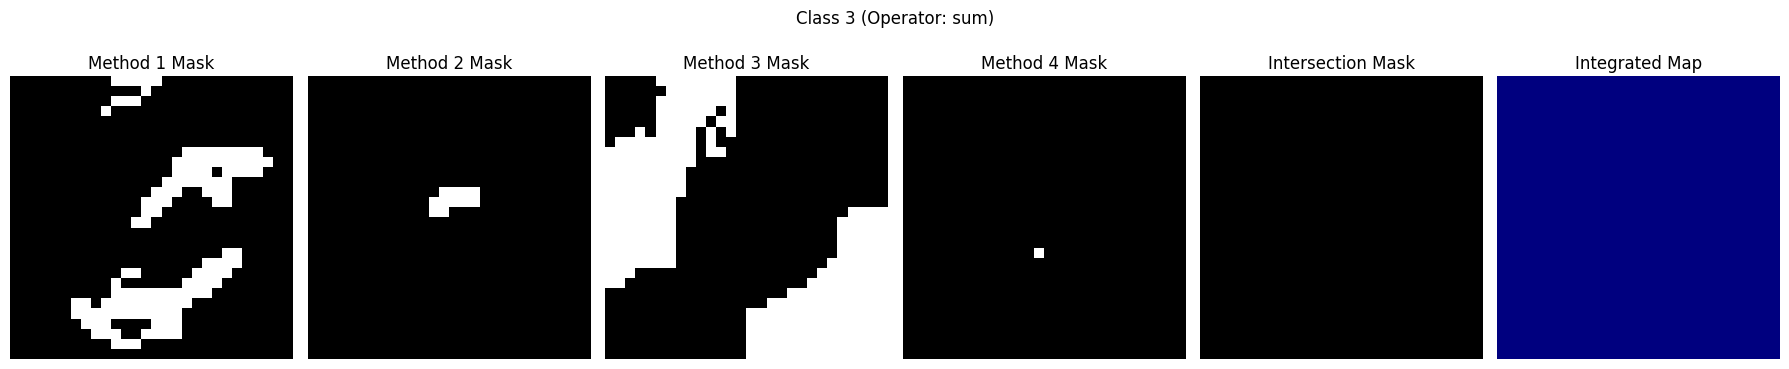

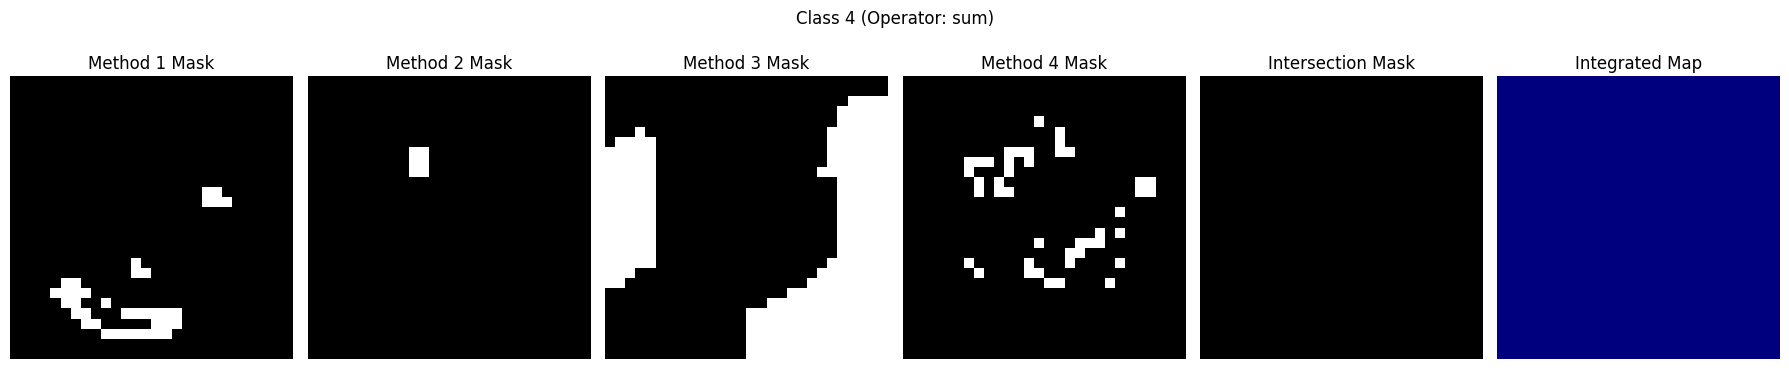

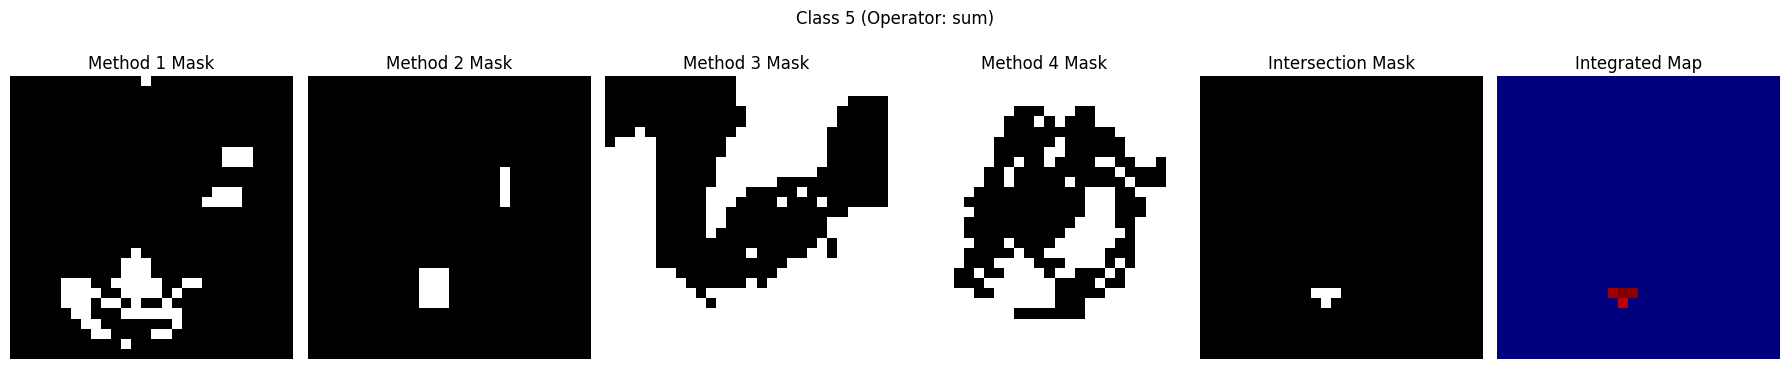

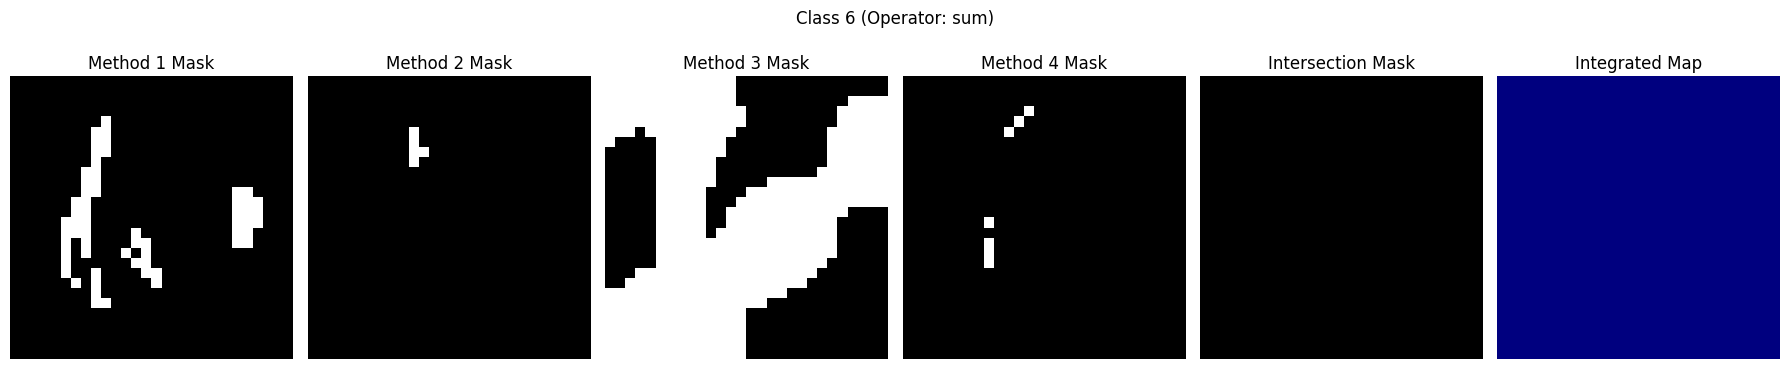

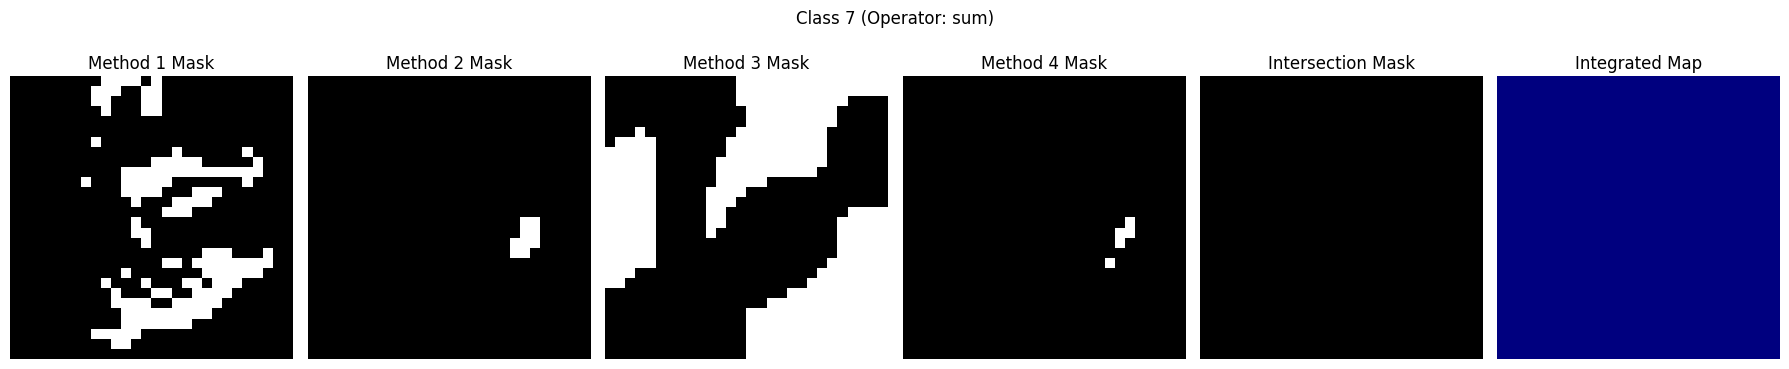

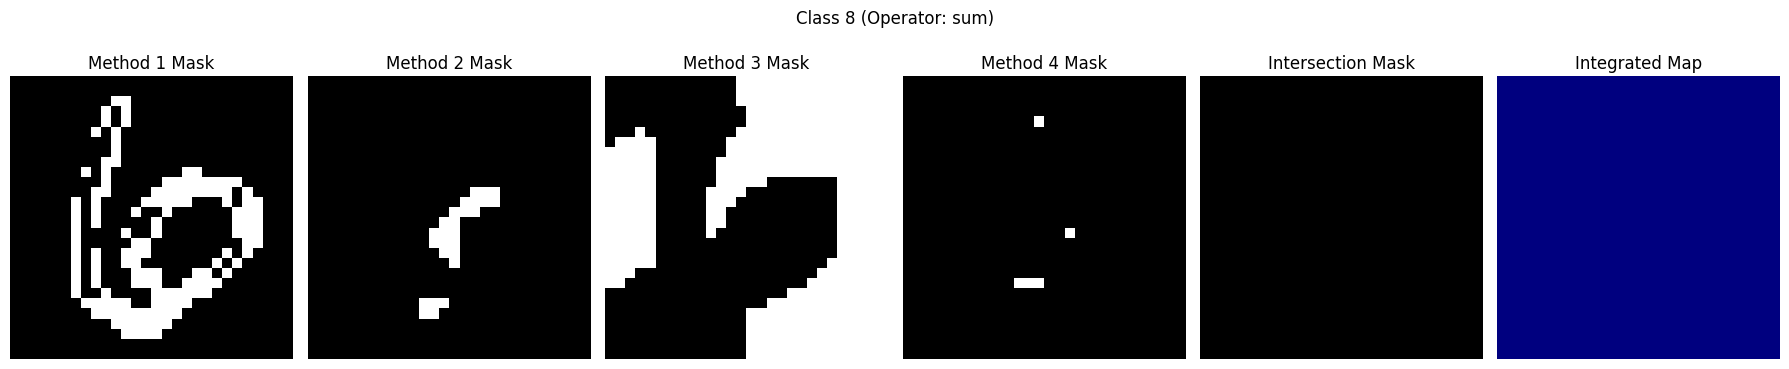

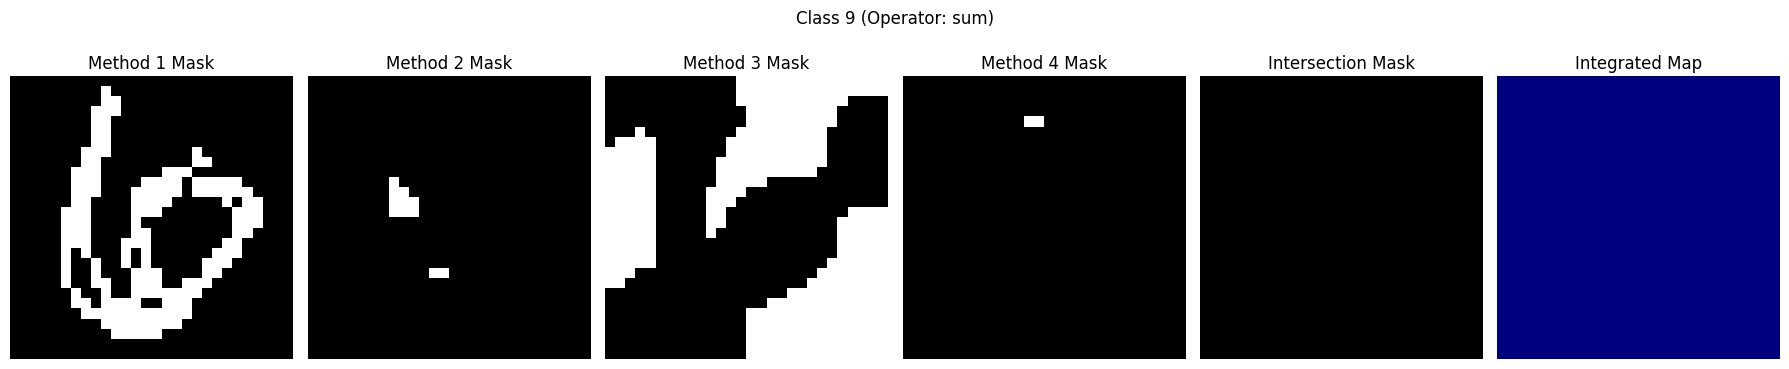

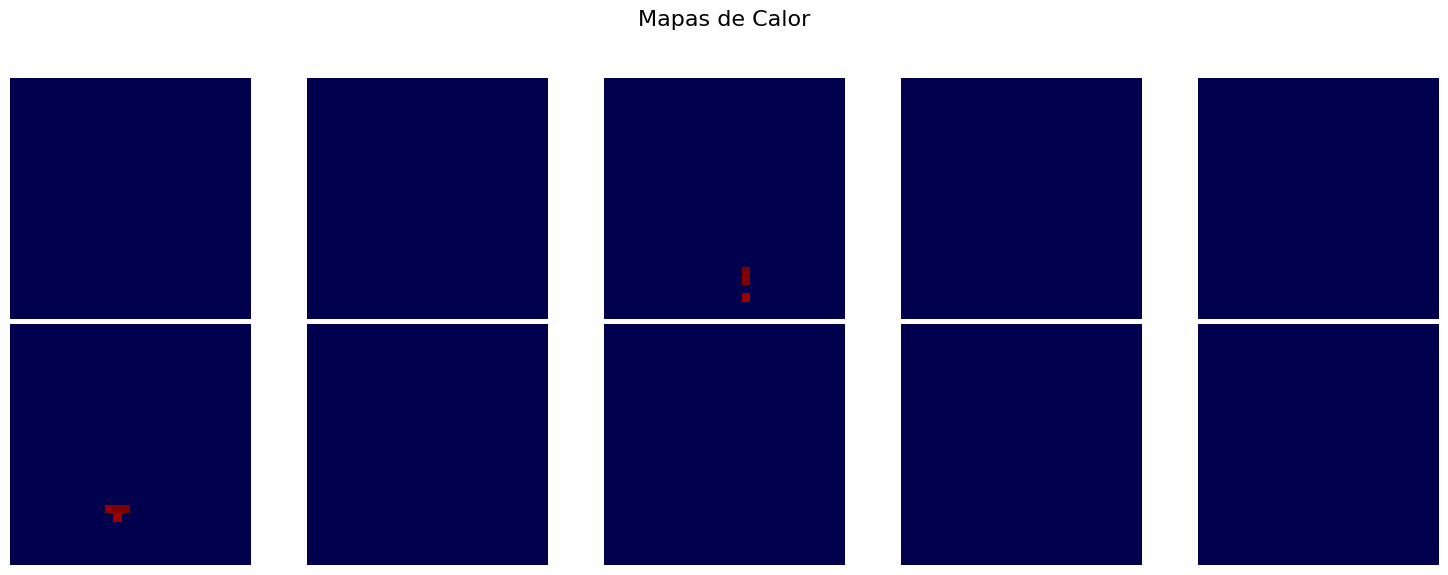

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 8
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 0.0, Min: 0.0
Mapa 1: Max: 0.0, Min: 0.0
Mapa 2: Max: 1.0, Min: 0.0
Mapa 3: Max: 0.0, Min: 0.0
Mapa 4: Max: 0.0, Min: 0.0
Mapa 5: Max: 1.0, Min: 0.0
Mapa 6: Max: 0.0, Min: 0.0
Mapa 7: Max: 0.0, Min: 0.0
Mapa 8: Max: 0.0, Min: 0.0
Mapa 9: Max: 0.0, Min: 0.0
Cantidad de rasgos mayores que 0.85: 0
Indices mayores que 0.85: []
Suma clase objetivo: 0.0
Suma de otras clases: 0.0
IFI calculado: 0
Total classes: 10


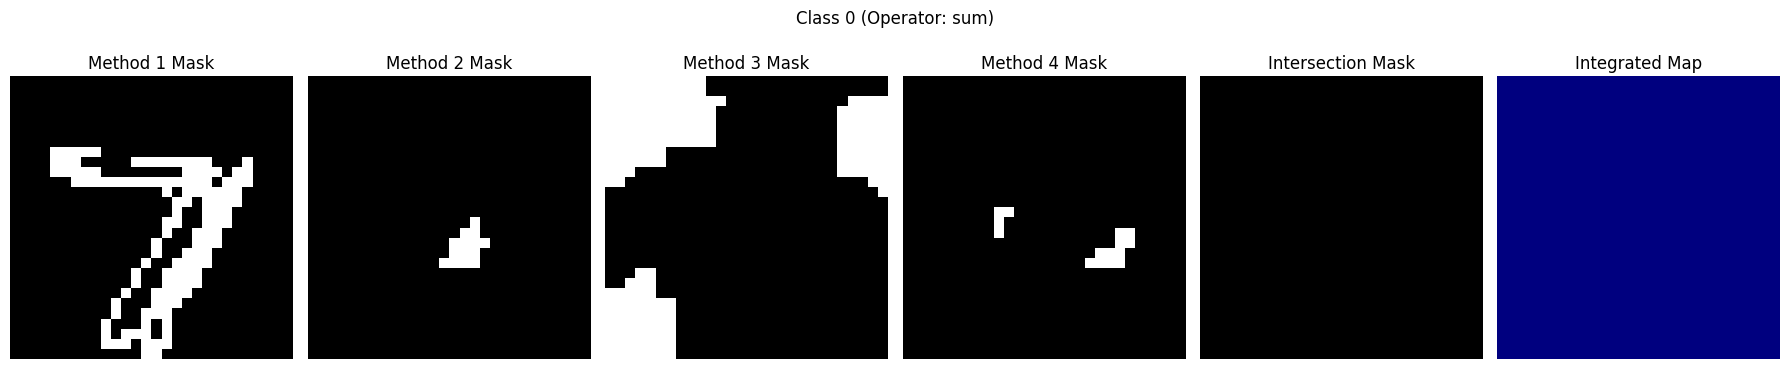

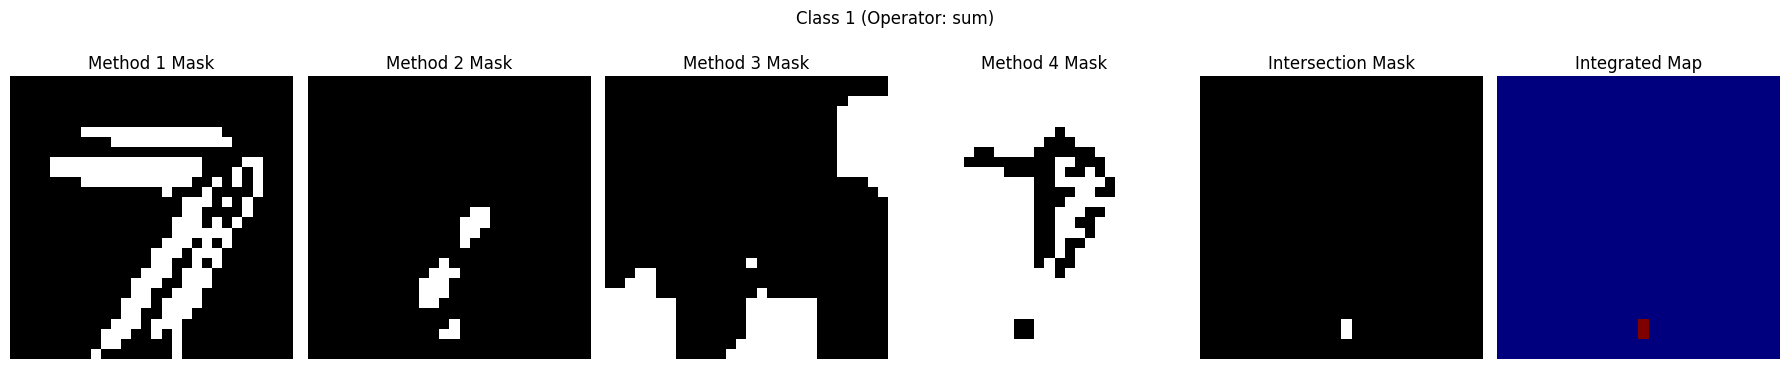

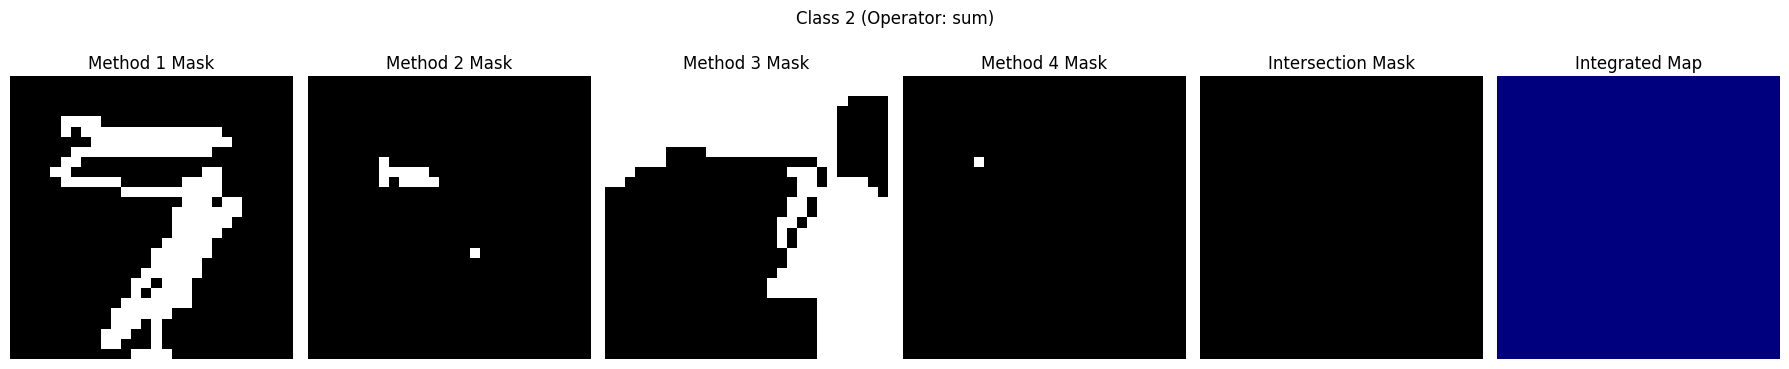

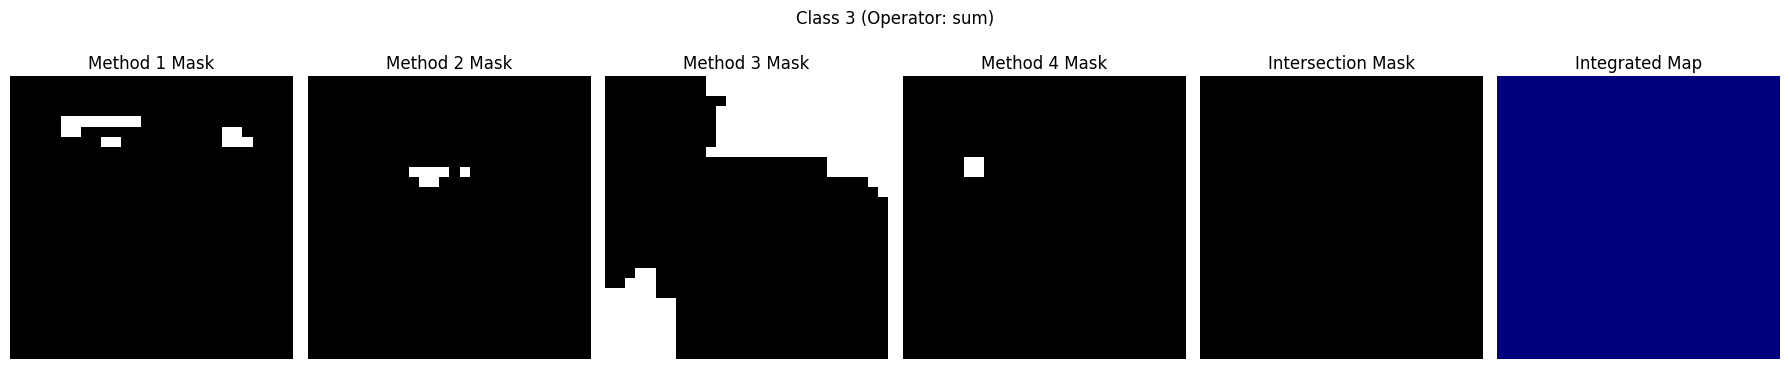

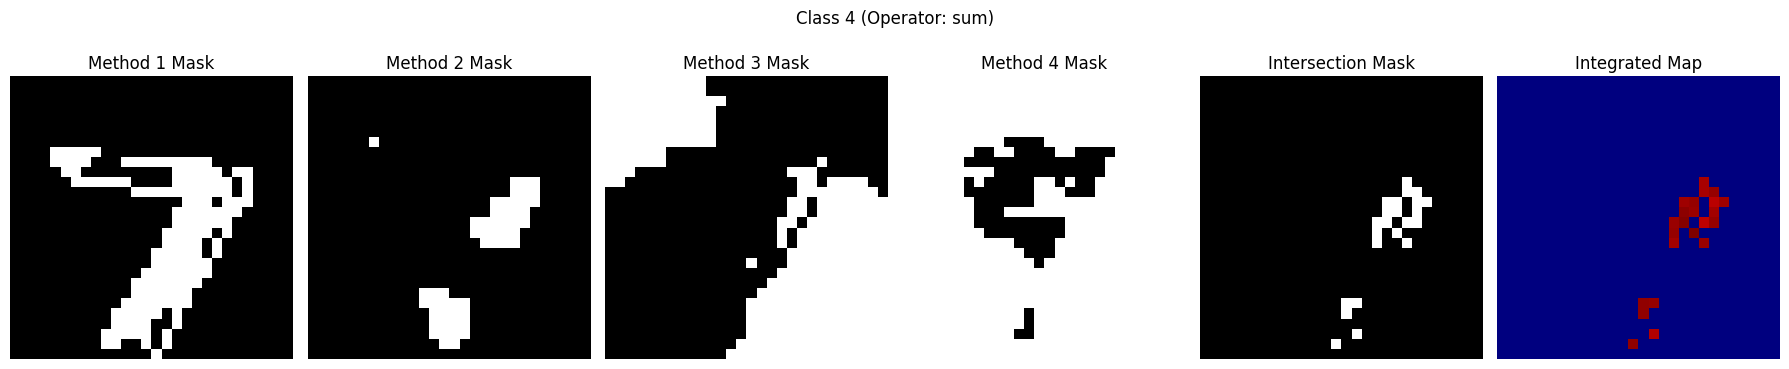

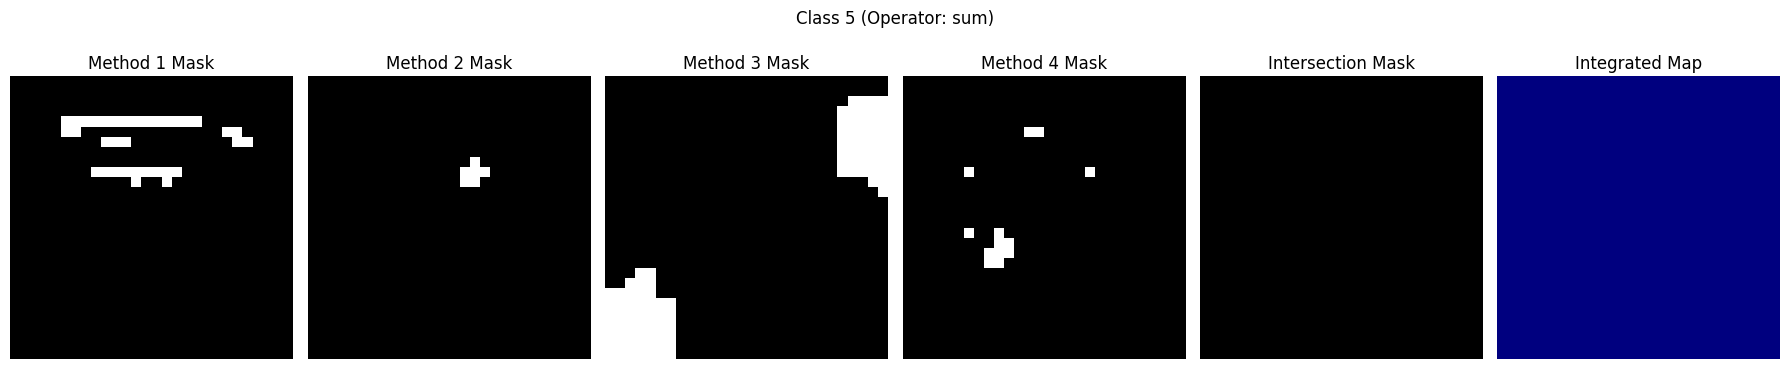

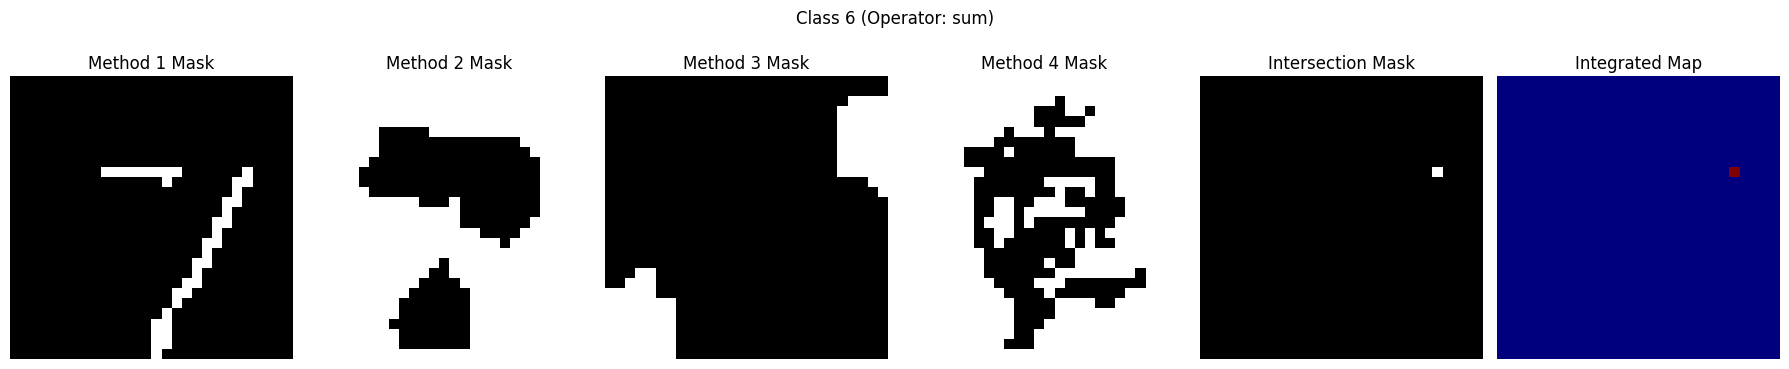

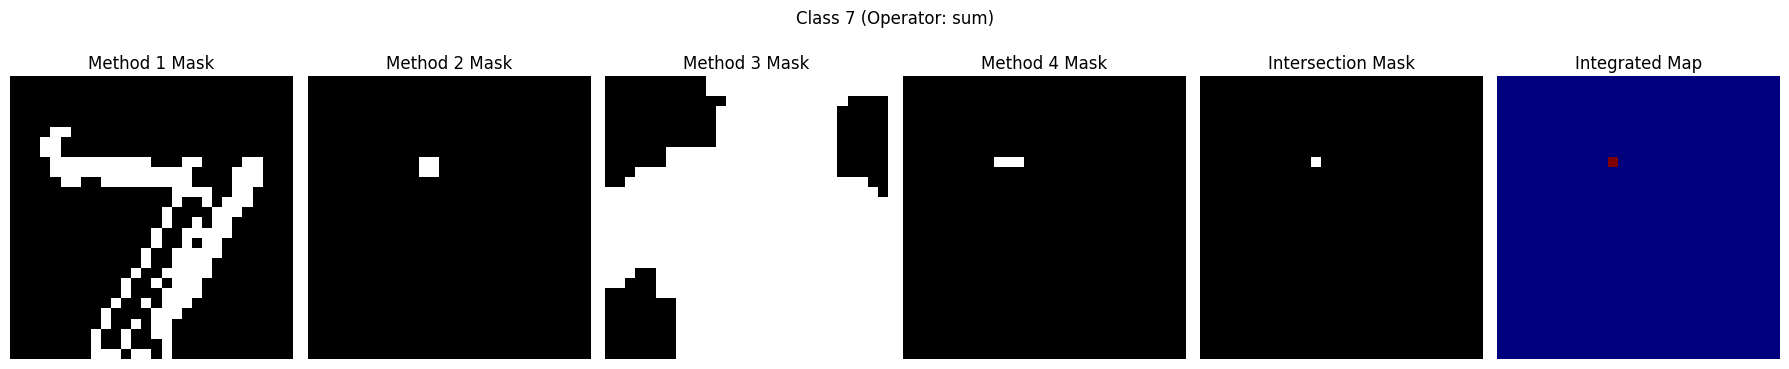

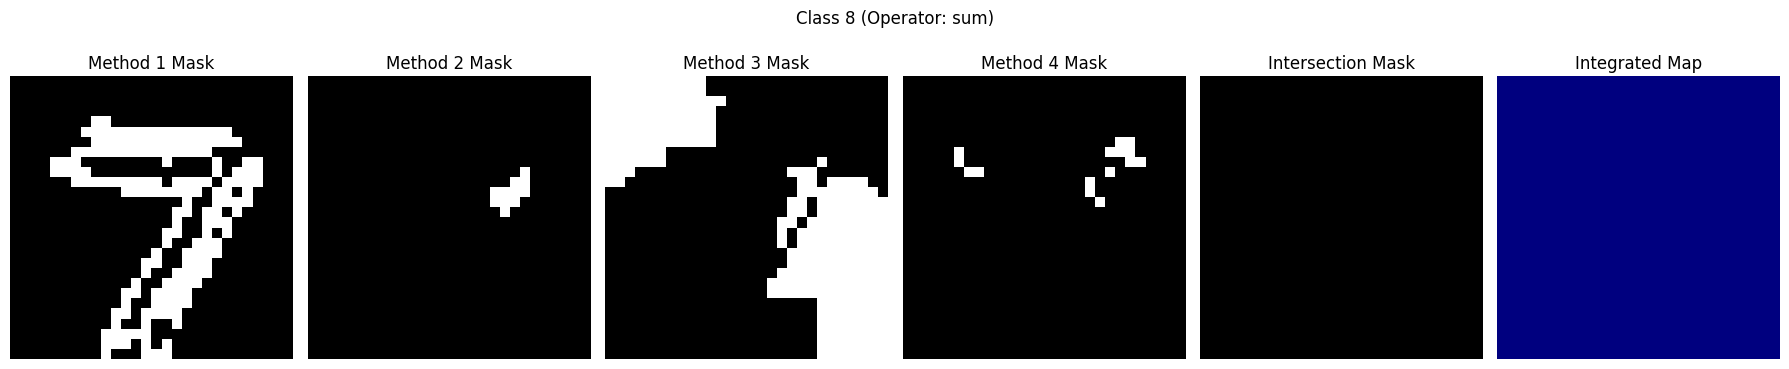

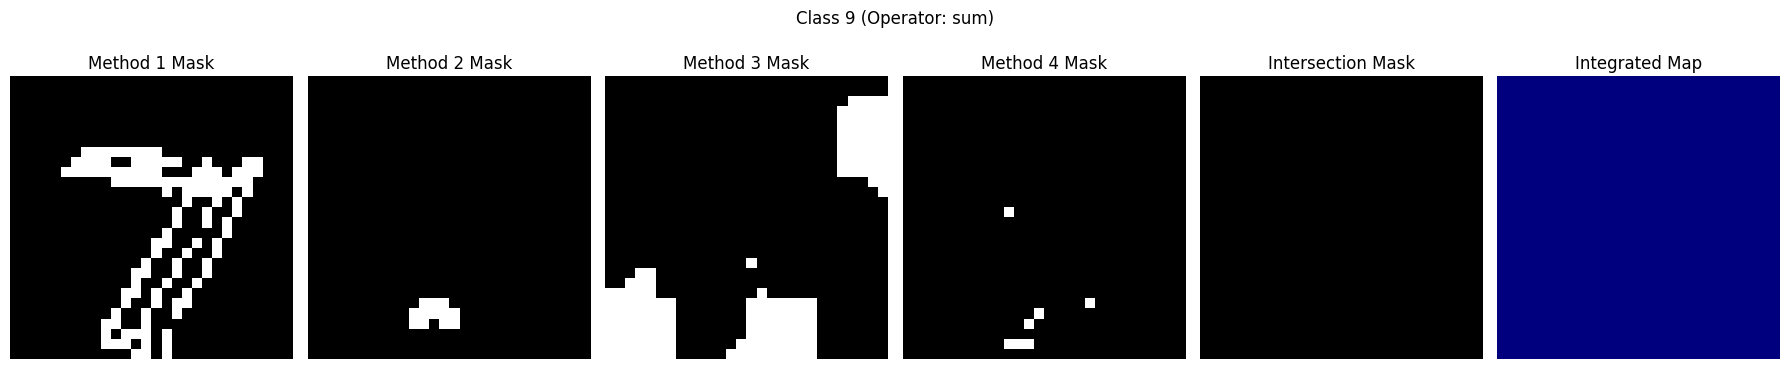

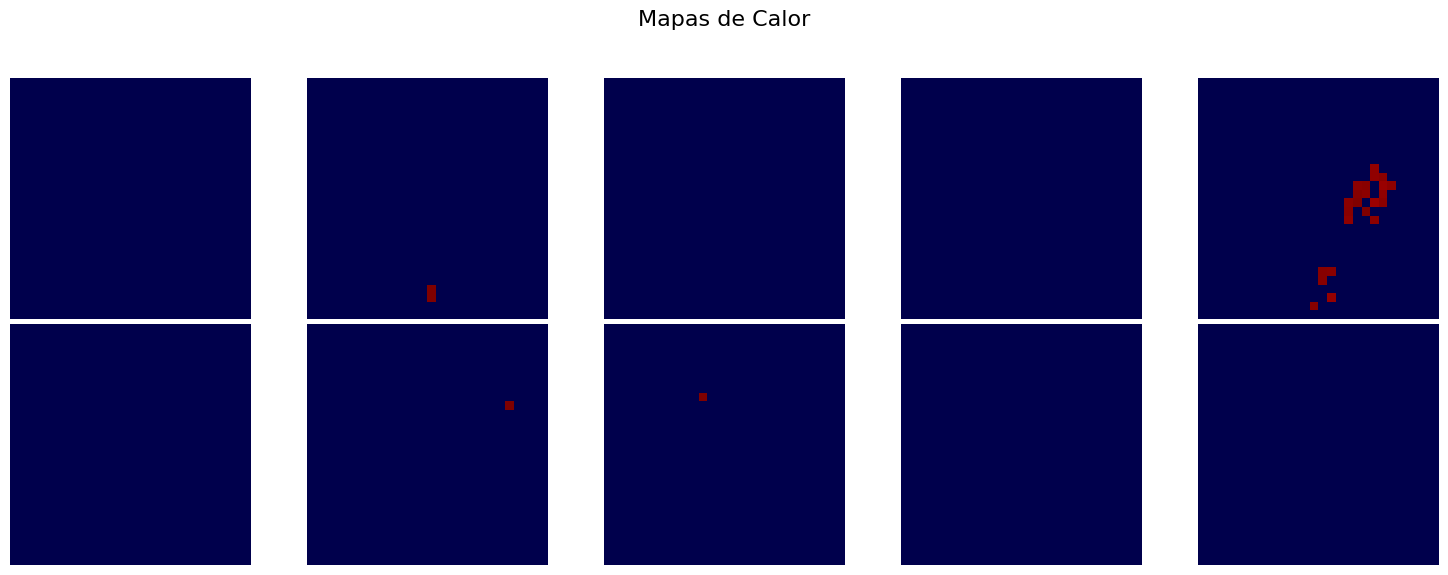

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 6
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 0.0, Min: 0.0
Mapa 1: Max: 1.0, Min: 0.0
Mapa 2: Max: 0.0, Min: 0.0
Mapa 3: Max: 0.0, Min: 0.0
Mapa 4: Max: 1.0, Min: 0.0
Mapa 5: Max: 0.0, Min: 0.0
Mapa 6: Max: 1.0, Min: 0.0
Mapa 7: Max: 1.0, Min: 0.0
Mapa 8: Max: 0.0, Min: 0.0
Mapa 9: Max: 0.0, Min: 0.0
Cantidad de rasgos mayores que 0.85: 1
Indices mayores que 0.85: [235]
Suma clase objetivo: 1.0
Suma de otras clases: 0.0
IFI calculado: 9.0
Total classes: 10


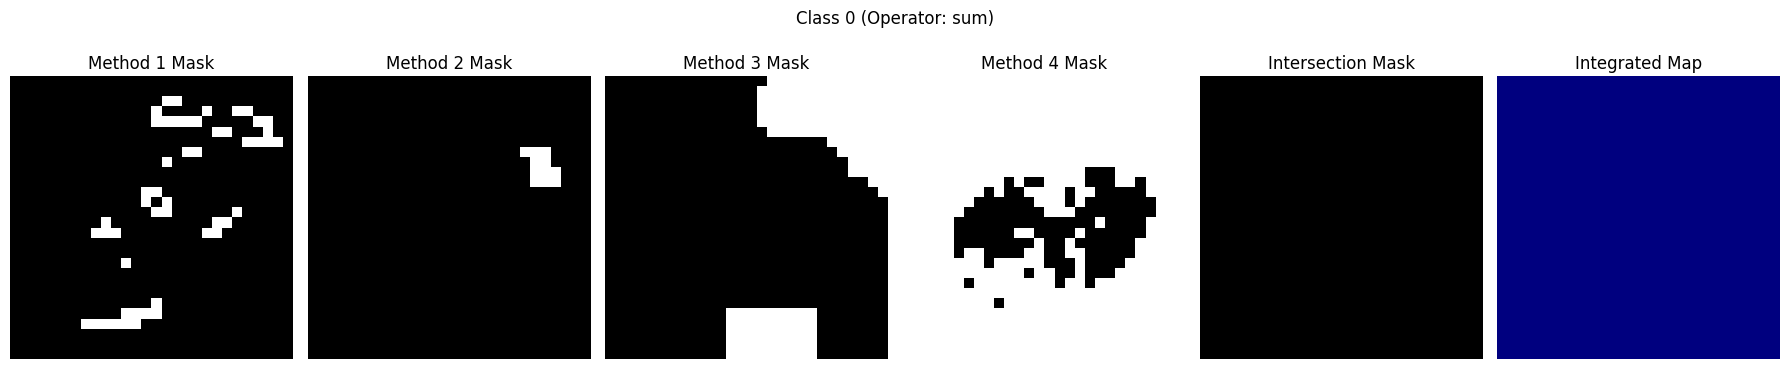

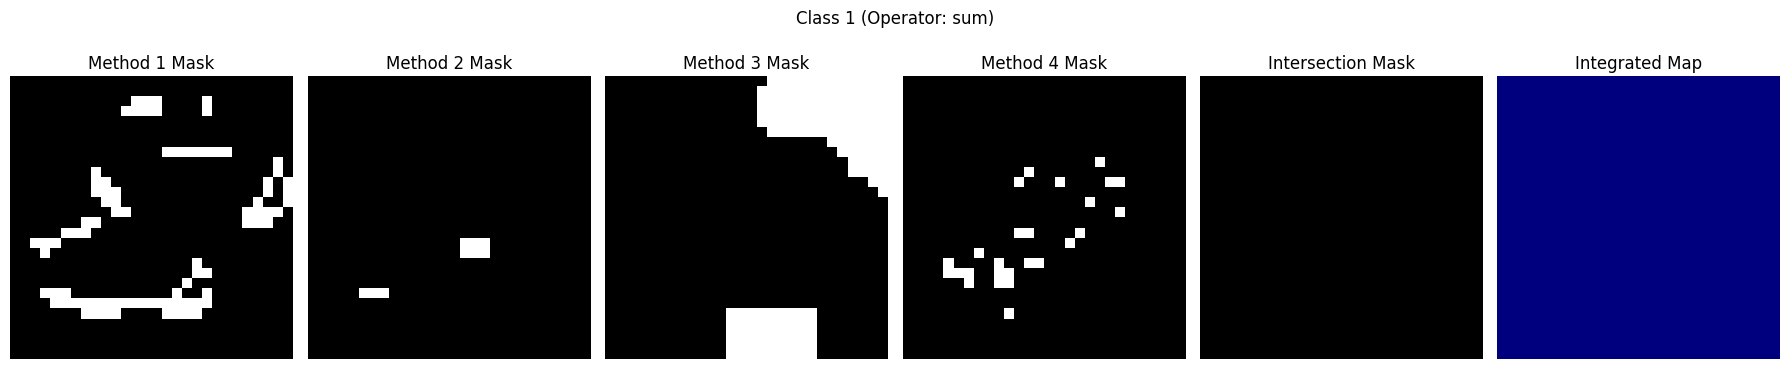

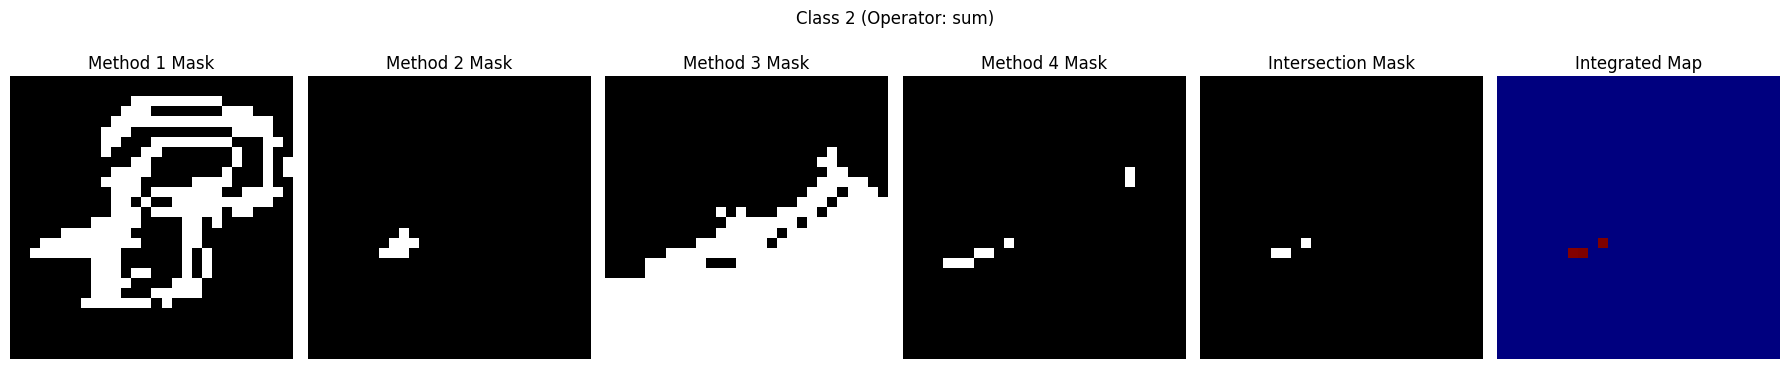

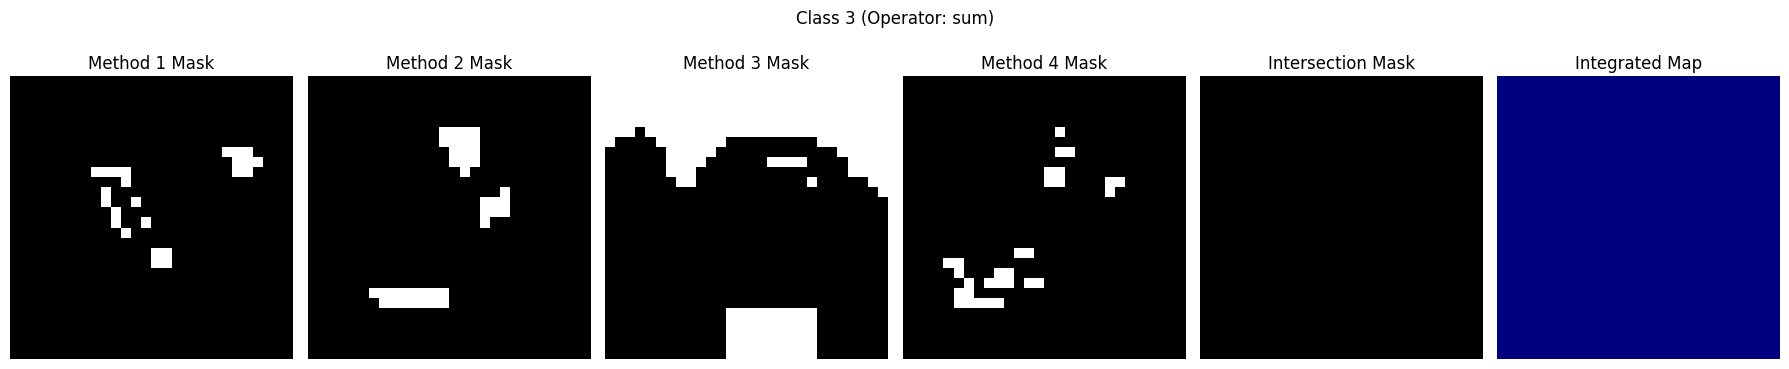

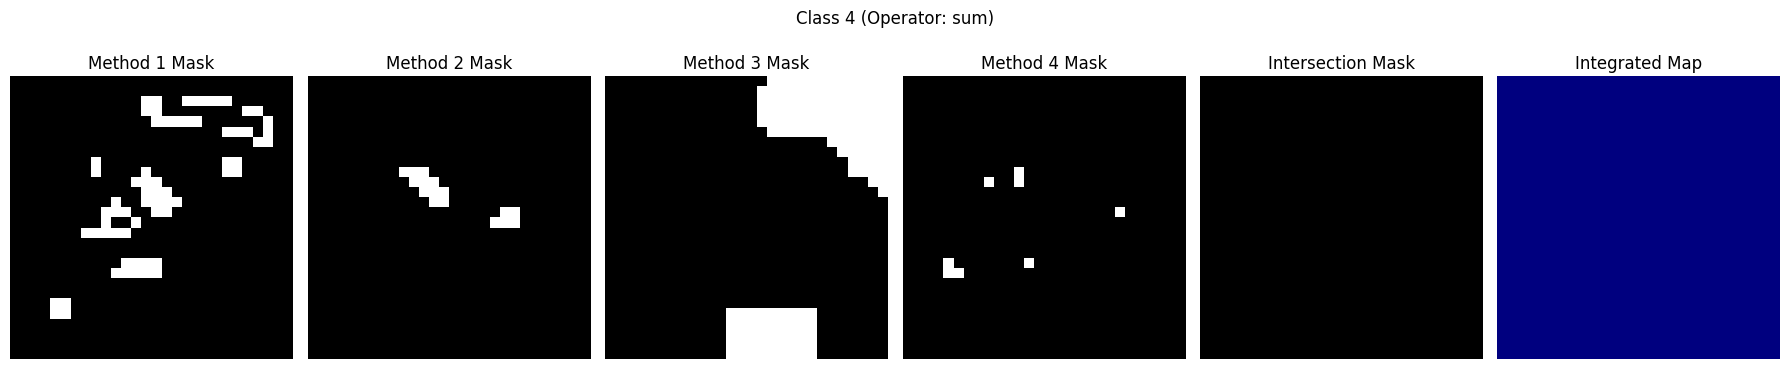

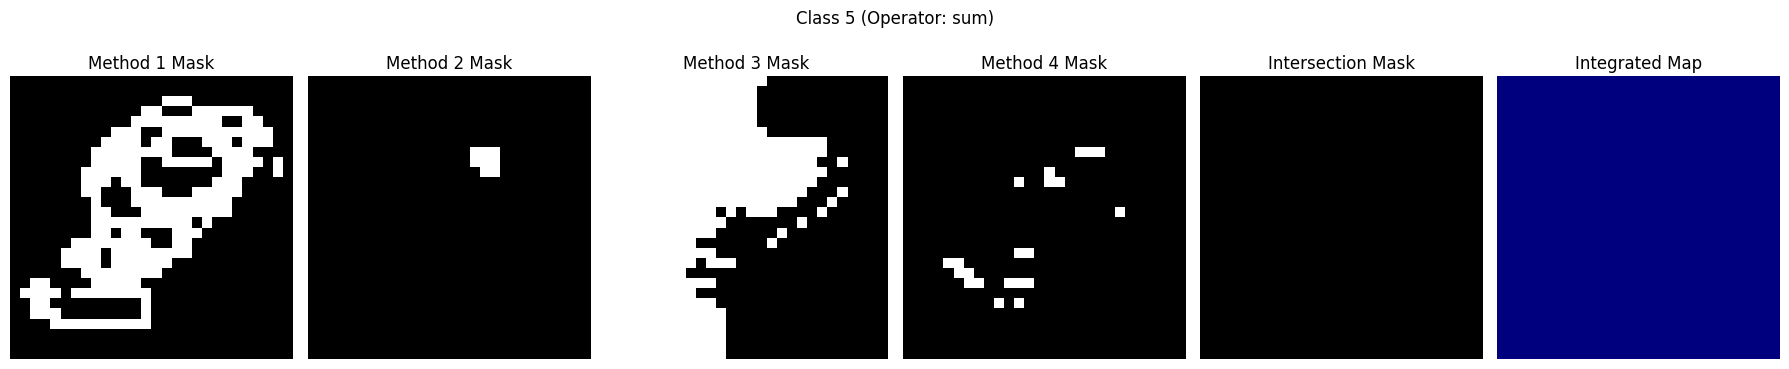

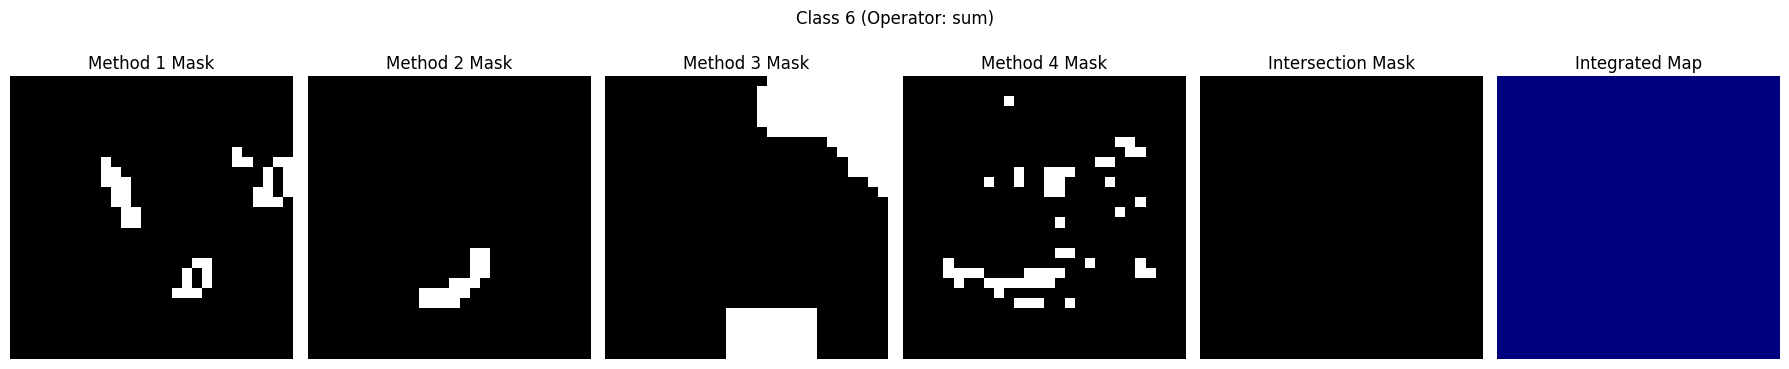

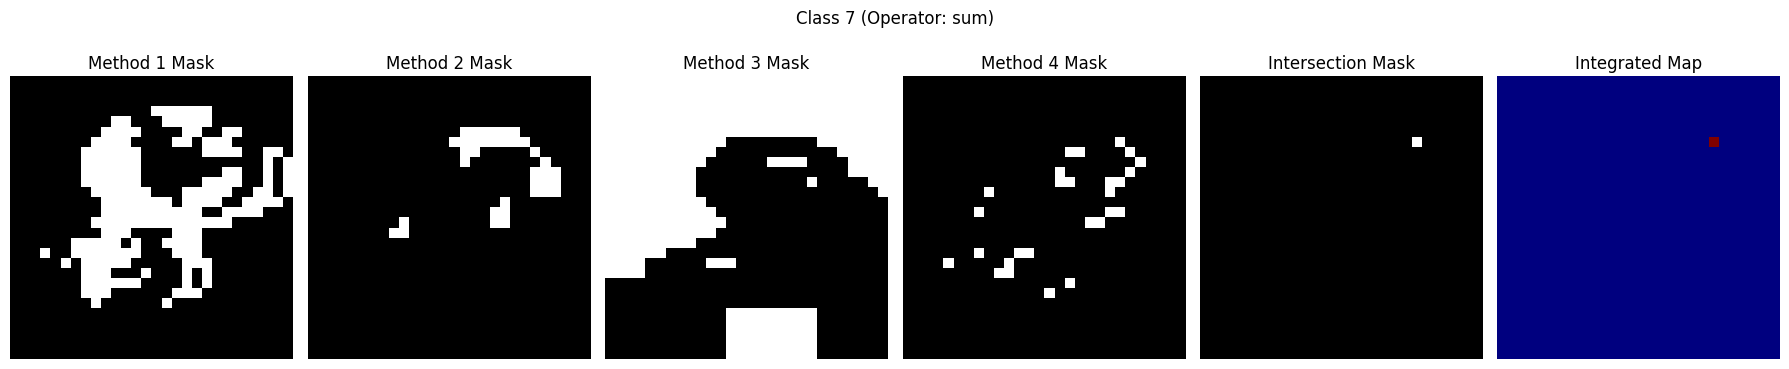

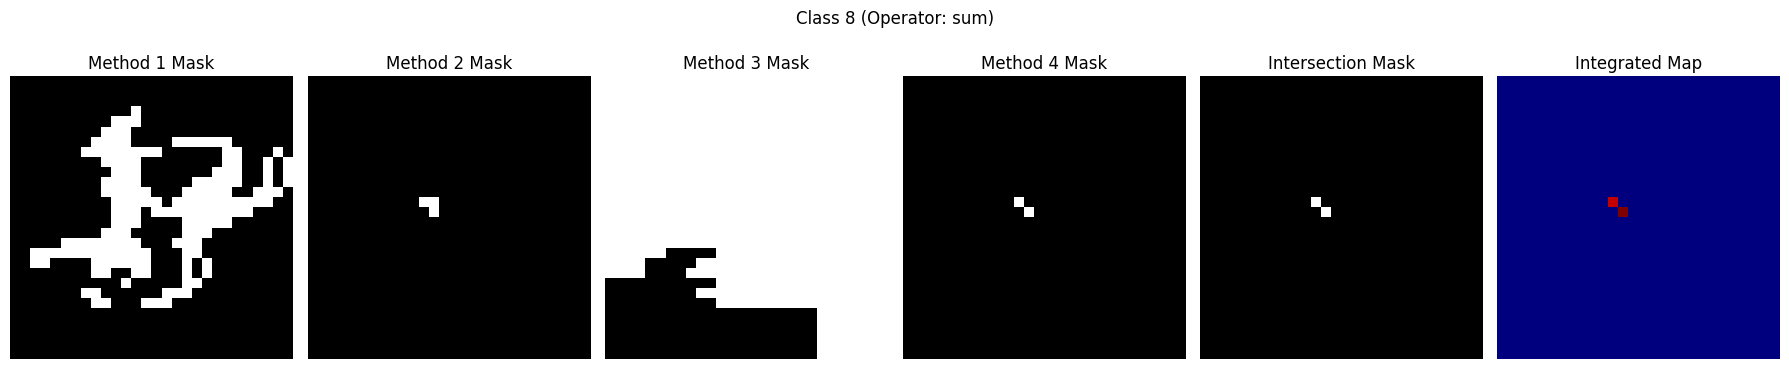

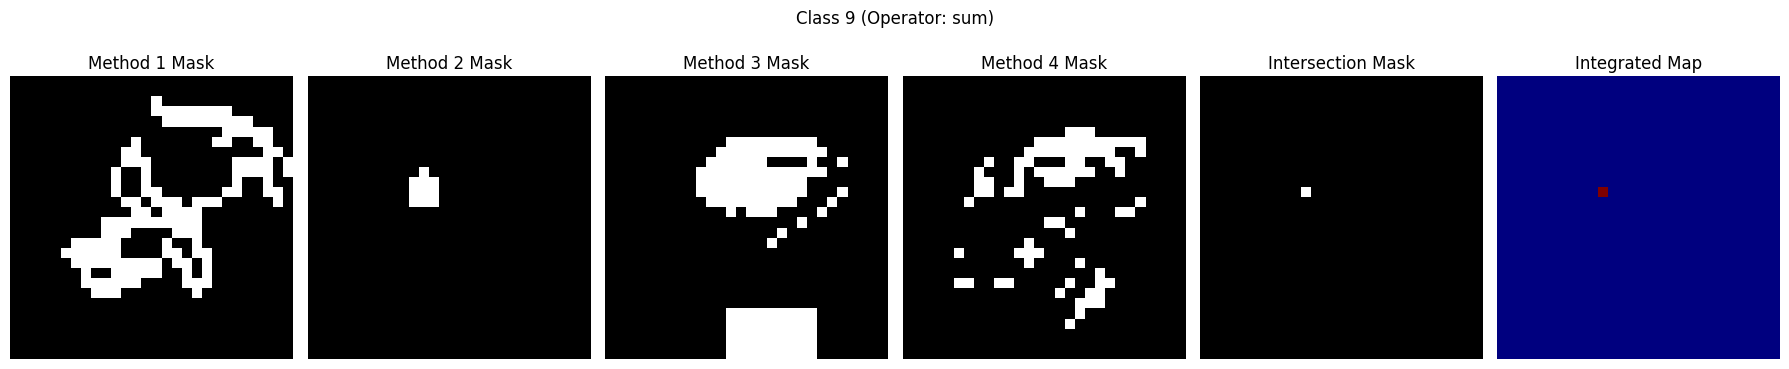

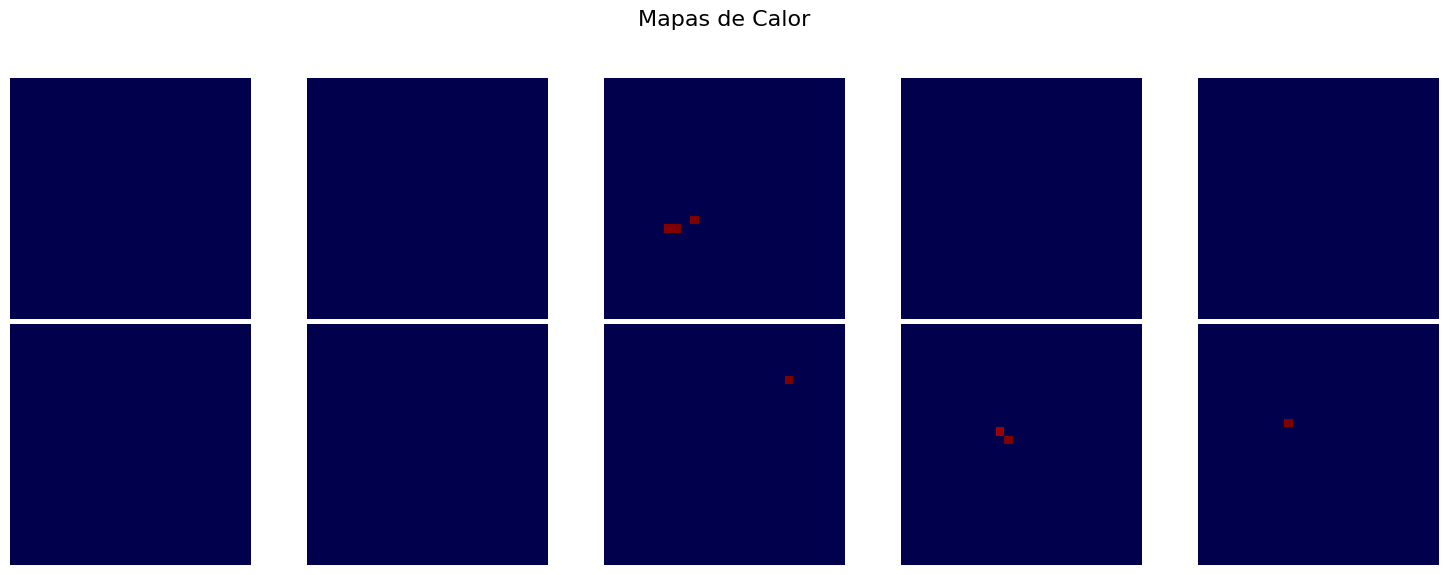

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 6
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 0.0, Min: 0.0
Mapa 1: Max: 0.0, Min: 0.0
Mapa 2: Max: 1.0, Min: 0.0
Mapa 3: Max: 0.0, Min: 0.0
Mapa 4: Max: 0.0, Min: 0.0
Mapa 5: Max: 0.0, Min: 0.0
Mapa 6: Max: 0.0, Min: 0.0
Mapa 7: Max: 1.0, Min: 0.0
Mapa 8: Max: 1.0, Min: 0.0
Mapa 9: Max: 1.0, Min: 0.0
Cantidad de rasgos mayores que 0.85: 2
Indices mayores que 0.85: [347 376]
Suma clase objetivo: 1.9400114481504906
Suma de otras clases: 0.0
IFI calculado: 17.460103033354414
Total classes: 10


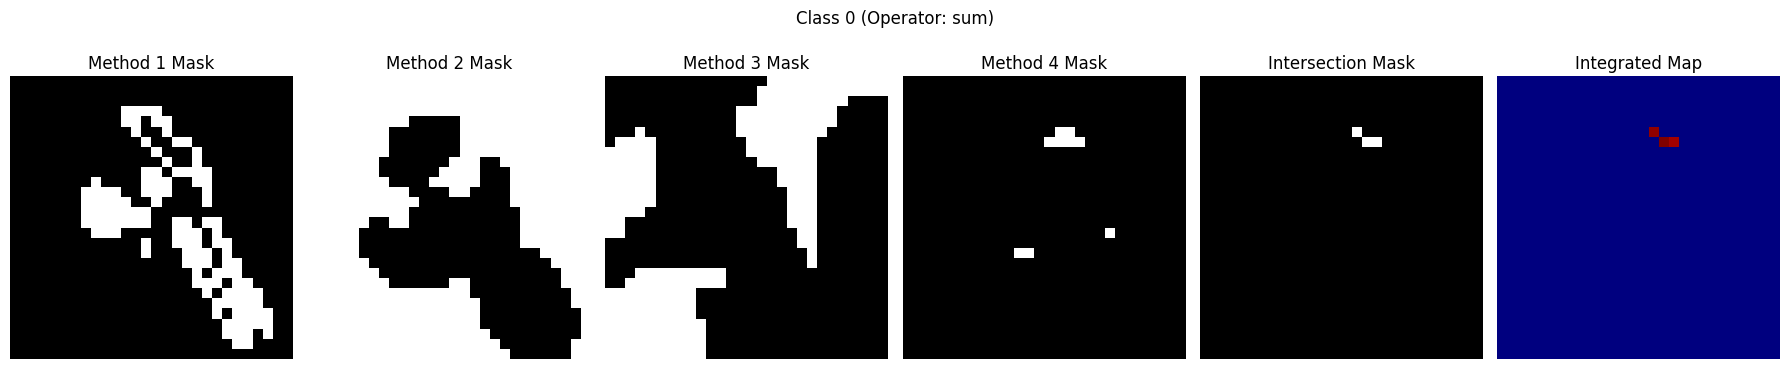

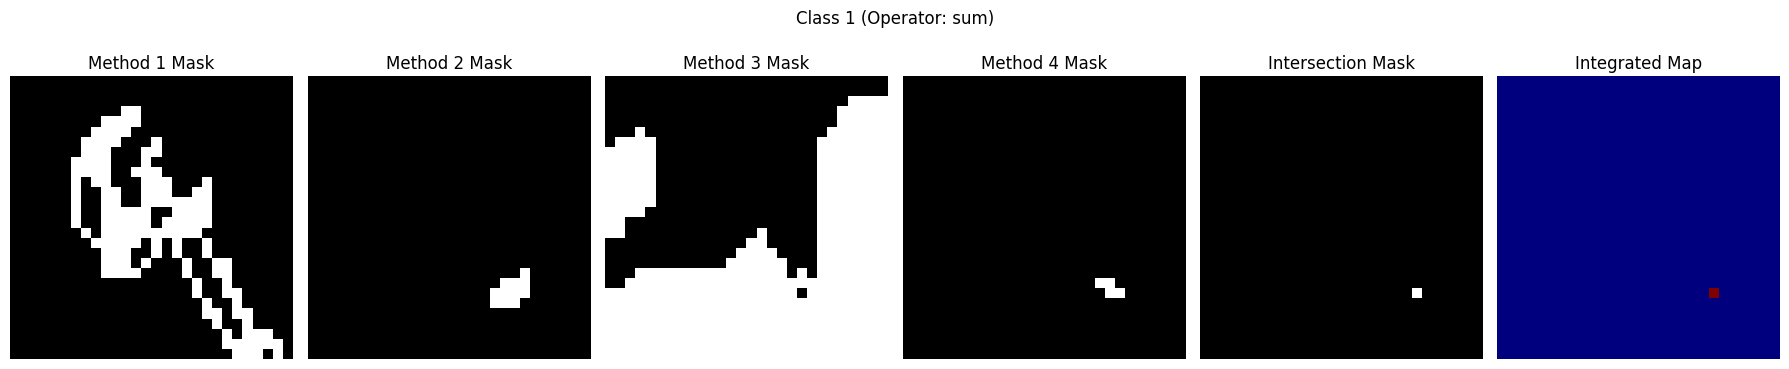

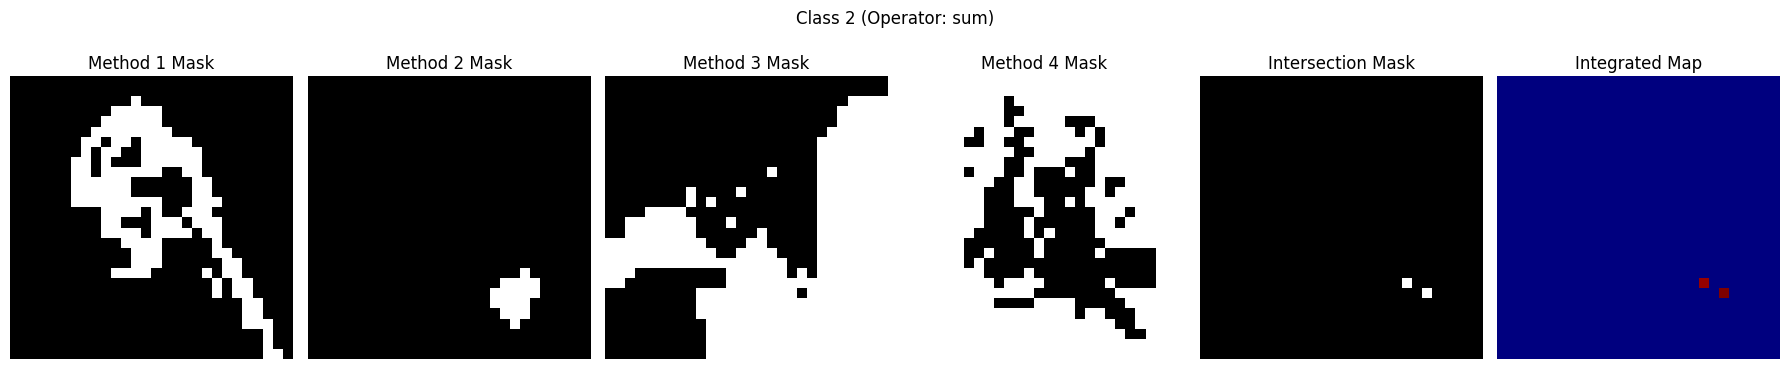

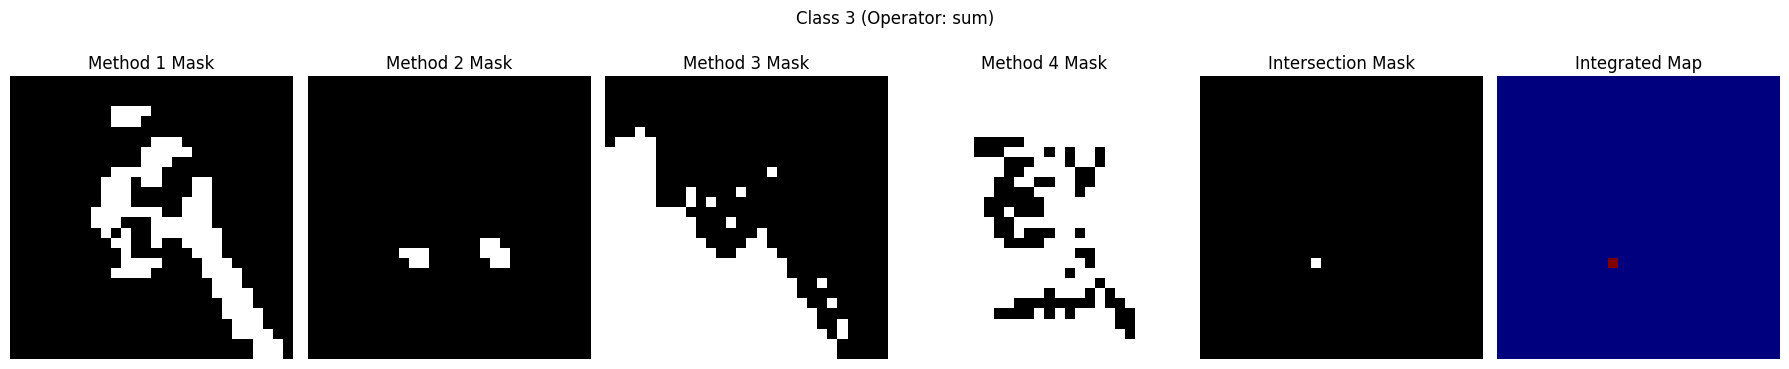

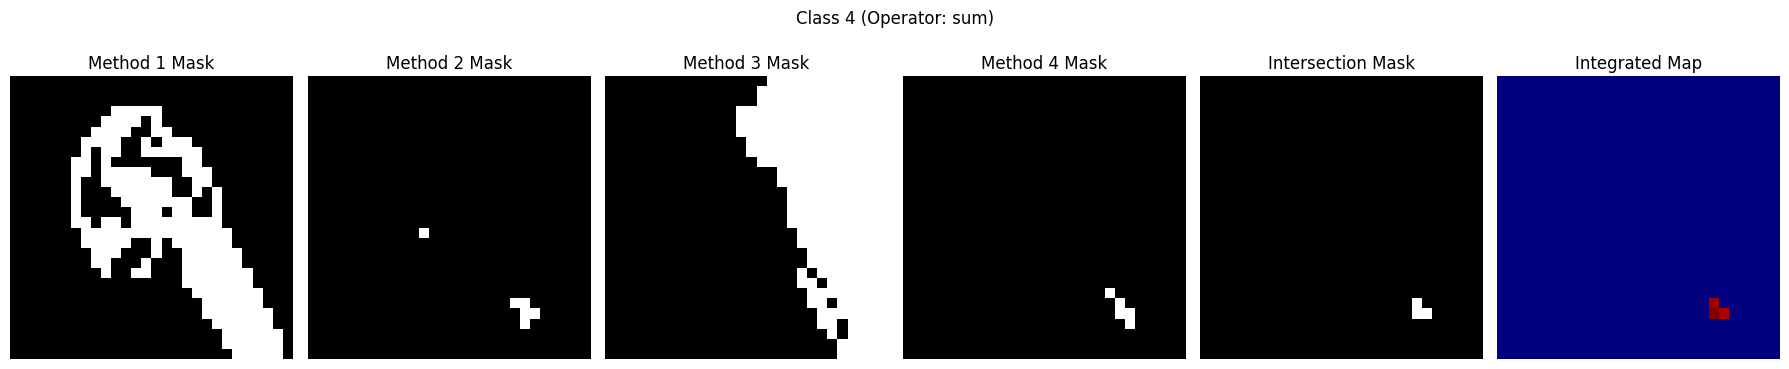

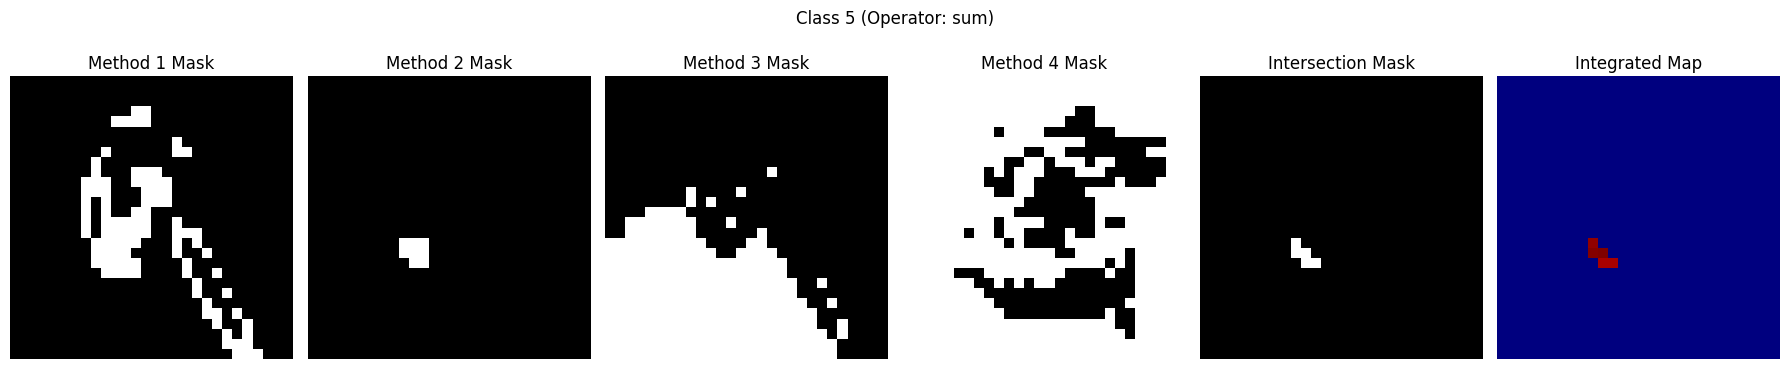

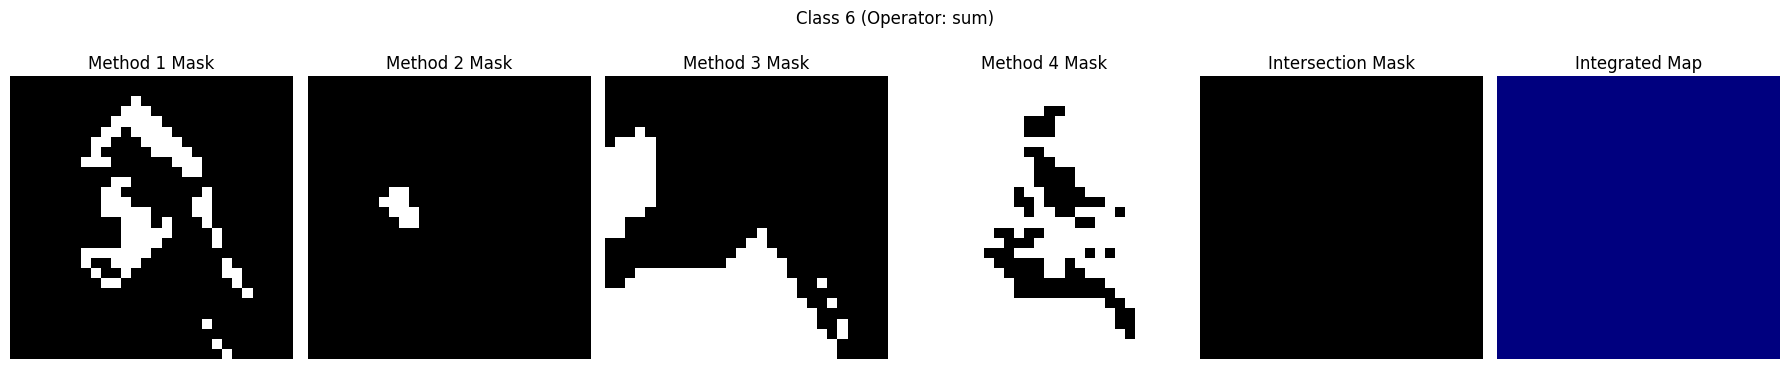

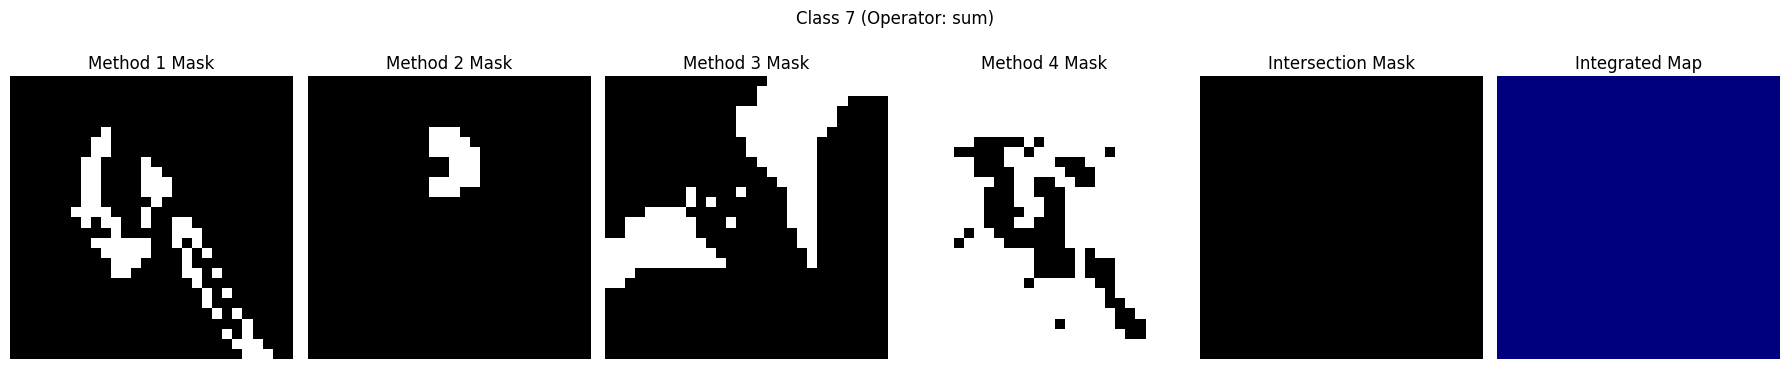

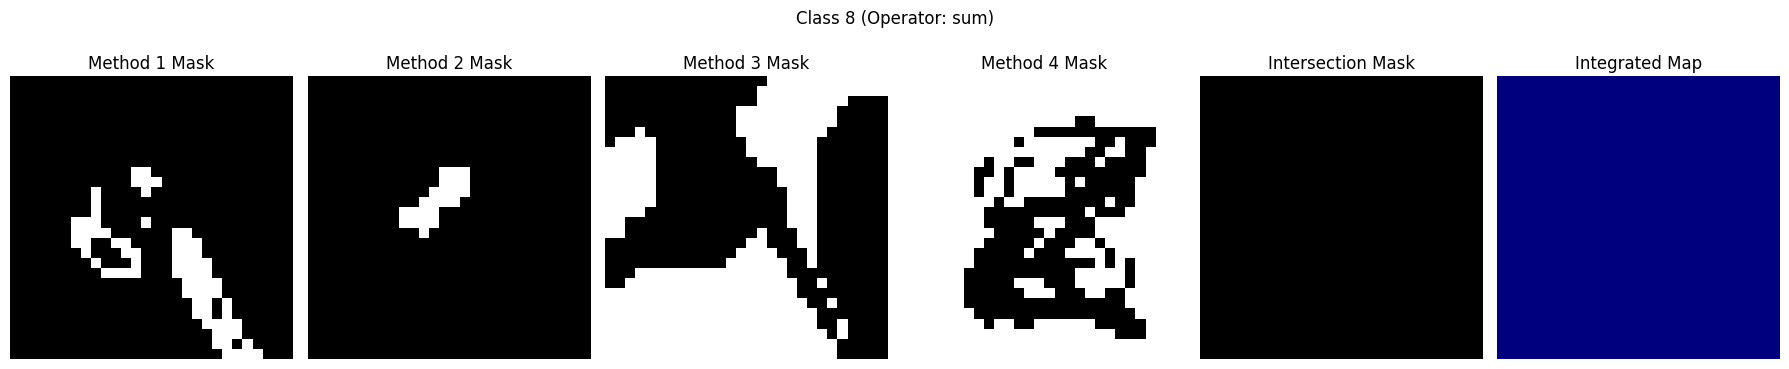

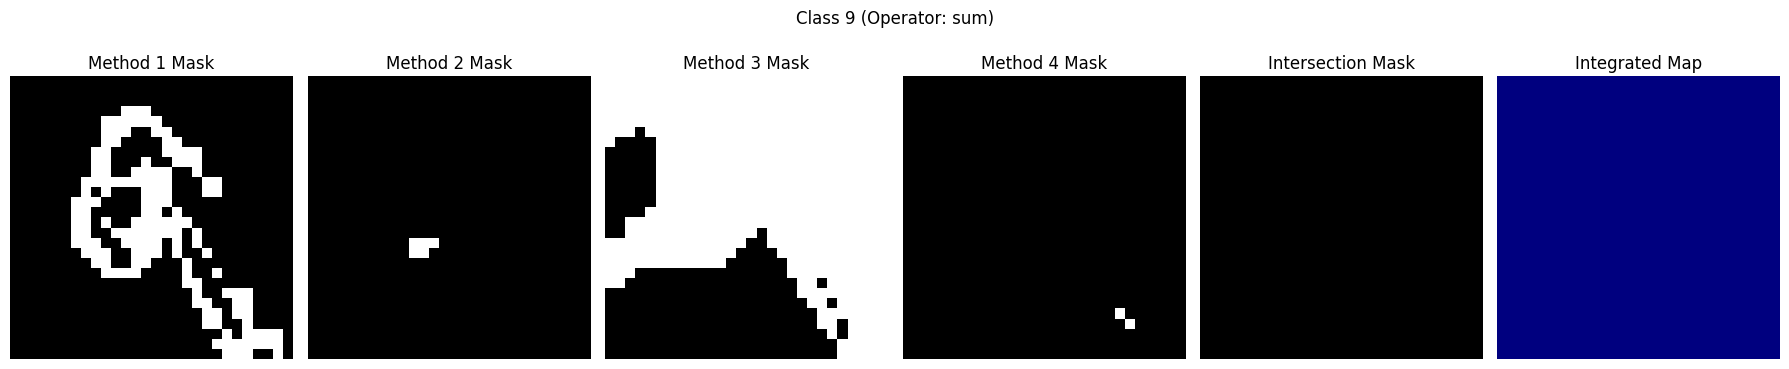

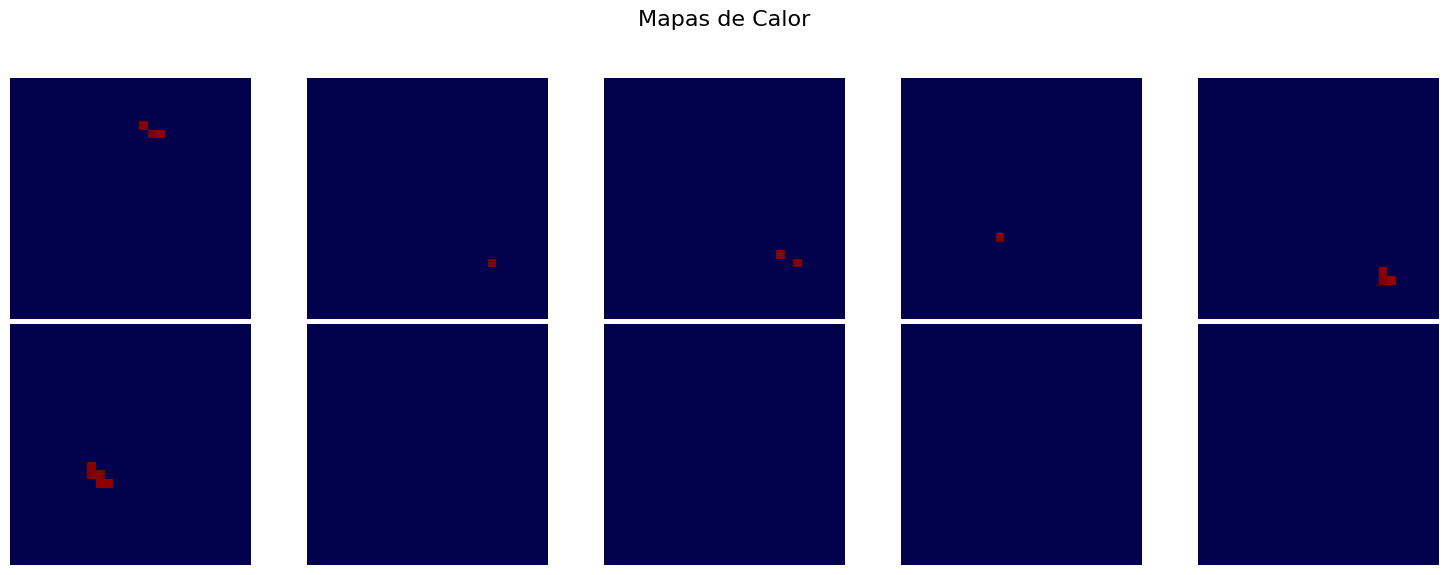

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 4
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 1.0, Min: 0.0
Mapa 1: Max: 1.0, Min: 0.0
Mapa 2: Max: 1.0, Min: 0.0
Mapa 3: Max: 1.0, Min: 0.0
Mapa 4: Max: 1.0, Min: 0.0
Mapa 5: Max: 1.0, Min: 0.0
Mapa 6: Max: 0.0, Min: 0.0
Mapa 7: Max: 0.0, Min: 0.0
Mapa 8: Max: 0.0, Min: 0.0
Mapa 9: Max: 0.0, Min: 0.0
Cantidad de rasgos mayores que 0.85: 0
Indices mayores que 0.85: []
Suma clase objetivo: 0.0
Suma de otras clases: 0.0
IFI calculado: 0


In [14]:
#Use weighted sum
integrated_explanations_intersection, lse_integrated_intersection = intersection_owa_integrations.calculate_lse_intersection_integrated_explanations(
    explanations_data=new_explanations_data,
    y_selected=y_selected,
    threshold = 0.85,
    operator = 'sum'
)

##Max


In [15]:
def calculate_max_per_pixel(explanations_data):
    """
    Calculates the pixel-wise maximum across all explanations for each image and class.
    Includes prints of dimensions and max/min values at each step.

    Args:
        explanations_data (list of dict): Contains explanations from the 4 methods.
                                          Each dict element contains 'explanations' and 'lse_value'.
                                          'explanations' has dimensions (10, 10, 28, 28).

    Returns:
        integrated_explanations (list of numpy.ndarray): List of integrated heatmaps using the maximum.
    """
    num_images = len(explanations_data[0]['explanations'])  # Number of images (10)
    num_classes = len(explanations_data[0]['explanations'][0])  # Number of classes (10)
    integrated_explanations = []  # To store the integrated results

    for image_idx in range(num_images):  # Iterate through each image
        print(f"\nProcessing image {image_idx + 1}/{num_images}...")
        image_maps = []  # Integrated maps per class for this image

        for class_idx in range(num_classes):  # Iterate through each class
            print(f"  Class {class_idx + 1}/{num_classes}:")

            # Collect heatmaps from the 4 methods for the same image and class
            class_maps = []
            for method_idx in range(len(explanations_data)):  # len(explanations_data) == 4
                map_ = explanations_data[method_idx]['explanations'][image_idx][class_idx]
                single_channel_map = ensure_single_channel(map_)
                normalized_map = normalize_map(single_channel_map)

                # Add to the list of maps
                class_maps.append(normalized_map)

                # Print details of the processed map
                print(f"    Method {method_idx + 1}: Shape: {normalized_map.shape}")#, "
                #       f"Min: {np.min(normalized_map):.4f}, Max: {np.max(normalized_map):.4f}")

            # Convert the maps to a NumPy array (dimensions: (4, 28, 28))
            stacked_maps = np.stack(class_maps, axis=0)

            # Calculate the pixel-wise maximum along axis 0 (across the 4 methods)
            max_map = np.max(stacked_maps, axis=0)  # Dimensions: (28, 28)

            # Print details of the integrated map
            print(f"    Integrated map: Shape: {max_map.shape}, "
                  f"Min: {np.min(max_map):.4f}, Max: {np.max(max_map):.4f}")

            # Save the integrated map per class
            image_maps.append(max_map)

        # Save the integrated maps for all classes of this image
        integrated_explanations.append(image_maps)

    return integrated_explanations

In [16]:
max_explanations = calculate_max_per_pixel(new_explanations_data)


Processing image 1/10...
  Class 1/10:
    Method 1: Shape: (28, 28)
    Method 2: Shape: (28, 28)
    Method 3: Shape: (28, 28)
    Method 4: Shape: (28, 28)
    Integrated map: Shape: (28, 28), Min: 0.0893, Max: 1.0000
  Class 2/10:
    Method 1: Shape: (28, 28)
    Method 2: Shape: (28, 28)
    Method 3: Shape: (28, 28)
    Method 4: Shape: (28, 28)
    Integrated map: Shape: (28, 28), Min: 0.5635, Max: 1.0000
  Class 3/10:
    Method 1: Shape: (28, 28)
    Method 2: Shape: (28, 28)
    Method 3: Shape: (28, 28)
    Method 4: Shape: (28, 28)
    Integrated map: Shape: (28, 28), Min: 0.3422, Max: 1.0000
  Class 4/10:
    Method 1: Shape: (28, 28)
    Method 2: Shape: (28, 28)
    Method 3: Shape: (28, 28)
    Method 4: Shape: (28, 28)
    Integrated map: Shape: (28, 28), Min: 0.6069, Max: 1.0000
  Class 5/10:
    Method 1: Shape: (28, 28)
    Method 2: Shape: (28, 28)
    Method 3: Shape: (28, 28)
    Method 4: Shape: (28, 28)
    Integrated map: Shape: (28, 28), Min: 0.4813, Max: 1

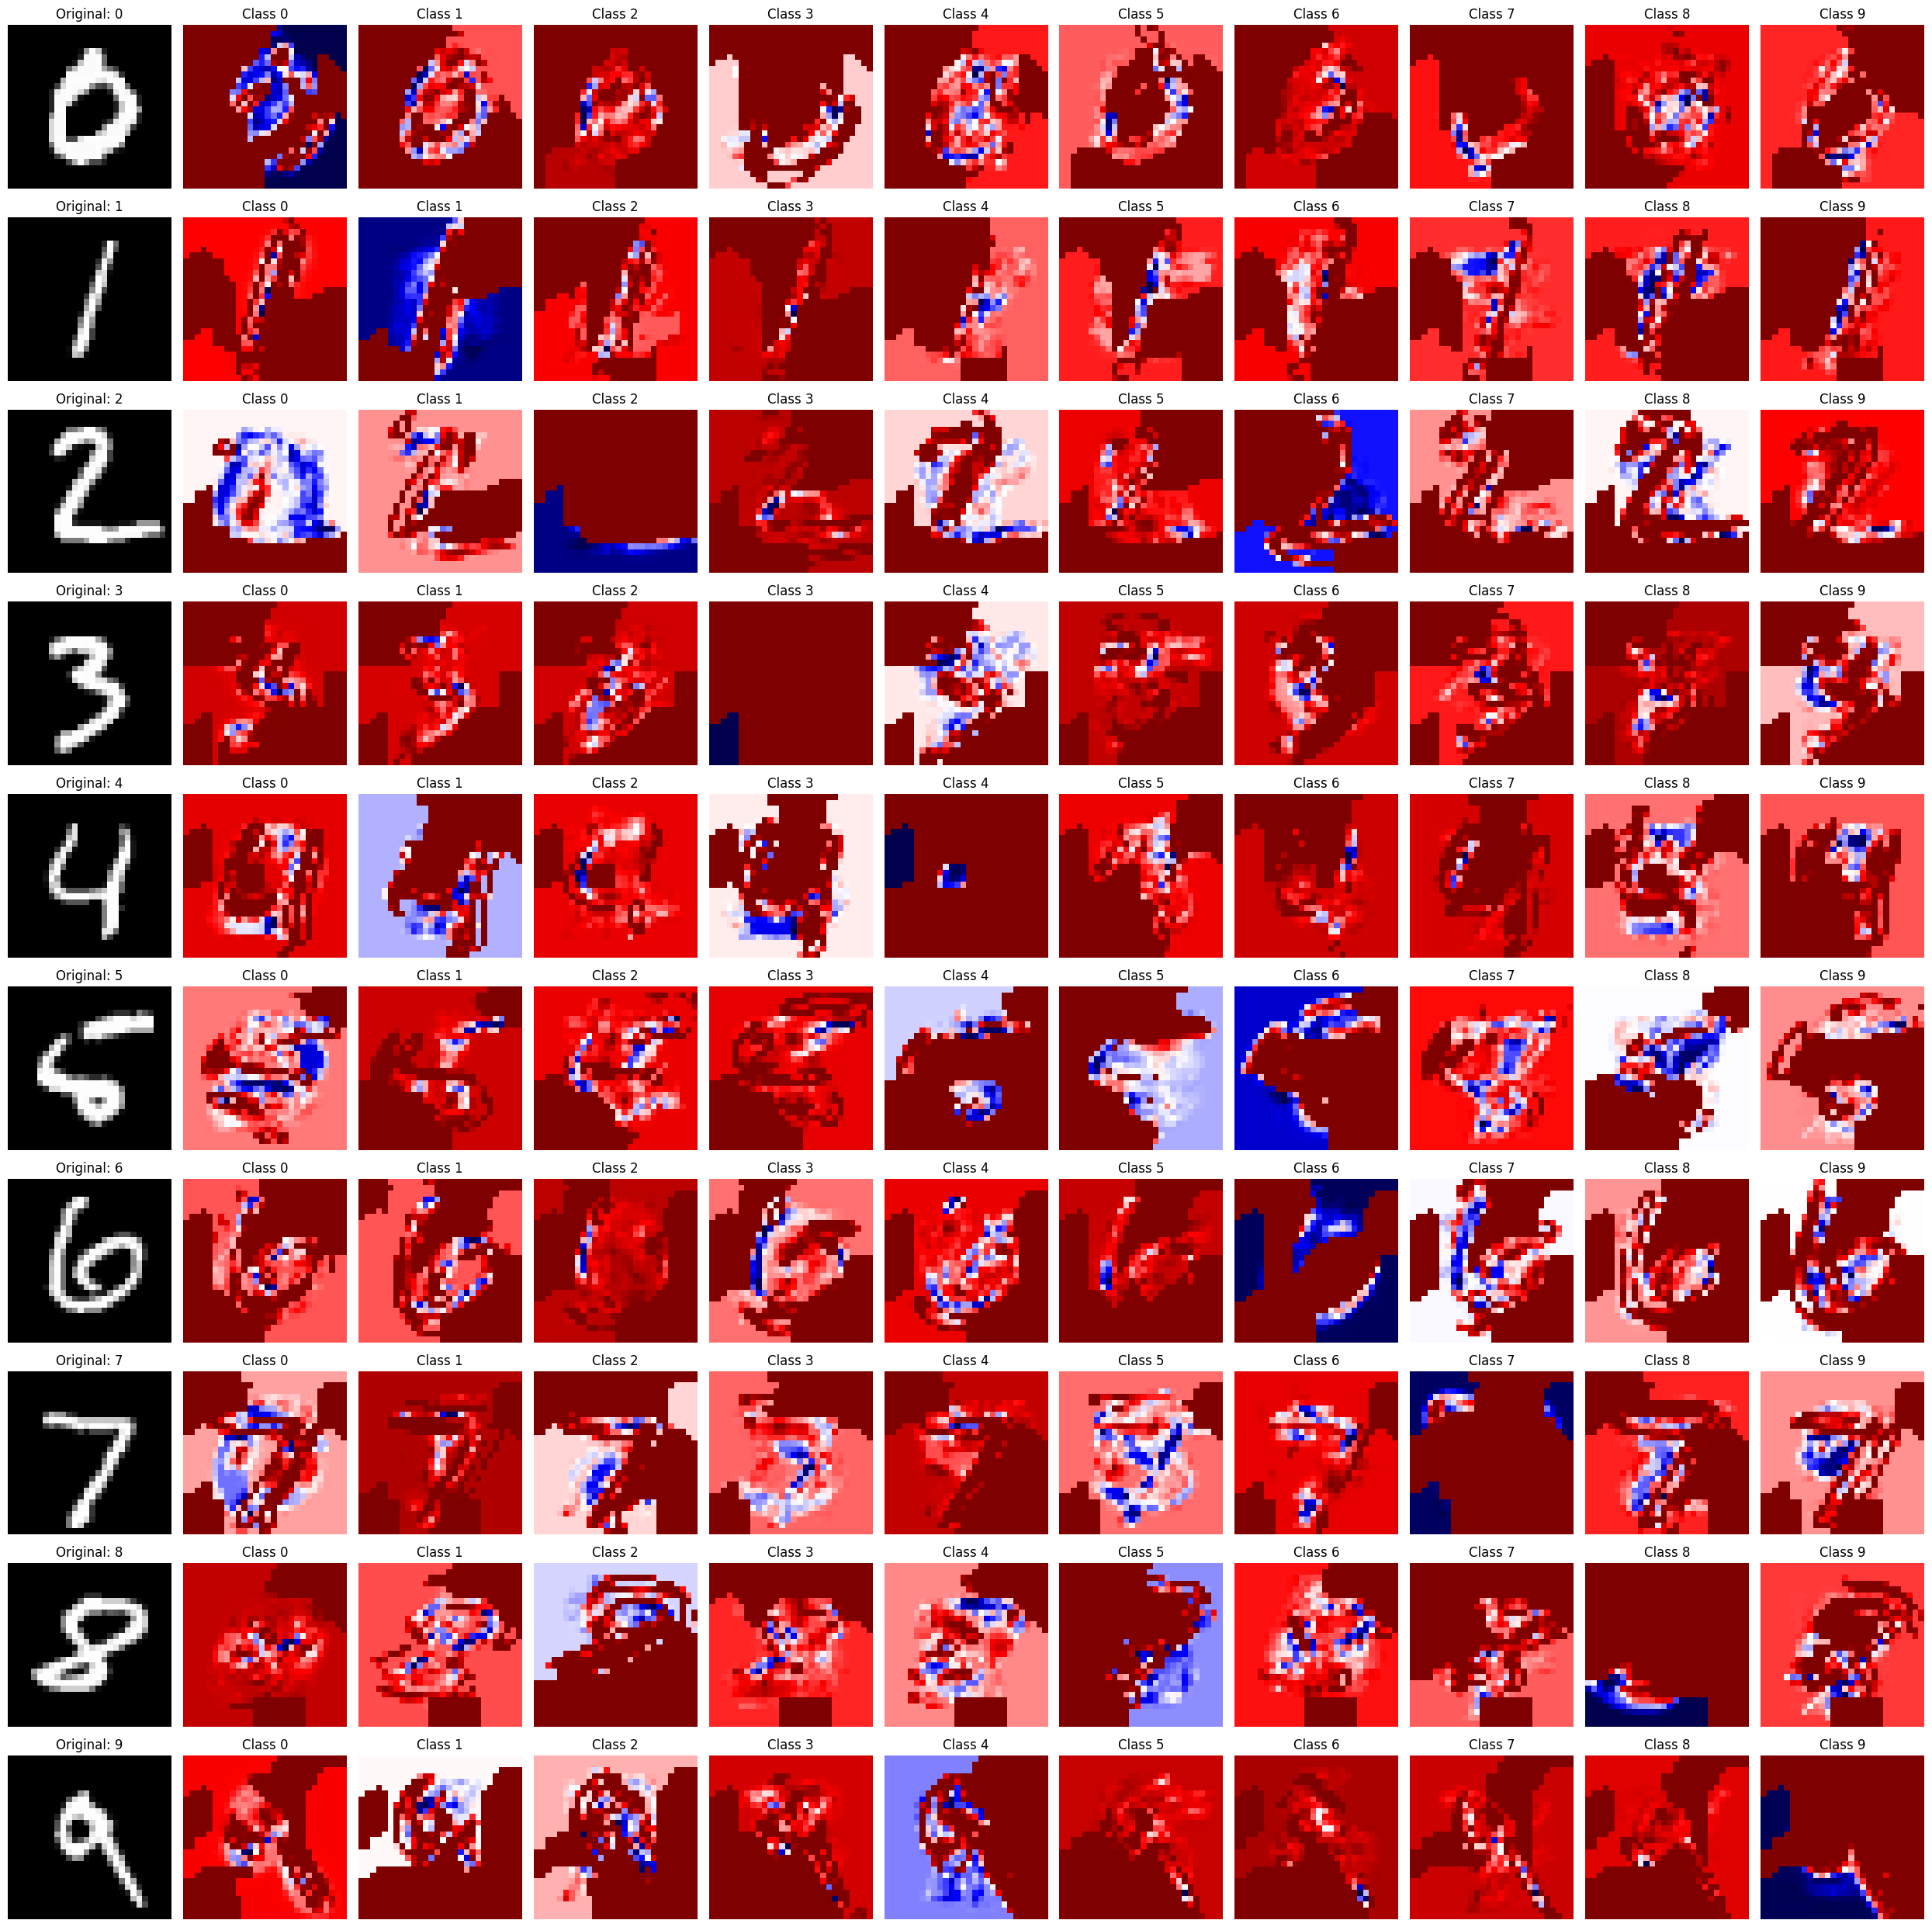

In [17]:
visualize_all_classes(max_explanations,x_selected, y_selected)

In [18]:
def calculate_lse_per_image(integrated_explanations, y_selected):
    """
    Calculates the LSE value for each image based on the integrated heatmaps and the selected class.

    Args:
        integrated_explanations (list of list): List of integrated heatmaps (10 images, 10 classes, 28, 28).
        y_selected (list of int): List of selected classes for each image (10 values, one per image).

    Returns:
        lse_values (list of float): List of calculated LSE values for the 10 images.
    """
    lse_values = []

    for image_idx, class_idx in enumerate(y_selected):
        # Get the integrated map for the selected class of this image
        image_map = integrated_explanations[image_idx]  # Dimensions: (10, 28, 28)

        # Calculate the LSE value for this image and class
        lse_value = lse_calculate(image_map, class_idx, 0.85)

        # Store the LSE value
        lse_values.append(lse_value)

        # Print calculation details
        print(f"Image {image_idx + 1}, Class {class_idx}: LSE Value: {lse_value:.4f}")

    return lse_values

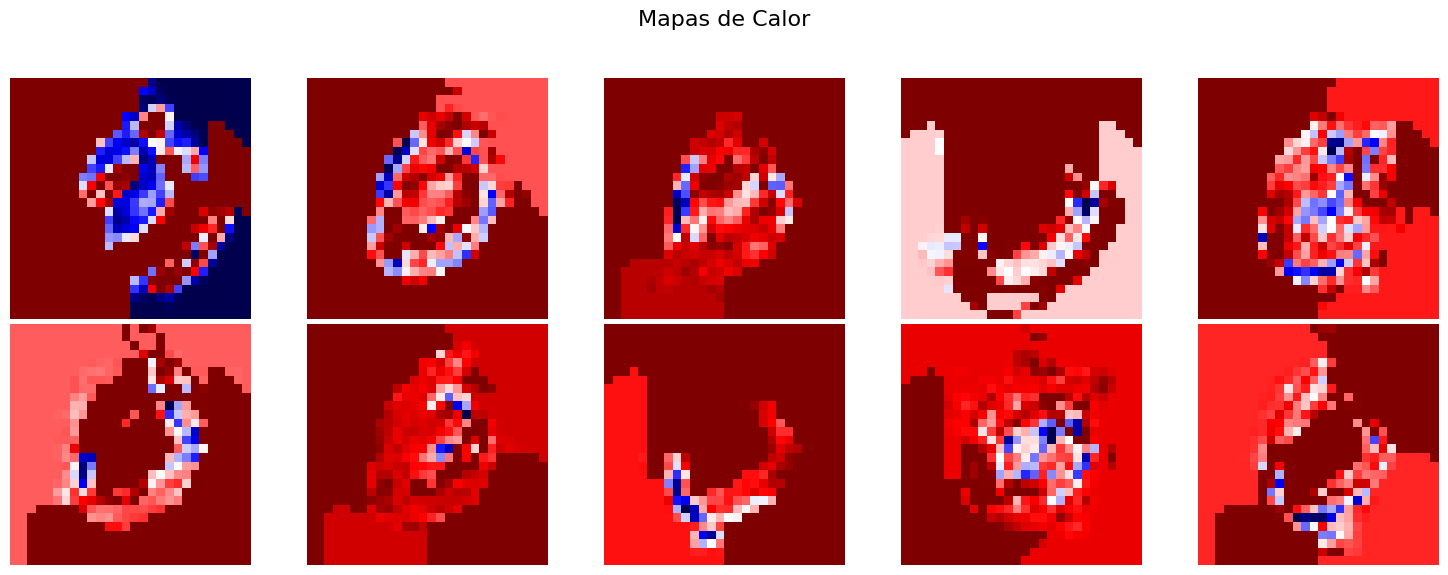

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 1.0, Min: 0.08934108167886734
Mapa 1: Max: 1.0, Min: 0.563485561443267
Mapa 2: Max: 1.0, Min: 0.3422459893048128
Mapa 3: Max: 1.0, Min: 0.6069167406938949
Mapa 4: Max: 1.0, Min: 0.48128342245989303
Mapa 5: Max: 1.0, Min: 0.3529411764705882
Mapa 6: Max: 1.0, Min: 0.4278074866310161
Mapa 7: Max: 1.0, Min: 0.08421915024518967
Mapa 8: Max: 1.0, Min: 0.330051451921463
Mapa 9: Max: 1.0, Min: 0.4955403618587871
Cantidad de rasgos mayores que 0.85: 487
Indices mayores que 0.85: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  56  57  58  59  60
  61  62  63  64  65  66  67  68  69  70  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98 112 113 114 115 116 117 118 

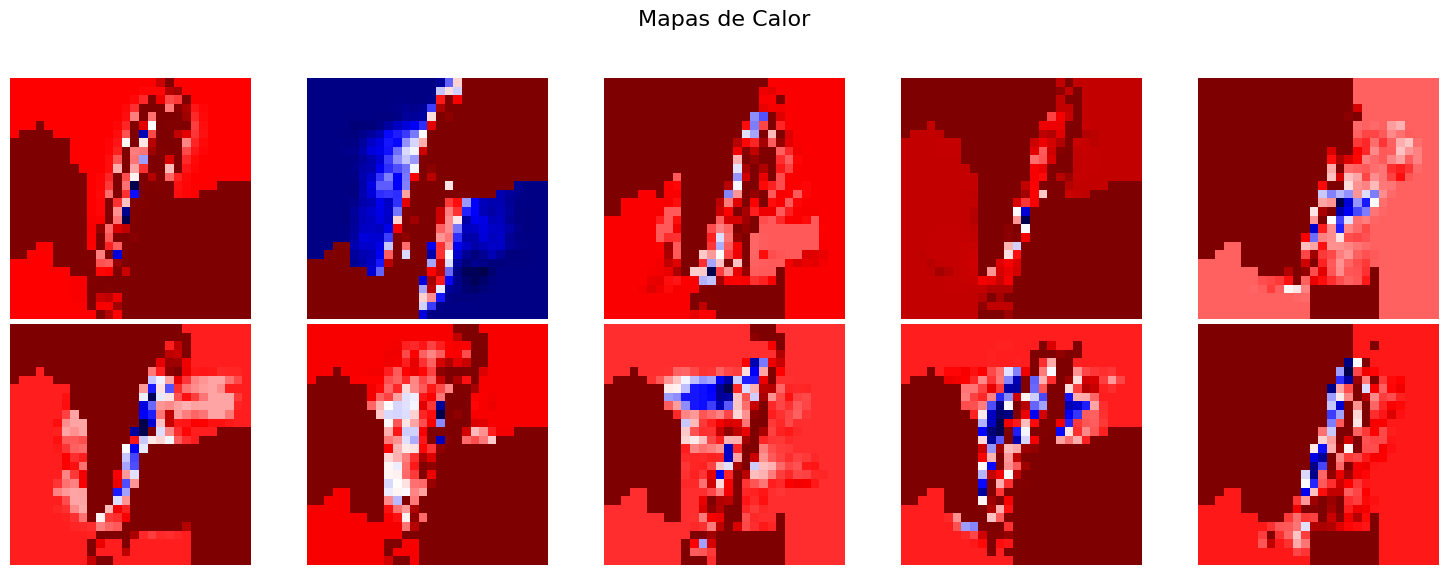

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 1.0, Min: 0.5900506377220154
Mapa 1: Max: 1.0, Min: 0.04600983566202688
Mapa 2: Max: 1.0, Min: 0.3422459893048128
Mapa 3: Max: 1.0, Min: 0.1750255525112152
Mapa 4: Max: 1.0, Min: 0.21925133689839577
Mapa 5: Max: 1.0, Min: 0.4278074866310161
Mapa 6: Max: 1.0, Min: 0.4539467919894535
Mapa 7: Max: 1.0, Min: 0.3850267379679144
Mapa 8: Max: 1.0, Min: 0.5544986128807068
Mapa 9: Max: 1.0, Min: 0.28074866310160423
Cantidad de rasgos mayores que 0.85: 302
Indices mayores que 0.85: [ 18  19  20  21  22  23  24  25  26  27  46  47  48  49  50  51  52  53
  54  55  72  74  75  76  77  78  79  80  81  82  83  99 100 101 102 103
 104 105 106 107 108 109 110 111 127 128 129 130 131 132 133 134 135 136
 137 138 139 155 156 157 158 159 160 161 162 163 164 16

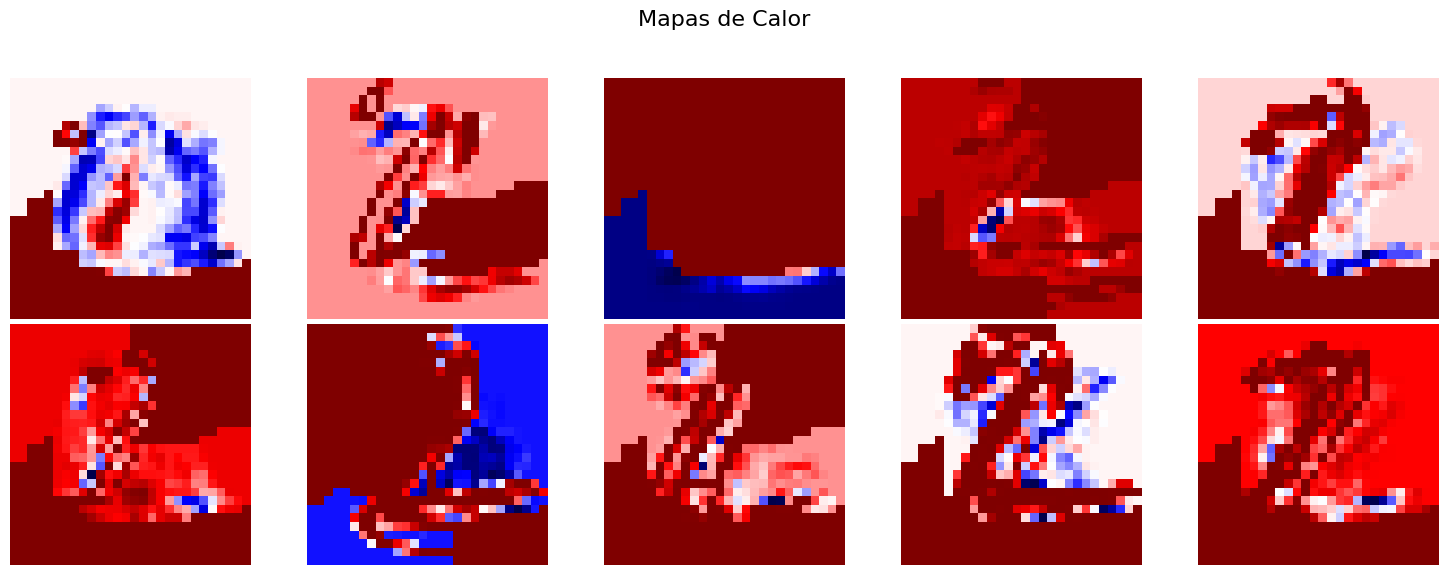

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 1.0, Min: 0.4050983786582947
Mapa 1: Max: 1.0, Min: 0.3422459893048128
Mapa 2: Max: 1.0, Min: 0.2055209000928633
Mapa 3: Max: 1.0, Min: 0.20588235294117646
Mapa 4: Max: 1.0, Min: 0.2503109574317932
Mapa 5: Max: 1.0, Min: 0.15775401069518716
Mapa 6: Max: 1.0, Min: 0.42778392123656633
Mapa 7: Max: 1.0, Min: 0.3480455279350281
Mapa 8: Max: 1.0, Min: 0.6310160427807486
Mapa 9: Max: 1.0, Min: 0.23799185454845428
Cantidad de rasgos mayores que 0.85: 585
Indices mayores que 0.85: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  

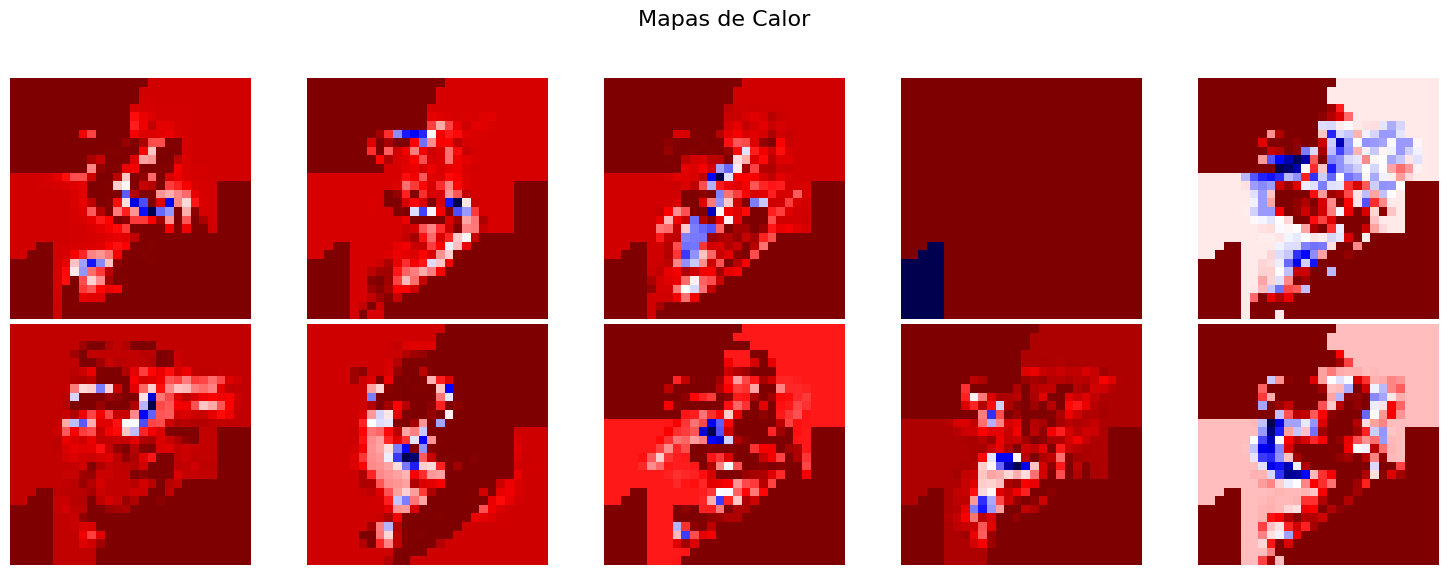

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 1.0, Min: 0.4216799736022949
Mapa 1: Max: 1.0, Min: 0.24720434844493866
Mapa 2: Max: 1.0, Min: 0.39572192513368987
Mapa 3: Max: 1.0, Min: 0.1626066012094775
Mapa 4: Max: 1.0, Min: 0.2895505428314209
Mapa 5: Max: 1.0, Min: 0.20588235294117646
Mapa 6: Max: 1.0, Min: 0.3378123342990875
Mapa 7: Max: 1.0, Min: 0.22670528292655945
Mapa 8: Max: 1.0, Min: 0.2310096248280736
Mapa 9: Max: 1.0, Min: 0.30481283422459887
Cantidad de rasgos mayores que 0.85: 744
Indices mayores que 0.85: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66 

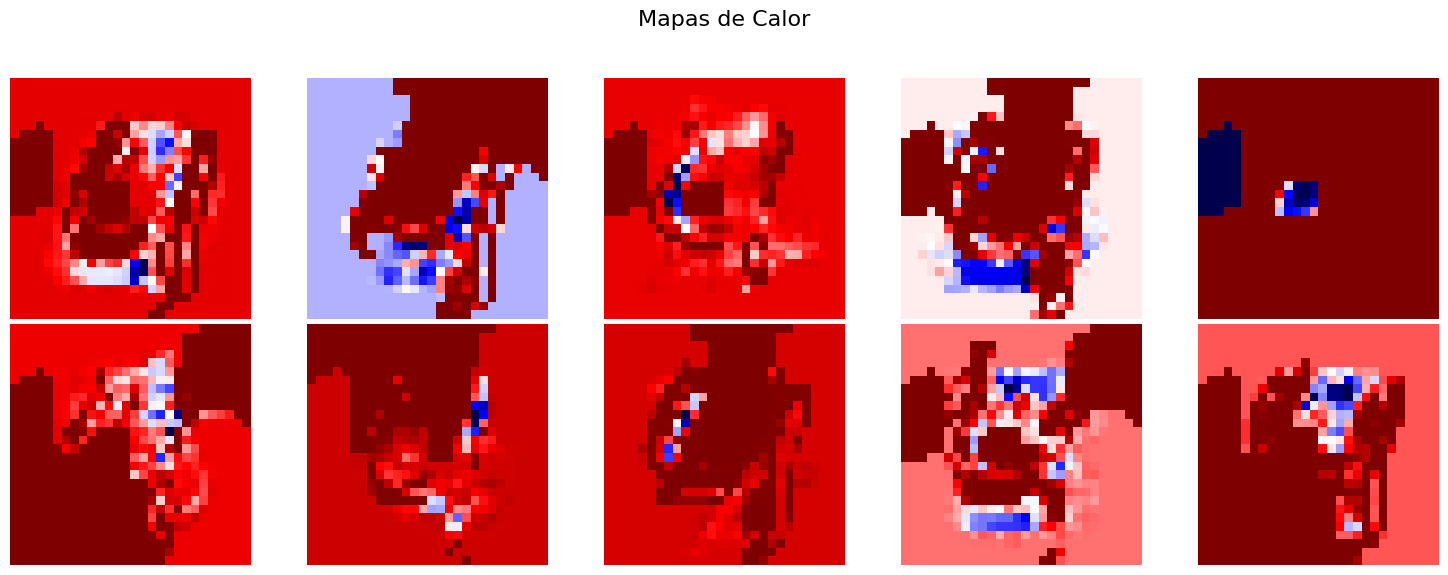

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 1.0, Min: 0.31196403164846087
Mapa 1: Max: 1.0, Min: 0.6147213558105079
Mapa 2: Max: 1.0, Min: 0.17112299465240638
Mapa 3: Max: 1.0, Min: 0.625179648399353
Mapa 4: Max: 1.0, Min: 0.12161425697514587
Mapa 5: Max: 1.0, Min: 0.4591744196726303
Mapa 6: Max: 1.0, Min: 0.049788378179073334
Mapa 7: Max: 1.0, Min: 0.38770053475935834
Mapa 8: Max: 1.0, Min: 0.30317538975102126
Mapa 9: Max: 1.0, Min: 0.2940611955541374
Cantidad de rasgos mayores que 0.85: 717
Indices mayores que 0.85: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66

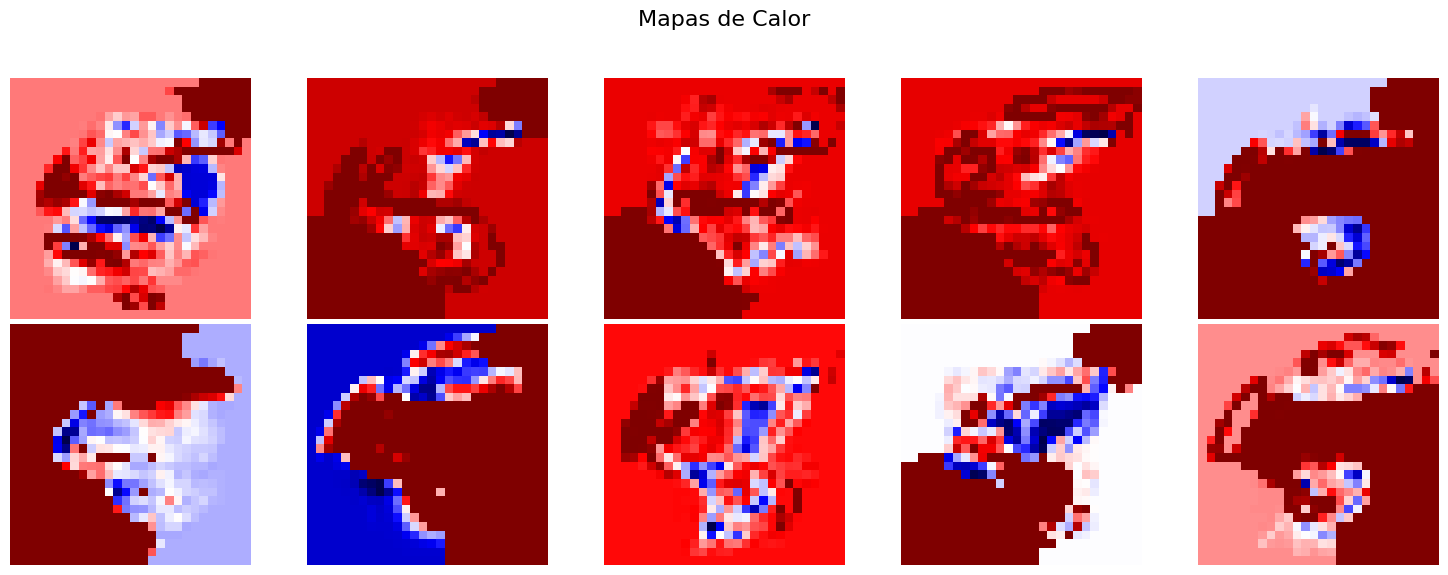

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 1.0, Min: 0.3117990701535203
Mapa 1: Max: 1.0, Min: 0.24139760434627533
Mapa 2: Max: 1.0, Min: 0.4992504119873047
Mapa 3: Max: 1.0, Min: 0.2804975211620331
Mapa 4: Max: 1.0, Min: 0.44115804784809826
Mapa 5: Max: 1.0, Min: 0.09037181735038757
Mapa 6: Max: 1.0, Min: 0.15243948996067047
Mapa 7: Max: 1.0, Min: 0.474678635597229
Mapa 8: Max: 1.0, Min: 0.35904788970947266
Mapa 9: Max: 1.0, Min: 0.37433155080213903
Cantidad de rasgos mayores que 0.85: 414
Indices mayores que 0.85: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  28  29  30  31  32  33  34  35  36  37  38  39  40  41
  42  43  44  45  46  47  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  73  74  75  84  85  86  87  88 

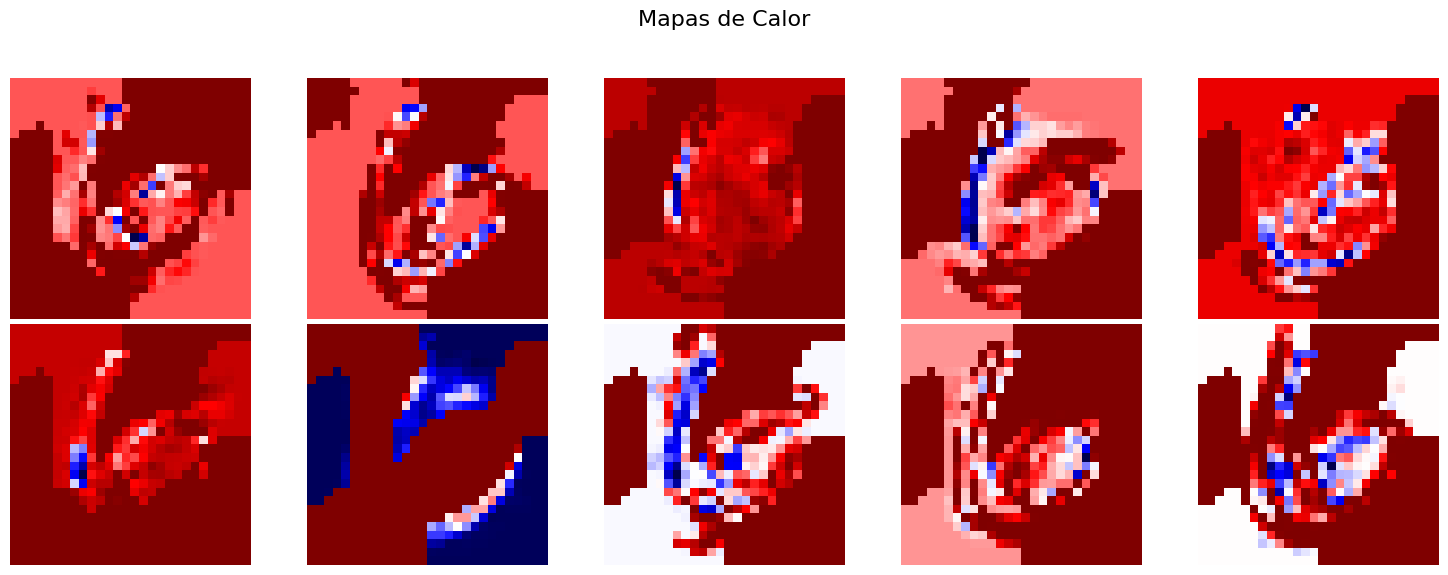

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 1.0, Min: 0.3243415057659149
Mapa 1: Max: 1.0, Min: 0.47058823529411764
Mapa 2: Max: 1.0, Min: 0.12032085561497327
Mapa 3: Max: 1.0, Min: 0.14705882352941174
Mapa 4: Max: 1.0, Min: 0.2547744810581207
Mapa 5: Max: 1.0, Min: 0.07332507520914078
Mapa 6: Max: 1.0, Min: 0.2370515730914387
Mapa 7: Max: 1.0, Min: 0.3409349152558864
Mapa 8: Max: 1.0, Min: 0.44519322831390307
Mapa 9: Max: 1.0, Min: 0.4227039748583526
Cantidad de rasgos mayores que 0.85: 456
Indices mayores que 0.85: [  0   1   2   3   4   5   6   7   8   9  10  11  12  28  29  30  31  32
  33  34  35  36  37  38  39  40  56  57  58  59  60  61  62  63  64  65
  66  67  68  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94
  95  96  97 107 108 109 110 111 112 113 114 115 116 

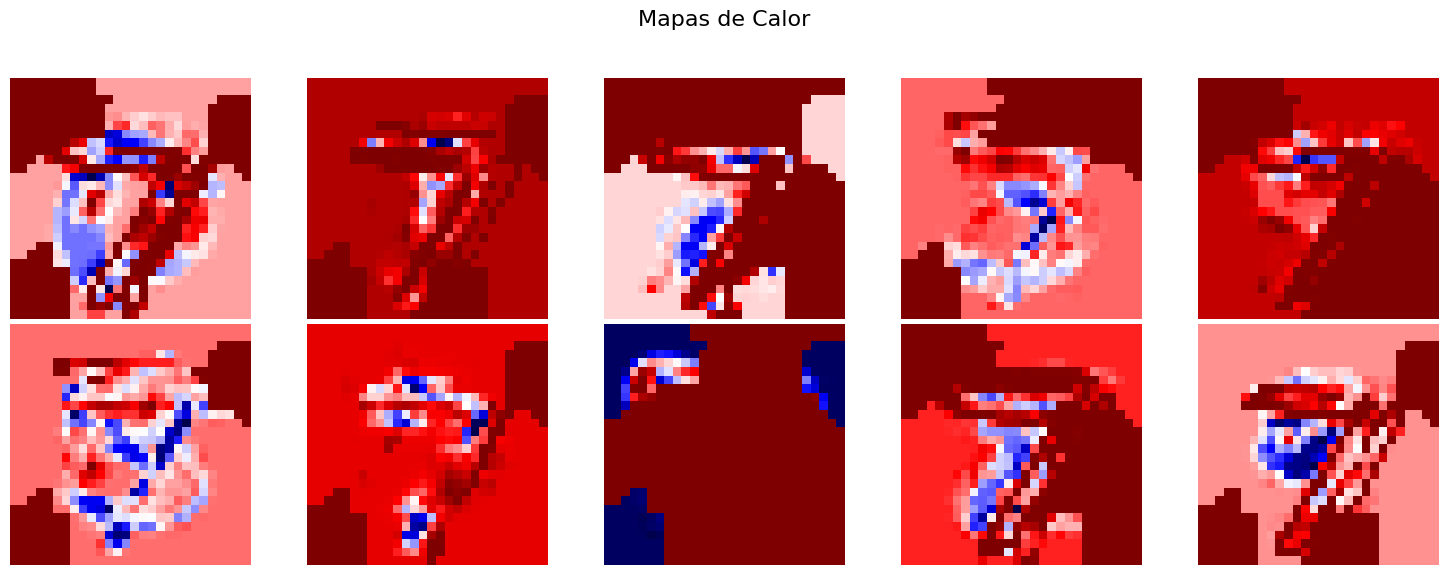

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 1.0, Min: 0.47058823529411764
Mapa 1: Max: 1.0, Min: 0.5219683299277105
Mapa 2: Max: 1.0, Min: 0.2871755361557007
Mapa 3: Max: 1.0, Min: 0.15775401069518716
Mapa 4: Max: 1.0, Min: 0.4411764705882353
Mapa 5: Max: 1.0, Min: 0.48128342245989303
Mapa 6: Max: 1.0, Min: 0.44703102111816406
Mapa 7: Max: 1.0, Min: 0.10239596629614768
Mapa 8: Max: 1.0, Min: 0.3204831355214227
Mapa 9: Max: 1.0, Min: 0.4134270548285937
Cantidad de rasgos mayores que 0.85: 609
Indices mayores que 0.85: [ 10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  68  69  70  71  72  73  74  75  76  77  78  79  95  96  97  98  99 100
 101 102 103 104 105 106 123 124 125 126 127 128 129 

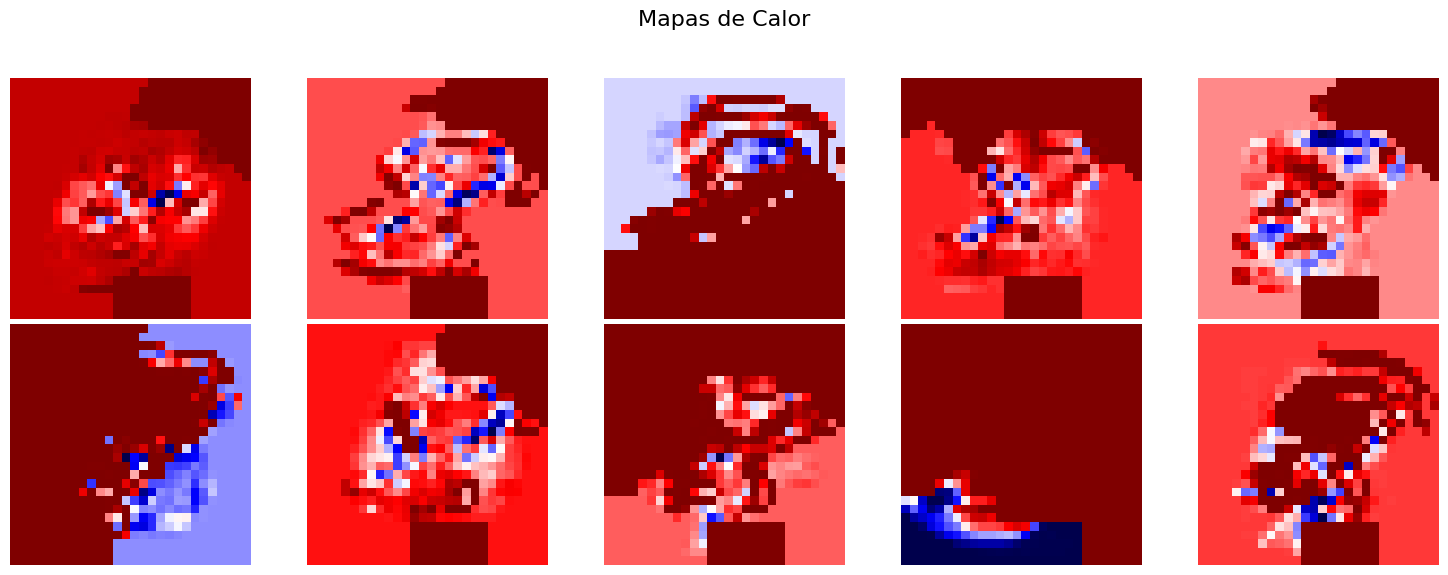

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 1.0, Min: 0.21925133689839577
Mapa 1: Max: 1.0, Min: 0.4491978609625668
Mapa 2: Max: 1.0, Min: 0.49562686370630554
Mapa 3: Max: 1.0, Min: 0.3422459893048128
Mapa 4: Max: 1.0, Min: 0.31550802139037437
Mapa 5: Max: 1.0, Min: 0.6521515504878231
Mapa 6: Max: 1.0, Min: 0.40641711229946526
Mapa 7: Max: 1.0, Min: 0.5026737967914439
Mapa 8: Max: 1.0, Min: 0.14365984743291862
Mapa 9: Max: 1.0, Min: 0.497008478506179
Cantidad de rasgos mayores que 0.85: 644
Indices mayores que 0.85: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  

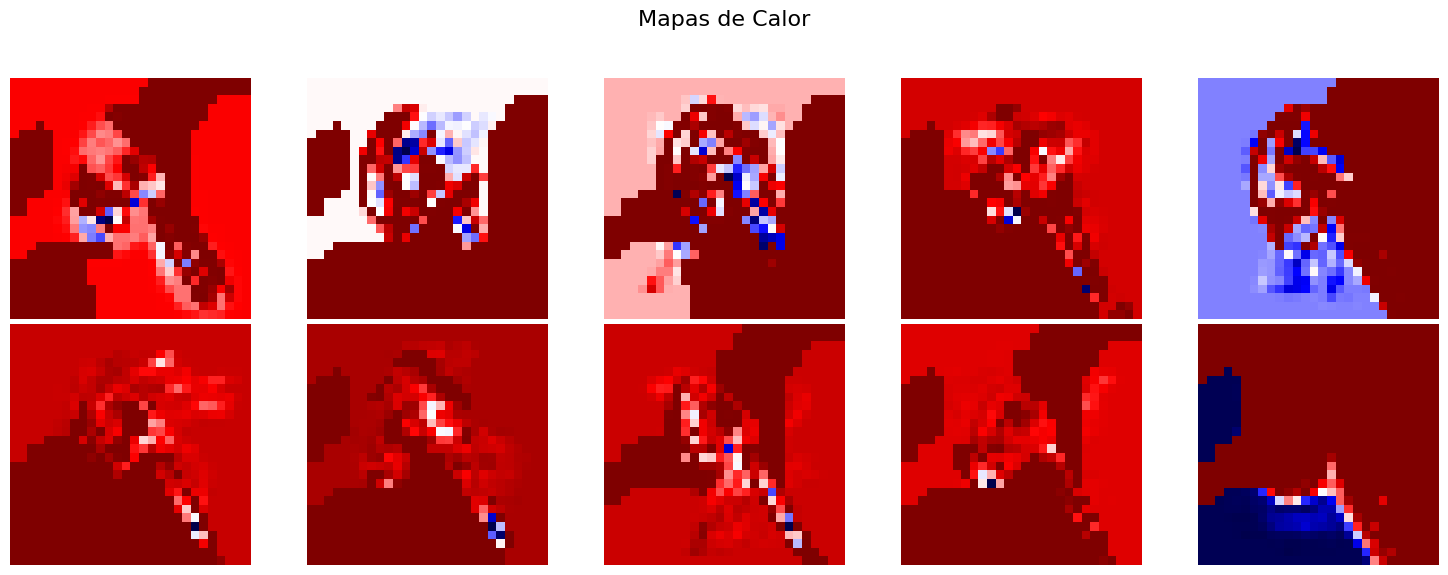

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 1.0, Min: 0.40641711229946526
Mapa 1: Max: 1.0, Min: 0.5013570785522461
Mapa 2: Max: 1.0, Min: 0.7023894190788269
Mapa 3: Max: 1.0, Min: 0.5401069518716579
Mapa 4: Max: 1.0, Min: 0.4900180899415605
Mapa 5: Max: 1.0, Min: 0.17112299465240638
Mapa 6: Max: 1.0, Min: 0.18951109051704407
Mapa 7: Max: 1.0, Min: 0.3663792014122009
Mapa 8: Max: 1.0, Min: 0.2433155080213904
Mapa 9: Max: 1.0, Min: 0.07513196679240791
Cantidad de rasgos mayores que 0.85: 574
Indices mayores que 0.85: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  

In [19]:
# Calculate LSE values using the integrated maps
lse_values_max = calculate_lse_per_image(integrated_explanations=max_explanations, y_selected=y_selected)

##MIN

In [20]:
def calculate_min_per_pixel(explanations_data):
    """
    Calculates the pixel-wise minimum across all explanations for each image and class.
    """
    num_images = len(explanations_data[0]['explanations'])  # Number of images (10)
    num_classes = len(explanations_data[0]['explanations'][0])  # Number of classes (10)
    integrated_explanations = []  # To store the integrated results

    for image_idx in range(num_images):  # Iterate through each image
        print(f"\nProcessing image {image_idx + 1}/{num_images}...")
        image_maps = []  # Integrated maps per class for this image

        for class_idx in range(num_classes):  # Iterate through each class
            print(f"  Class {class_idx + 1}/{num_classes}:")

            # Collect heatmaps from the 4 methods for the same image and class
            class_maps = []
            for method_idx in range(len(explanations_data)):  # len(explanations_data) == 4
                map_ = explanations_data[method_idx]['explanations'][image_idx][class_idx]
                single_channel_map = ensure_single_channel(map_)
                normalized_map = normalize_map(single_channel_map)

                class_maps.append(normalized_map)
                print(f"    Method {method_idx + 1}: Shape: {normalized_map.shape}")

            # Convert the maps to a NumPy array (dimensions: (4, 28, 28))
            stacked_maps = np.stack(class_maps, axis=0)

            # Calculate the pixel-wise minimum along axis 0 (across the 4 methods)
            min_map = np.min(stacked_maps, axis=0)  # Dimensions: (28, 28)

            print(f"    Integrated map: Shape: {min_map.shape}, "
                  f"Min: {np.min(min_map):.4f}, Max: {np.max(min_map):.4f}")

            # Save the integrated map per class
            image_maps.append(min_map)

        integrated_explanations.append(image_maps)

    return integrated_explanations


Processing image 1/10...
  Class 1/10:
    Method 1: Shape: (28, 28)
    Method 2: Shape: (28, 28)
    Method 3: Shape: (28, 28)
    Method 4: Shape: (28, 28)
    Integrated map: Shape: (28, 28), Min: 0.0000, Max: 0.8885
  Class 2/10:
    Method 1: Shape: (28, 28)
    Method 2: Shape: (28, 28)
    Method 3: Shape: (28, 28)
    Method 4: Shape: (28, 28)
    Integrated map: Shape: (28, 28), Min: 0.0000, Max: 0.8584
  Class 3/10:
    Method 1: Shape: (28, 28)
    Method 2: Shape: (28, 28)
    Method 3: Shape: (28, 28)
    Method 4: Shape: (28, 28)
    Integrated map: Shape: (28, 28), Min: 0.0000, Max: 0.8974
  Class 4/10:
    Method 1: Shape: (28, 28)
    Method 2: Shape: (28, 28)
    Method 3: Shape: (28, 28)
    Method 4: Shape: (28, 28)
    Integrated map: Shape: (28, 28), Min: 0.0000, Max: 0.8889
  Class 5/10:
    Method 1: Shape: (28, 28)
    Method 2: Shape: (28, 28)
    Method 3: Shape: (28, 28)
    Method 4: Shape: (28, 28)
    Integrated map: Shape: (28, 28), Min: 0.0000, Max: 0

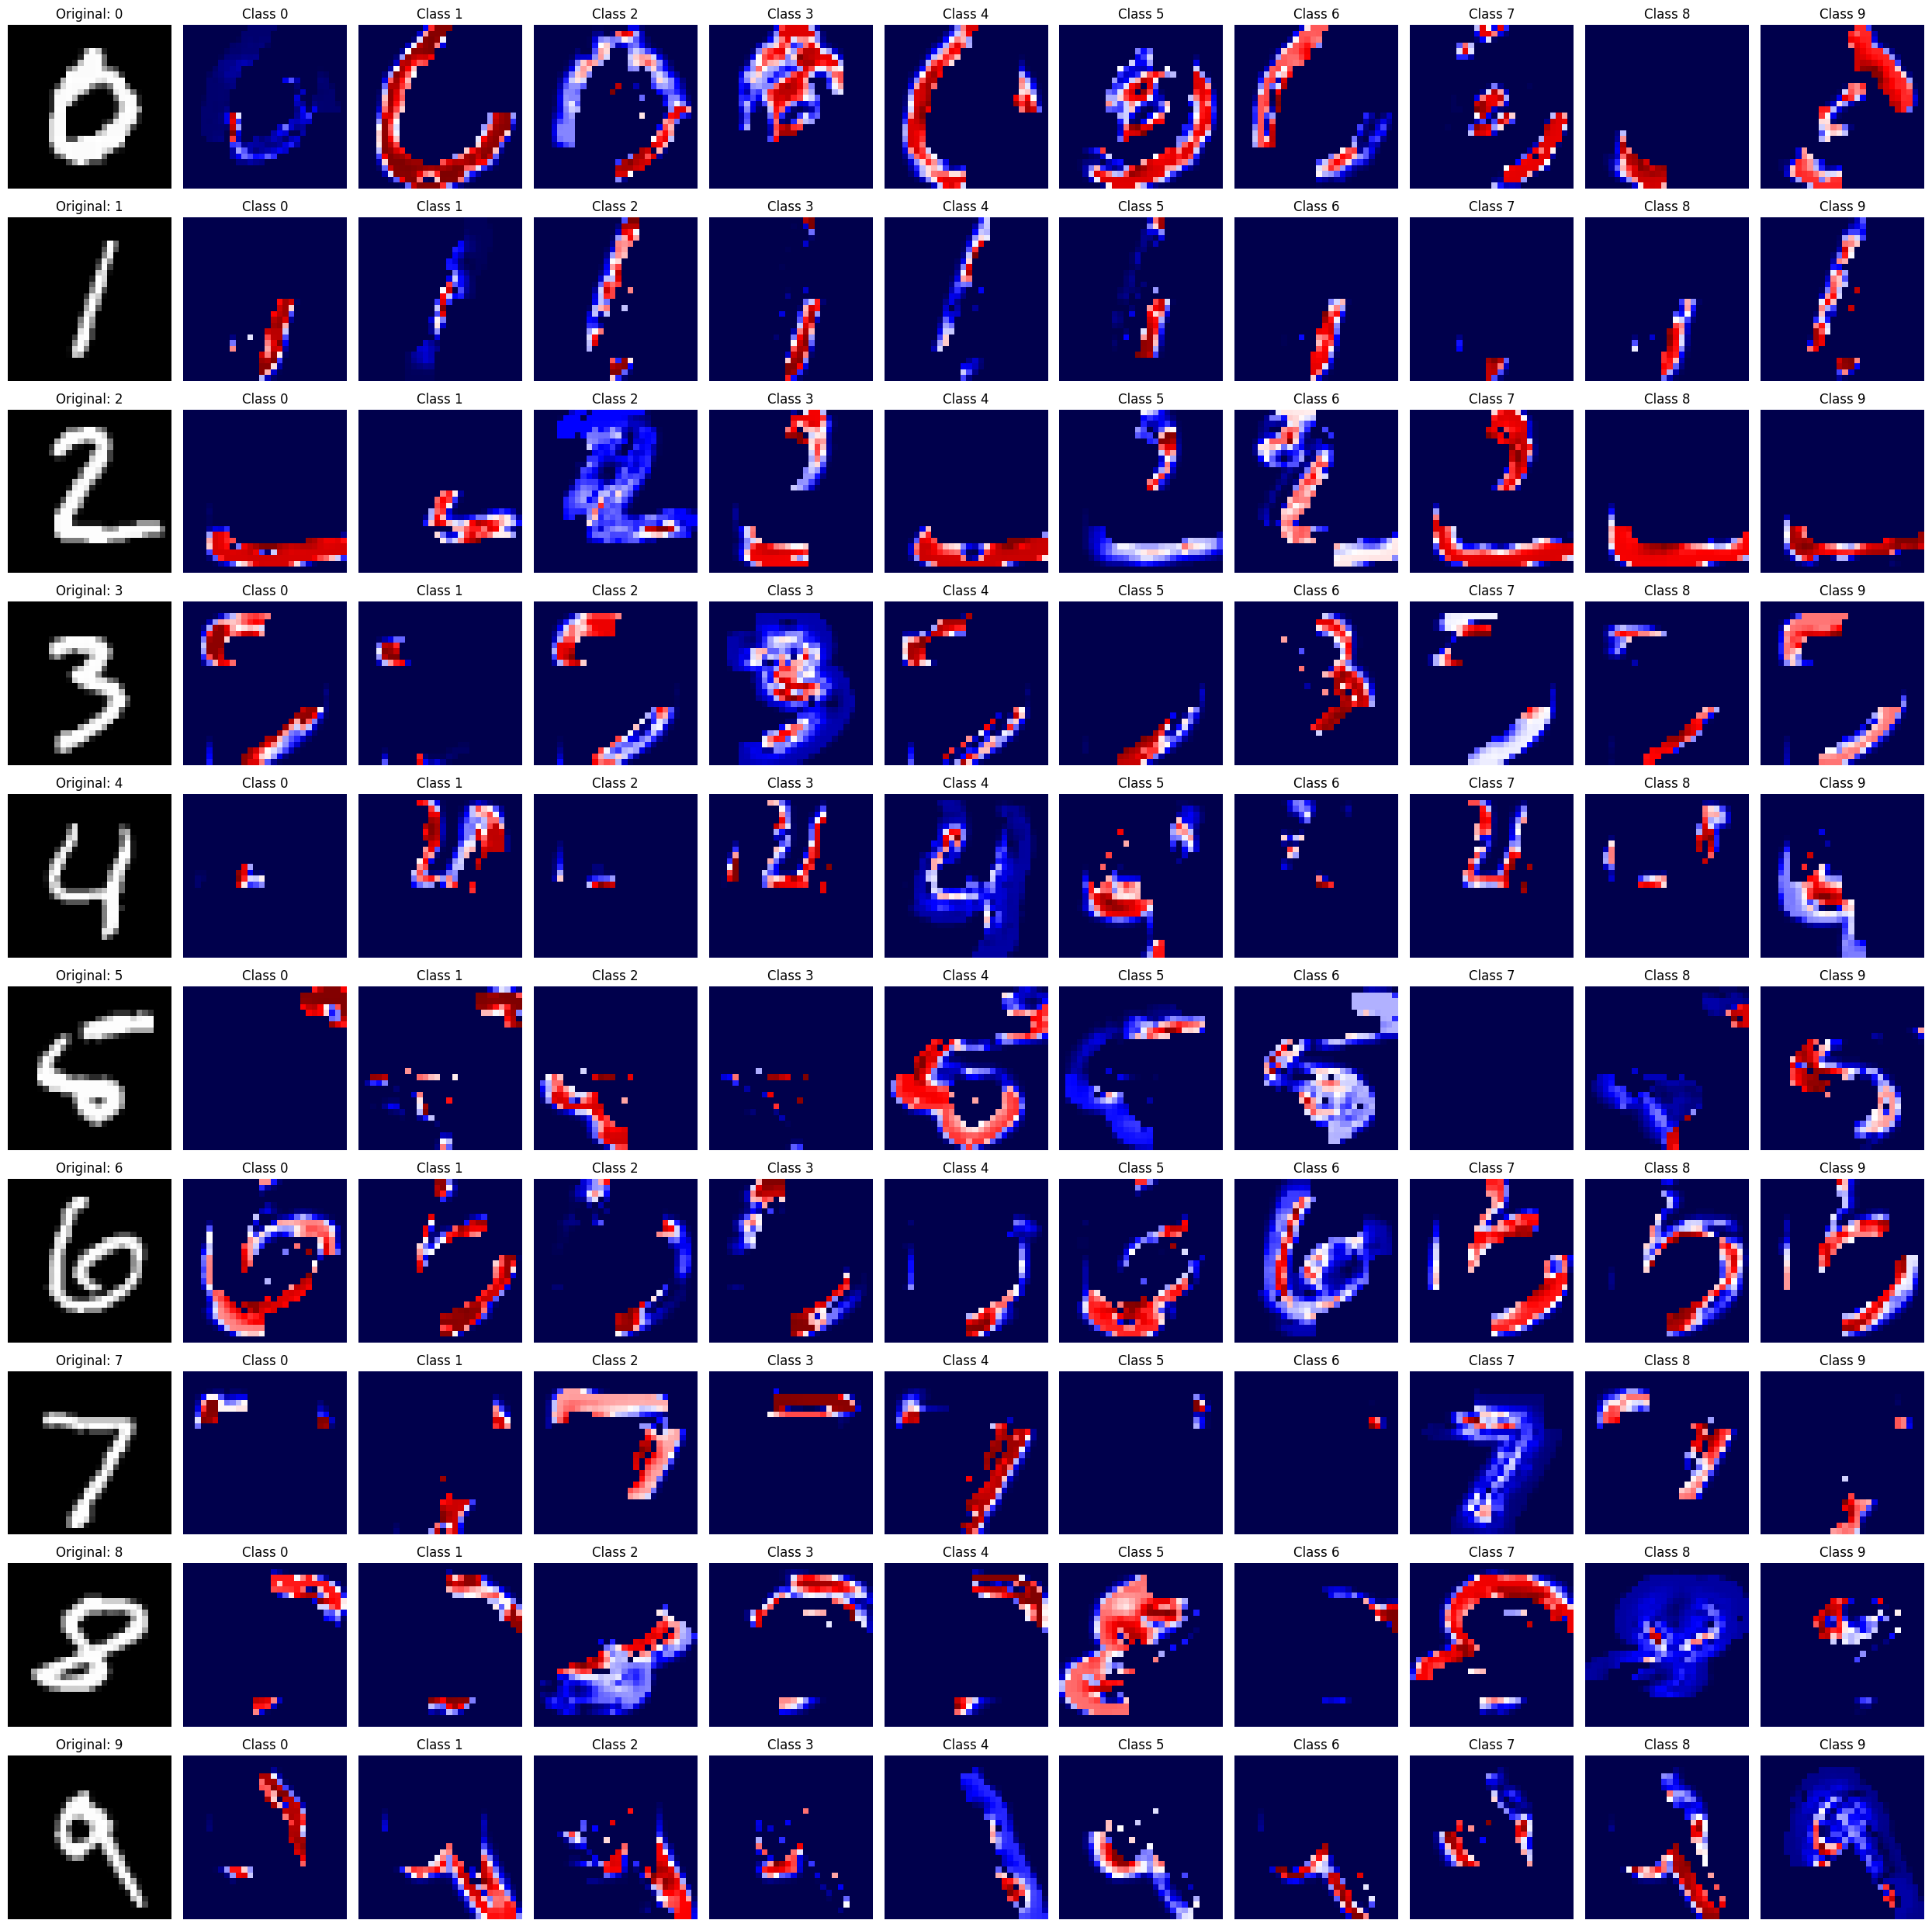

In [21]:
# Calculate integrated maps using min
min_explanations = calculate_min_per_pixel(new_explanations_data)
visualize_all_classes(min_explanations, x_selected, y_selected)

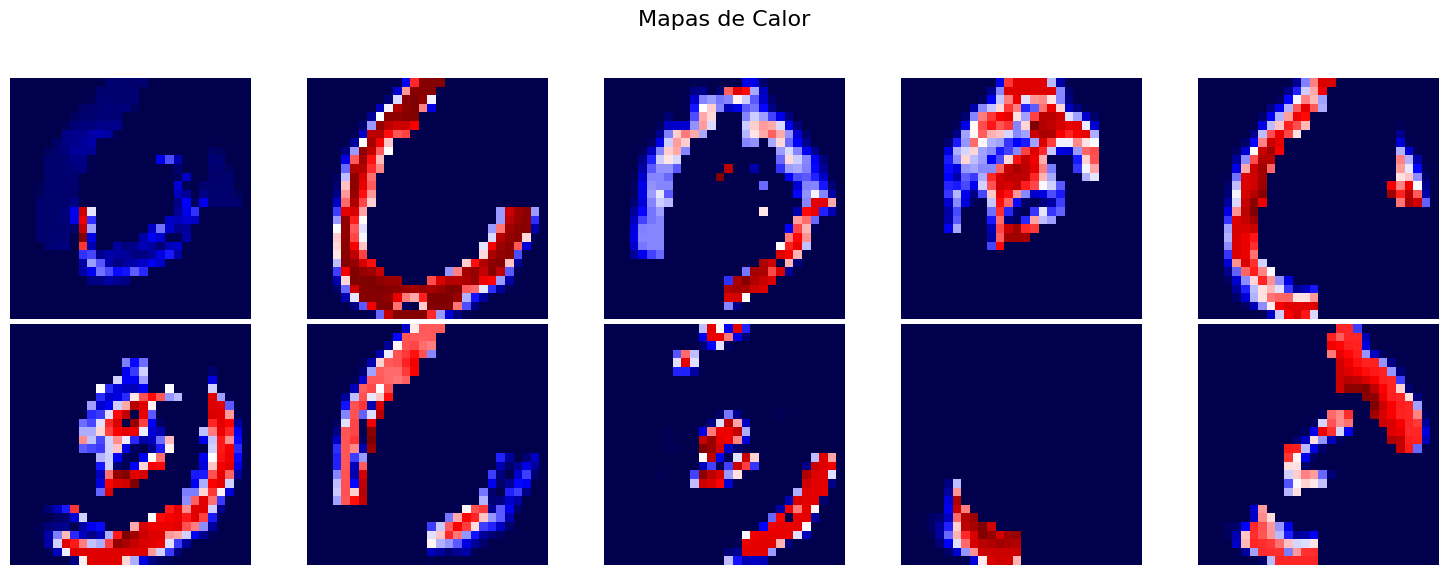

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 0.8884629011154175, Min: 0.0
Mapa 1: Max: 0.8583616018295288, Min: 0.0
Mapa 2: Max: 0.8974012136459351, Min: 0.0
Mapa 3: Max: 0.8889239670180293, Min: 0.0
Mapa 4: Max: 0.8079016804695129, Min: 0.0
Mapa 5: Max: 0.7507686018943787, Min: 0.0
Mapa 6: Max: 0.861624538898468, Min: 0.0
Mapa 7: Max: 0.7272727272727273, Min: 0.0
Mapa 8: Max: 0.8612141799114224, Min: 0.0
Mapa 9: Max: 0.8644222254043437, Min: 0.0
Cantidad de rasgos mayores que 0.85: 1
Indices mayores que 0.85: [512]
Suma clase objetivo: 0.8884629011154175
Suma de otras clases: 0.0
IFI calculado: 7.996166110038757
Image 1, Class 0: LSE Value: 7.9962


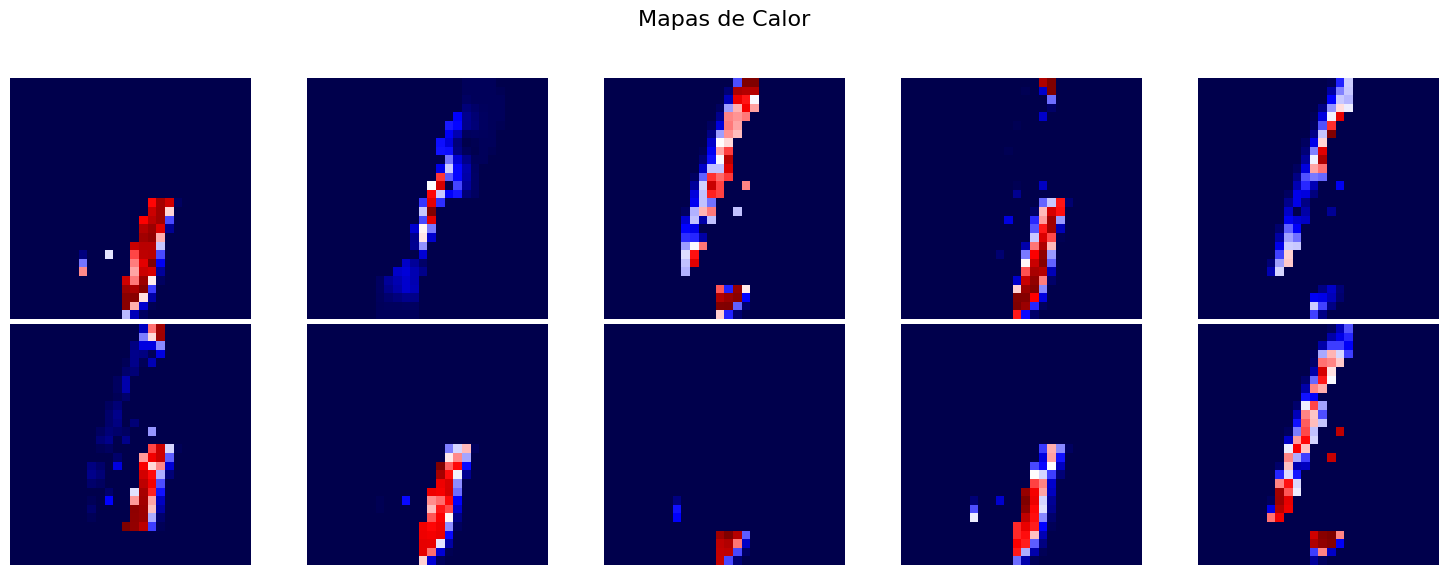

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 0.8678492367485099, Min: 0.0
Mapa 1: Max: 1.0, Min: 0.0
Mapa 2: Max: 0.7772602438926697, Min: 0.0
Mapa 3: Max: 0.8856745362281799, Min: 0.0
Mapa 4: Max: 0.772513446707053, Min: 0.0
Mapa 5: Max: 0.8187082409858704, Min: 0.0
Mapa 6: Max: 0.8824830651283264, Min: 0.0
Mapa 7: Max: 0.638821005821228, Min: 0.0
Mapa 8: Max: 0.818111777305603, Min: 0.0
Mapa 9: Max: 0.5521610975265503, Min: 0.0
Cantidad de rasgos mayores que 0.85: 1
Indices mayores que 0.85: [434]
Suma clase objetivo: 1.0
Suma de otras clases: 0.0
IFI calculado: 9.0
Image 2, Class 1: LSE Value: 9.0000


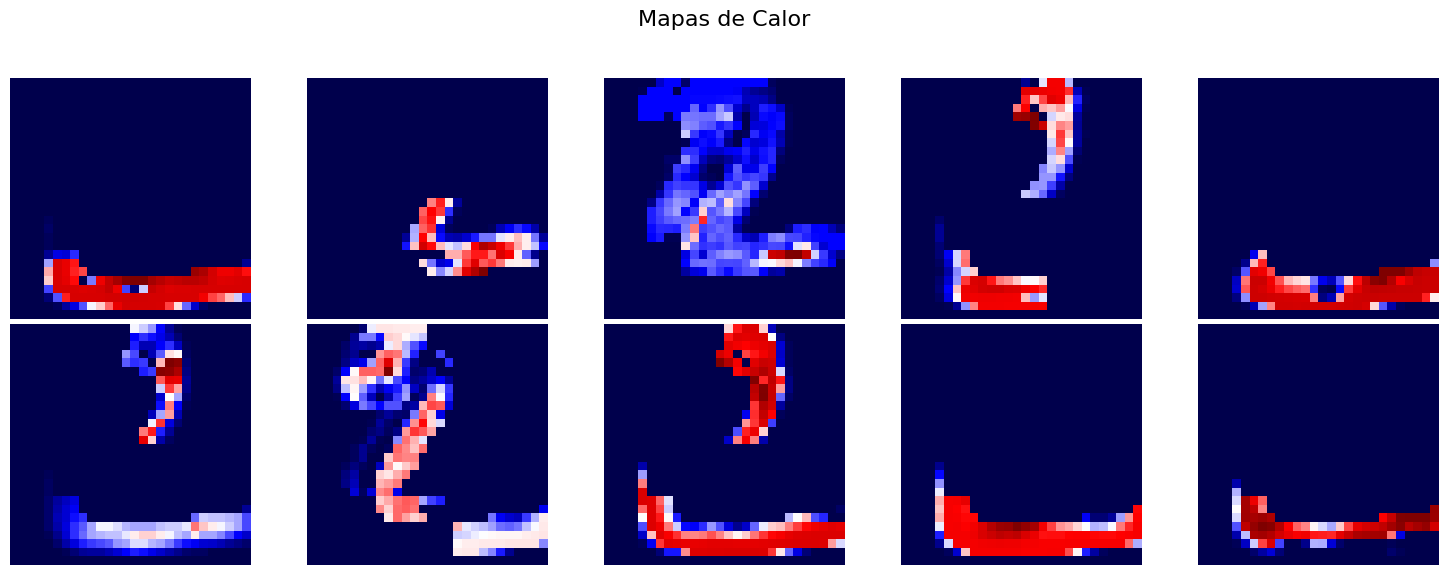

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 0.623376190662384, Min: 0.0
Mapa 1: Max: 0.6631016042780749, Min: 0.0
Mapa 2: Max: 0.9152897596359253, Min: 0.0
Mapa 3: Max: 0.8640584349632263, Min: 0.0
Mapa 4: Max: 0.6567058461524377, Min: 0.0
Mapa 5: Max: 0.826985246852343, Min: 0.0
Mapa 6: Max: 0.8872061967849731, Min: 0.0
Mapa 7: Max: 0.6302537322044373, Min: 0.0
Mapa 8: Max: 0.524533748626709, Min: 0.0
Mapa 9: Max: 0.8094431757926941, Min: 0.0
Cantidad de rasgos mayores que 0.85: 2
Indices mayores que 0.85: [581 582]
Suma clase objetivo: 1.8249588012695312
Suma de otras clases: 0.9654715041842035
IFI calculado: 17.012028982982915
Image 3, Class 2: LSE Value: 17.0120


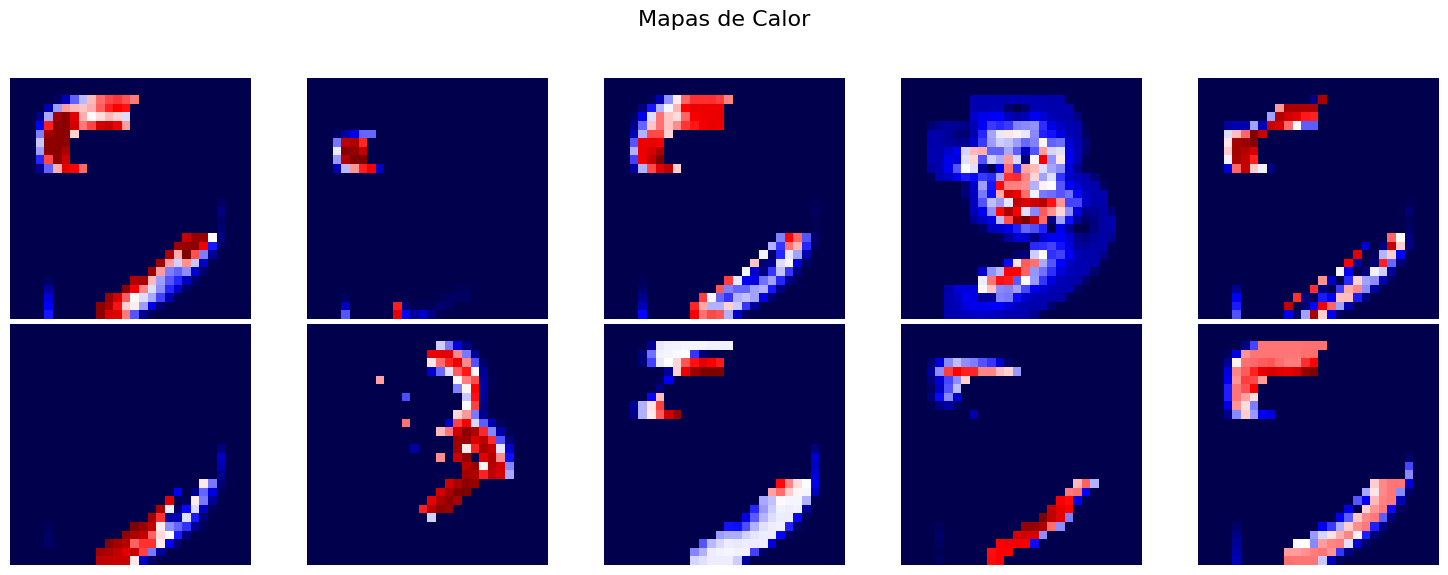

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 0.8454239663088493, Min: 0.0
Mapa 1: Max: 0.7287992238998413, Min: 0.0
Mapa 2: Max: 0.804469645023346, Min: 0.0
Mapa 3: Max: 0.7517625093460083, Min: 0.0
Mapa 4: Max: 0.624752938747406, Min: 0.0
Mapa 5: Max: 0.6557024717330933, Min: 0.0
Mapa 6: Max: 0.9226914740351374, Min: 0.0
Mapa 7: Max: 0.8070434733570975, Min: 0.0
Mapa 8: Max: 0.8840252083292729, Min: 0.0
Mapa 9: Max: 0.5684897303581238, Min: 0.0
Cantidad de rasgos mayores que 0.85: 0
Indices mayores que 0.85: []
Suma clase objetivo: 0.0
Suma de otras clases: 0.0
IFI calculado: 0
Image 4, Class 3: LSE Value: 0.0000


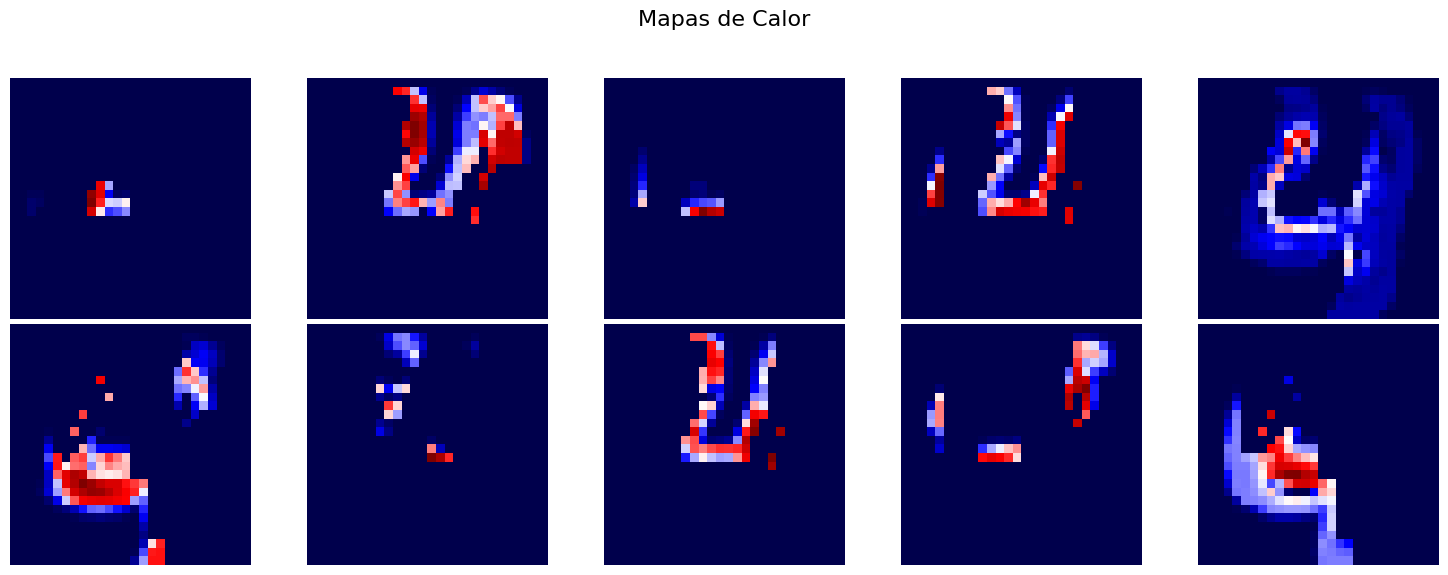

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 0.8315400005269051, Min: 0.0
Mapa 1: Max: 0.7786784325044797, Min: 0.0
Mapa 2: Max: 0.7593582887700534, Min: 0.0
Mapa 3: Max: 0.7001010179519653, Min: 0.0
Mapa 4: Max: 0.9842685461044312, Min: 0.0
Mapa 5: Max: 0.9500365853309631, Min: 0.0
Mapa 6: Max: 0.6310160427807486, Min: 0.0
Mapa 7: Max: 0.8856163620948792, Min: 0.0
Mapa 8: Max: 0.822944164276123, Min: 0.0
Mapa 9: Max: 0.9363747497301288, Min: 0.0
Cantidad de rasgos mayores que 0.85: 1
Indices mayores que 0.85: [208]
Suma clase objetivo: 0.9842685461044312
Suma de otras clases: 1.0037935322935767
IFI calculado: 8.824939223008545
Image 5, Class 4: LSE Value: 8.8249


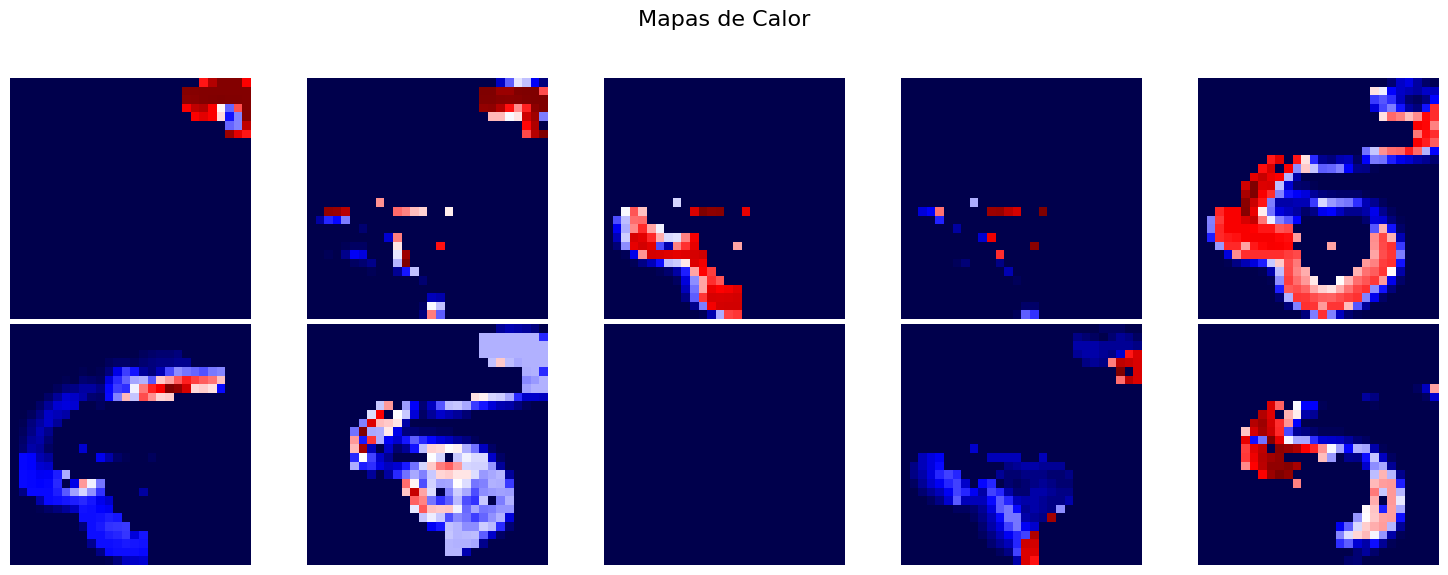

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 1
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 0.4526189863681793, Min: 0.0
Mapa 1: Max: 0.715043306350708, Min: 0.0
Mapa 2: Max: 0.7807486631016042, Min: 0.0
Mapa 3: Max: 0.605237603187561, Min: 0.0
Mapa 4: Max: 0.9122881272095961, Min: 0.0
Mapa 5: Max: 0.9073525667190552, Min: 0.0
Mapa 6: Max: 0.6717720031738281, Min: 0.0
Mapa 7: Max: 0.0, Min: 0.0
Mapa 8: Max: 0.4662019908428192, Min: 0.0
Mapa 9: Max: 0.8259264060603755, Min: 0.0
Cantidad de rasgos mayores que 0.85: 2
Indices mayores que 0.85: [214 215]
Suma clase objetivo: 1.7736627271468626
Suma de otras clases: 0.0
IFI calculado: 15.962964544321764
Image 6, Class 5: LSE Value: 15.9630


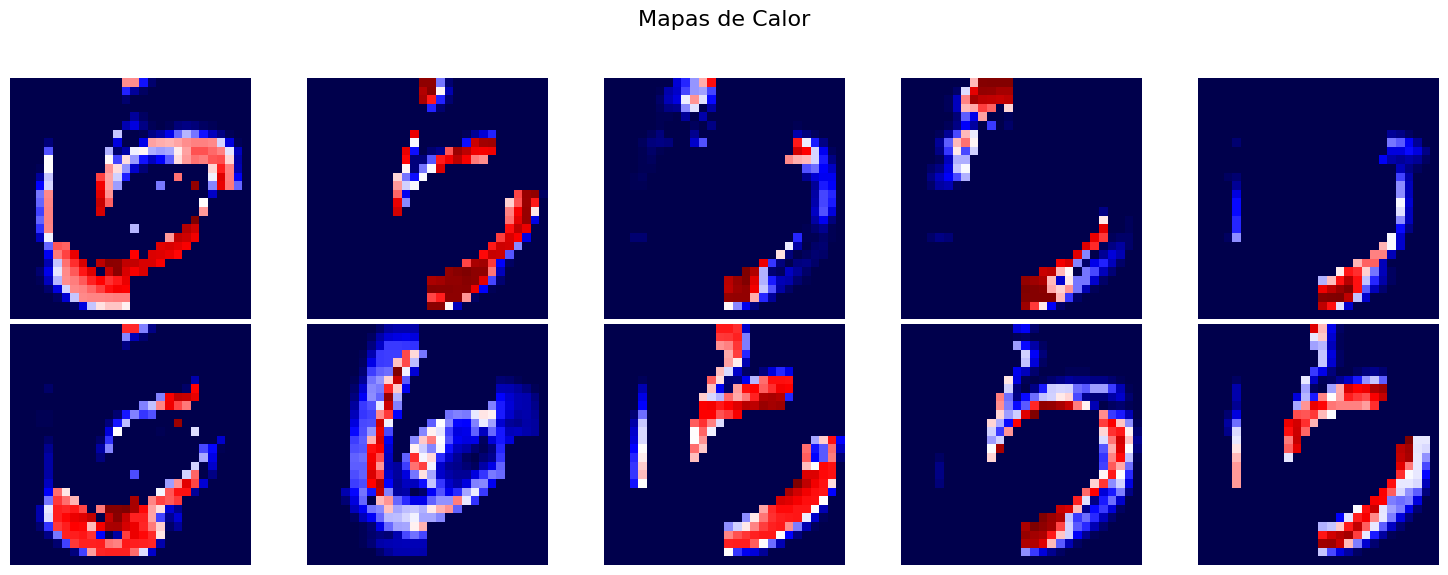

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 0.7690787315368652, Min: 0.0
Mapa 1: Max: 0.6923021078109741, Min: 0.0
Mapa 2: Max: 0.8871703718789277, Min: 0.0
Mapa 3: Max: 0.6028111577033997, Min: 0.0
Mapa 4: Max: 0.4664352238178253, Min: 0.0
Mapa 5: Max: 0.8968360031596047, Min: 0.0
Mapa 6: Max: 0.8342245989304814, Min: 0.0
Mapa 7: Max: 0.6822127103805542, Min: 0.0
Mapa 8: Max: 0.7516564130783081, Min: 0.0
Mapa 9: Max: 0.7134794494394647, Min: 0.0
Cantidad de rasgos mayores que 0.85: 0
Indices mayores que 0.85: []
Suma clase objetivo: 0.0
Suma de otras clases: 0.0
IFI calculado: 0
Image 7, Class 6: LSE Value: 0.0000


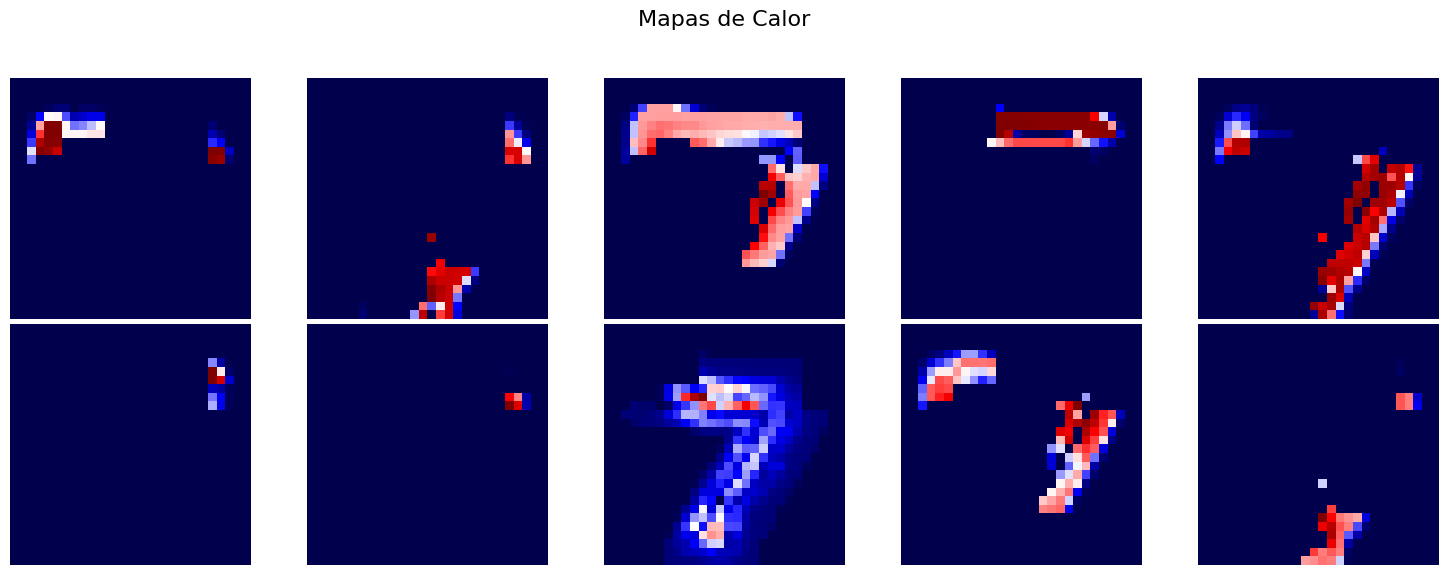

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 0.6700180172920227, Min: 0.0
Mapa 1: Max: 0.867294430732727, Min: 0.0
Mapa 2: Max: 0.775672252072756, Min: 0.0
Mapa 3: Max: 0.4500162899494171, Min: 0.0
Mapa 4: Max: 0.922303669007262, Min: 0.0
Mapa 5: Max: 0.6034784913063049, Min: 0.0
Mapa 6: Max: 0.8615548610687256, Min: 0.0
Mapa 7: Max: 0.9204754616167957, Min: 0.0
Mapa 8: Max: 0.8469547033309937, Min: 0.0
Mapa 9: Max: 0.7522972532158853, Min: 0.0
Cantidad de rasgos mayores que 0.85: 1
Indices mayores que 0.85: [235]
Suma clase objetivo: 0.9204754616167957
Suma de otras clases: 0.0
IFI calculado: 8.284279154551161
Image 8, Class 7: LSE Value: 8.2843


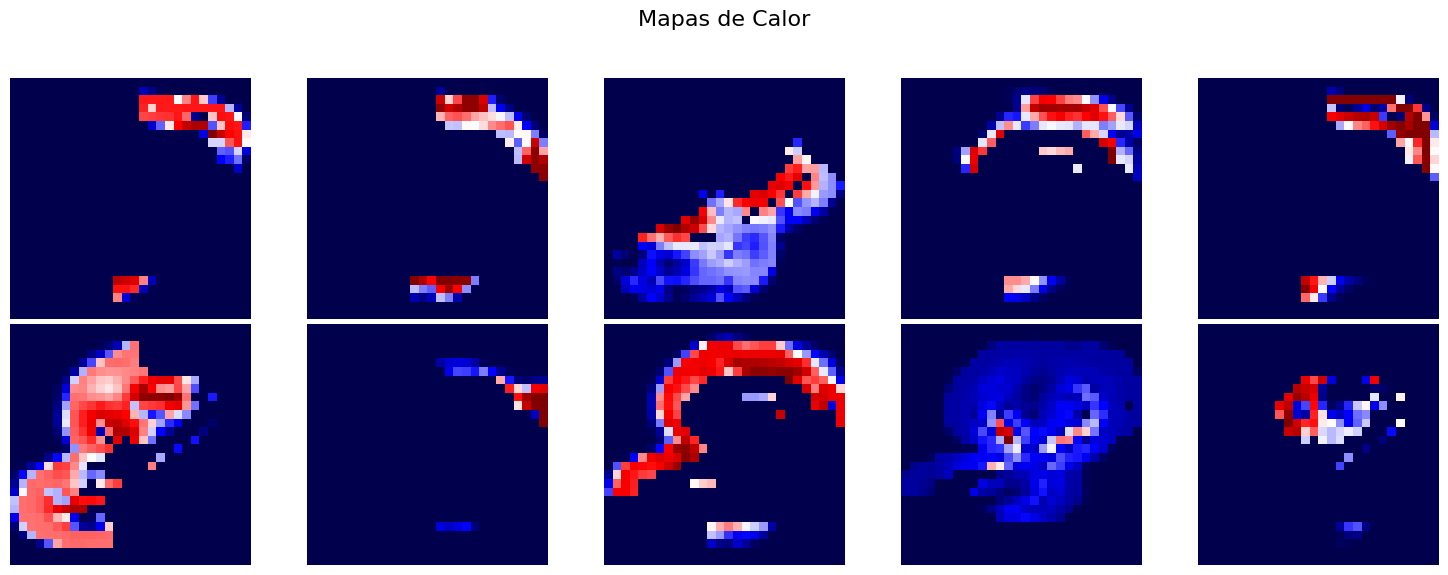

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 0.7378571033477783, Min: 0.0
Mapa 1: Max: 0.7840914726257324, Min: 0.0
Mapa 2: Max: 0.9215300679206848, Min: 0.0
Mapa 3: Max: 0.7165775401069517, Min: 0.0
Mapa 4: Max: 0.6743745803833008, Min: 0.0
Mapa 5: Max: 0.8022817585609997, Min: 0.0
Mapa 6: Max: 0.5849614143371582, Min: 0.0
Mapa 7: Max: 0.8511322140693665, Min: 0.0
Mapa 8: Max: 0.9891571998596191, Min: 0.0
Mapa 9: Max: 0.8824558039456851, Min: 0.0
Cantidad de rasgos mayores que 0.85: 2
Indices mayores que 0.85: [347 376]
Suma clase objetivo: 1.843237042427063
Suma de otras clases: 2.348877689267605
IFI calculado: 7.0625786338905385
Image 9, Class 8: LSE Value: 7.0626


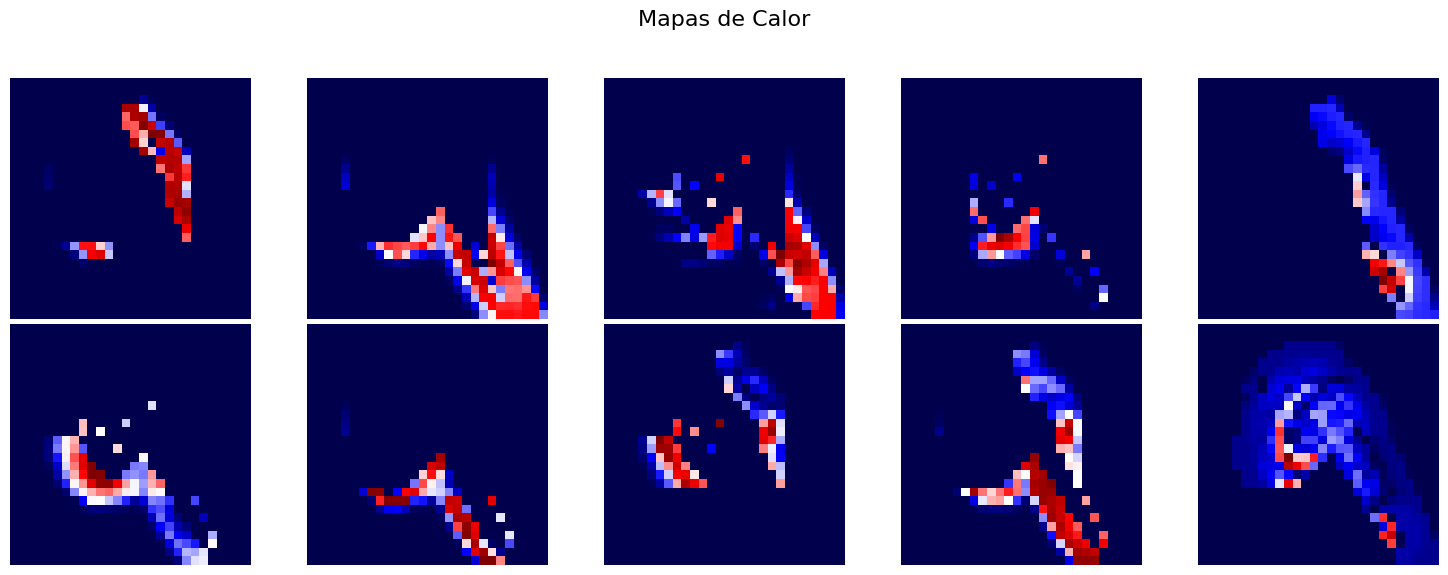

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 0.8606838583946228, Min: 0.0
Mapa 1: Max: 0.878917947415678, Min: 0.0
Mapa 2: Max: 0.8770053475935828, Min: 0.0
Mapa 3: Max: 0.9247437994209675, Min: 0.0
Mapa 4: Max: 0.99680048761196, Min: 0.0
Mapa 5: Max: 0.8955139517784119, Min: 0.0
Mapa 6: Max: 0.6403927206993103, Min: 0.0
Mapa 7: Max: 0.7519214153289795, Min: 0.0
Mapa 8: Max: 0.6878623366355896, Min: 0.0
Mapa 9: Max: 0.6825727637261658, Min: 0.0
Cantidad de rasgos mayores que 0.85: 0
Indices mayores que 0.85: []
Suma clase objetivo: 0.0
Suma de otras clases: 0.0
IFI calculado: 0
Image 10, Class 9: LSE Value: 0.0000


In [22]:
# Calculate LSE values using the integrated maps
lse_values_min = calculate_lse_per_image(integrated_explanations=min_explanations, y_selected=y_selected)

##AVG

In [23]:
def calculate_avg_per_pixel(explanations_data):
    """
    Calculates the pixel-wise average across all explanations for each image and class.
    """
    num_images = len(explanations_data[0]['explanations'])  # Number of images (10)
    num_classes = len(explanations_data[0]['explanations'][0])  # Number of classes (10)
    integrated_explanations = []  # To store the integrated results

    for image_idx in range(num_images):  # Iterate through each image
        print(f"\nProcessing image {image_idx + 1}/{num_images}...")
        image_maps = []  # Integrated maps per class for this image

        for class_idx in range(num_classes):  # Iterate through each class
            print(f"  Class {class_idx + 1}/{num_classes}:")

            # Collect heatmaps from the 4 methods for the same image and class
            class_maps = []
            for method_idx in range(len(explanations_data)):  # len(explanations_data) == 4
                map_ = explanations_data[method_idx]['explanations'][image_idx][class_idx]
                single_channel_map = ensure_single_channel(map_)
                normalized_map = normalize_map(single_channel_map)

                class_maps.append(normalized_map)
                print(f"    Method {method_idx + 1}: Shape: {normalized_map.shape}")

            # Convert the maps to a NumPy array (dimensions: (4, 28, 28))
            stacked_maps = np.stack(class_maps, axis=0)

            # Calculate the pixel-wise average along axis 0 (across the 4 methods)
            avg_map = np.mean(stacked_maps, axis=0)  # Dimensions: (28, 28)

            print(f"    Integrated map: Shape: {avg_map.shape}, "
                  f"Min: {np.min(avg_map):.4f}, Max: {np.max(avg_map):.4f}")

            # Save the integrated map per class
            image_maps.append(avg_map)

        integrated_explanations.append(image_maps)

    return integrated_explanations

In [ ]:
# Calculate integrated maps using avg
avg_explanations = calculate_avg_per_pixel(new_explanations_data)
visualize_all_classes(avg_explanations, x_selected, y_selected)


Processing image 1/10...
  Class 1/10:
    Method 1: Shape: (28, 28)
    Method 2: Shape: (28, 28)
    Method 3: Shape: (28, 28)
    Method 4: Shape: (28, 28)
    Integrated map: Shape: (28, 28), Min: 0.0331, Max: 0.9714
  Class 2/10:
    Method 1: Shape: (28, 28)
    Method 2: Shape: (28, 28)
    Method 3: Shape: (28, 28)
    Method 4: Shape: (28, 28)
    Integrated map: Shape: (28, 28), Min: 0.2242, Max: 0.9440
  Class 3/10:
    Method 1: Shape: (28, 28)
    Method 2: Shape: (28, 28)
    Method 3: Shape: (28, 28)
    Method 4: Shape: (28, 28)
    Integrated map: Shape: (28, 28), Min: 0.1219, Max: 0.9735
  Class 4/10:
    Method 1: Shape: (28, 28)
    Method 2: Shape: (28, 28)
    Method 3: Shape: (28, 28)
    Method 4: Shape: (28, 28)
    Integrated map: Shape: (28, 28), Min: 0.2645, Max: 0.9610
  Class 5/10:
    Method 1: Shape: (28, 28)
    Method 2: Shape: (28, 28)
    Method 3: Shape: (28, 28)
    Method 4: Shape: (28, 28)
    Integrated map: Shape: (28, 28), Min: 0.2208, Max: 0

In [ ]:
# Calculate LSE values using the integrated maps
lse_values_avg = calculate_lse_per_image(integrated_explanations=avg_explanations, y_selected=y_selected)

# Representations

In [ ]:
# Create a dictionary with the data
data = {
    'LSE_GradCAM': new_explanations_data[0]['lse_value'],
    'LSE_LRP': new_explanations_data[1]['lse_value'],
    'LSE_LIME': new_explanations_data[2]['lse_value'],
    'LSE_SHAP': new_explanations_data[3]['lse_value'],
    'LSE_Integrated_W': lse_integrated_sum,
    # 'LSE_Integrated_W_average': lse_integrated_average,
    # 'LSE_Integrated_S': lse_integrated_simple,
    'LSE_Union_W': lse_integrated_union,
    # 'LSE_Union_Max': union_max_lse,
    'LSE_Intersection_W': lse_integrated_intersection,
    'LSE_MAX': lse_values_max,
    'LSE_MIN': lse_values_min,
    'LSE_AVG': lse_values_avg,
    # 'LSE_Intersection_Max':  intersection_max_lse
}

# Convert the dictionary into a DataFrame
df_lse = pd.DataFrame(data)
# Calculate the average of each column and add it as a new row
df_lse.loc['Average'] = df_lse.mean()

# Save the DataFrame to an Excel file
df_lse.to_excel("Images/Relevance/lse_values_relevance_integration.xlsx", index=False)

# Display the DataFrame
print(df_lse)

In [ ]:
predictions = [(loaded_model.predict(np.expand_dims(image, axis=0))) for image in x_selected]
# predictions

In [ ]:
explanations_dict = {
    'GradCAM': new_explanations_data[0]['explanations'],
    'LRP': new_explanations_data[1]['explanations'],
    'LIME': new_explanations_data[2]['explanations'],
    'SHAP': new_explanations_data[3]['explanations'],
    'OWA': integrated_explanations_sum,
    'Union': integrated_explanations_union,
    'Intersection': integrated_explanations_intersection,
    'MAX': max_explanations,
    'MIN': min_explanations,
    'AVG': avg_explanations
}

visualize_explanations_horizontal_with_original(x_selected, y_selected,predictions, explanations_dict, x_selected, y_selected)